# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import sys
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
import tsc_utils as tu
import time
import datetime

In [2]:
# Load pickled data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
norm_done = False

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

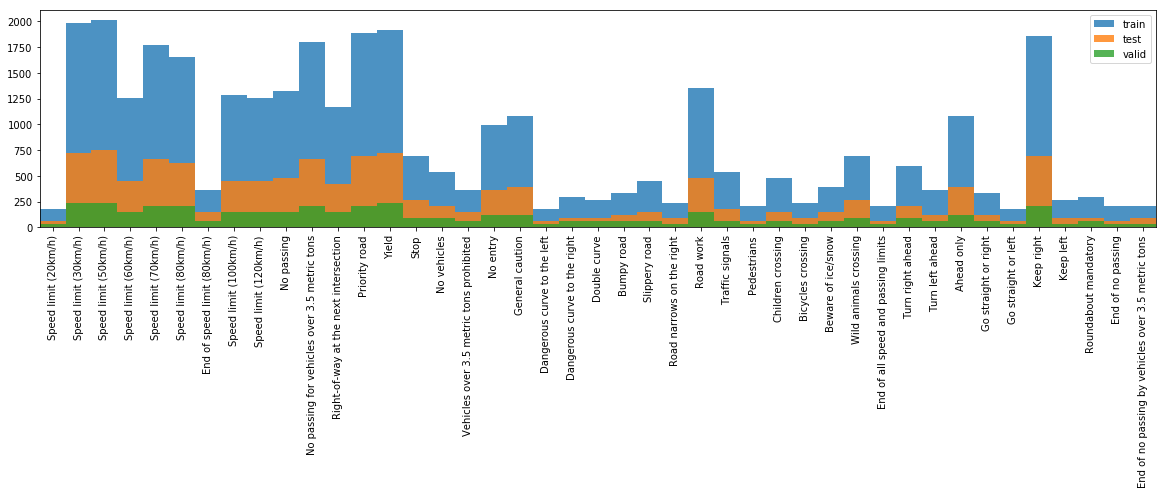

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
sign_df = pd.read_csv('signnames.csv')
df = pd.Series(y_train).value_counts().to_frame('label_counts')
sign_df = pd.merge(sign_df, df, left_on='ClassId', right_index=True)
sign_df['label_freq'] = sign_df['label_counts'] / sign_df['label_counts'].sum() 
sign_df['label_freq_normed'] = sign_df['label_freq'] / sign_df['label_freq'].mean()
sign_df = sign_df.set_index('ClassId')

def plot_data():
    plt.figure(figsize=(20,4))
    a = 0.8
    plt.hist(y_train, alpha=a, bins=np.arange(n_classes+1)-0.5)
    plt.hist(y_test, alpha=a, bins=np.arange(n_classes+1)-0.5)
    plt.hist(y_valid, alpha=a, bins=np.arange(n_classes+1)-0.5)
    plt.xticks(range(n_classes), sign_df['SignName'], rotation='vertical')
    plt.legend(['train', 'test', 'valid'])
    plt.autoscale(enable=True, axis='x', tight=True)

plot_data()

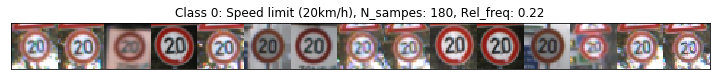

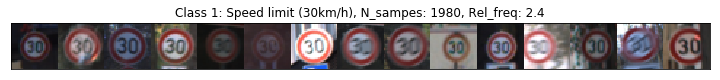

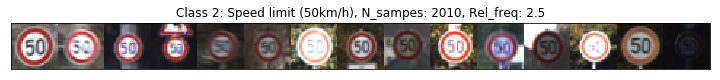

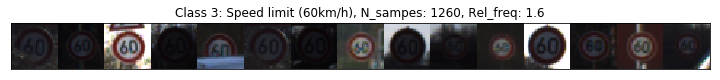

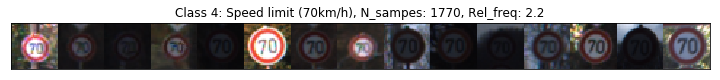

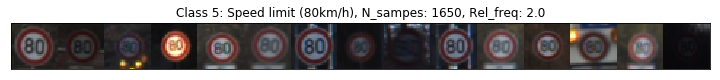

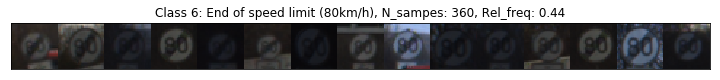

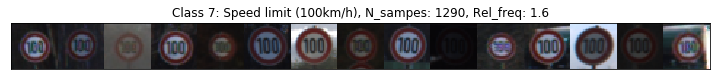

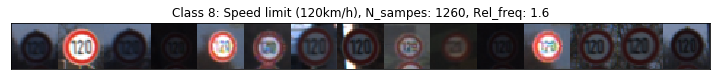

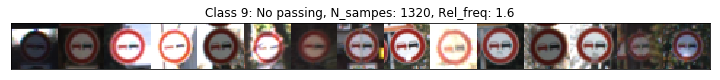

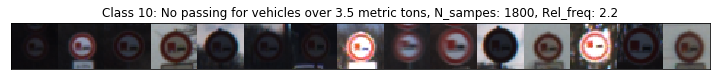

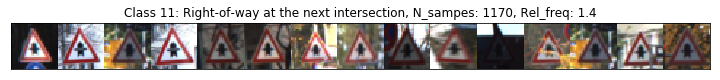

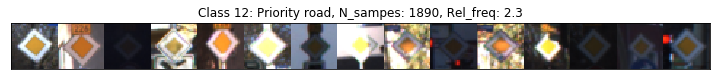

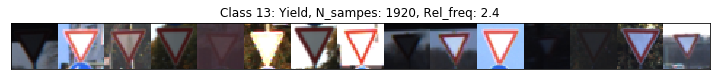

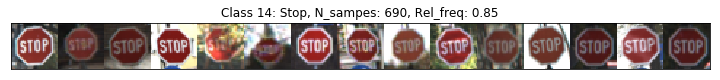

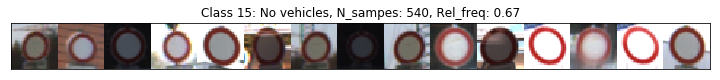

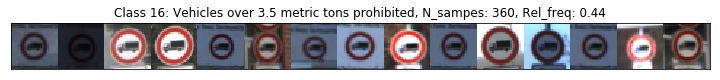

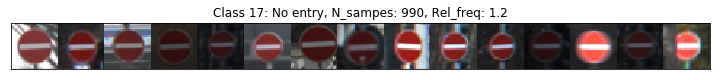

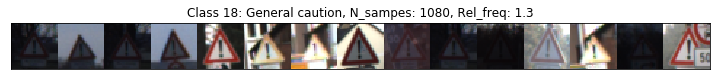

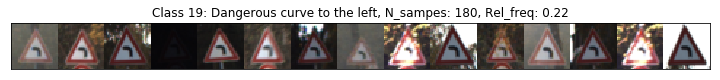

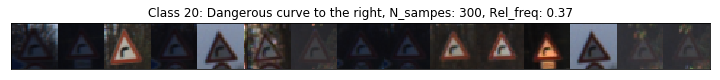

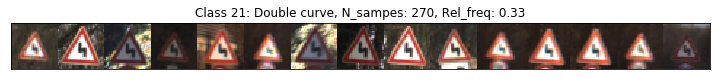

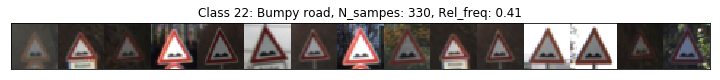

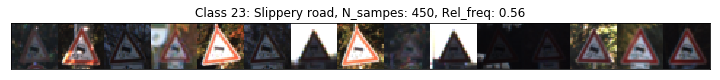

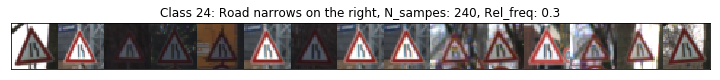

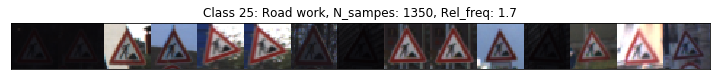

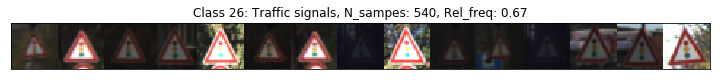

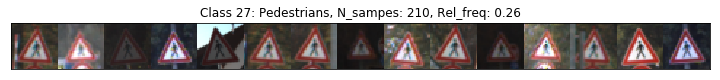

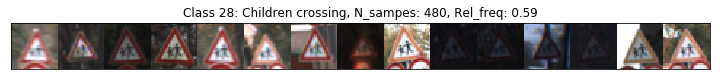

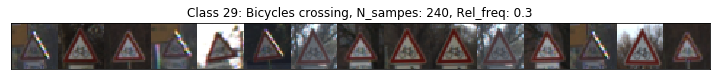

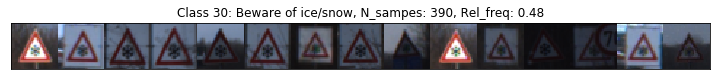

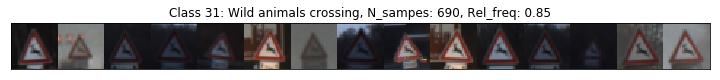

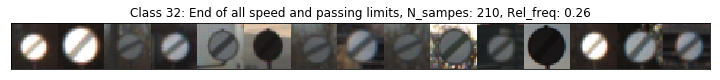

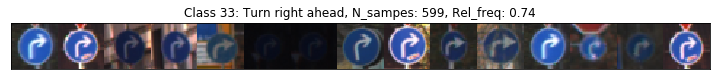

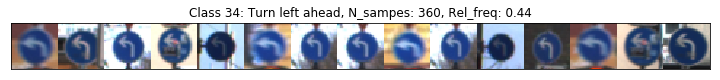

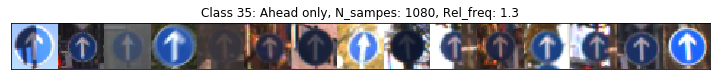

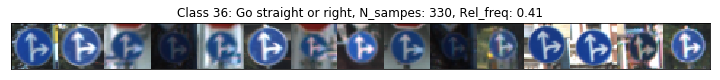

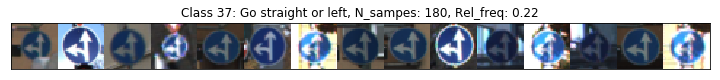

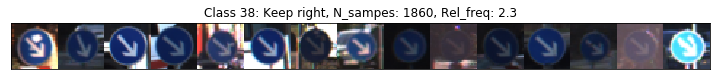

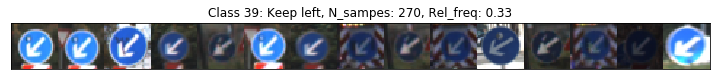

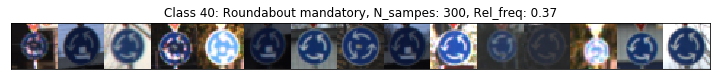

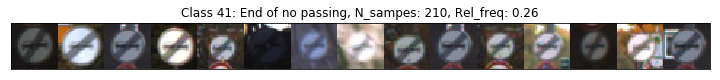

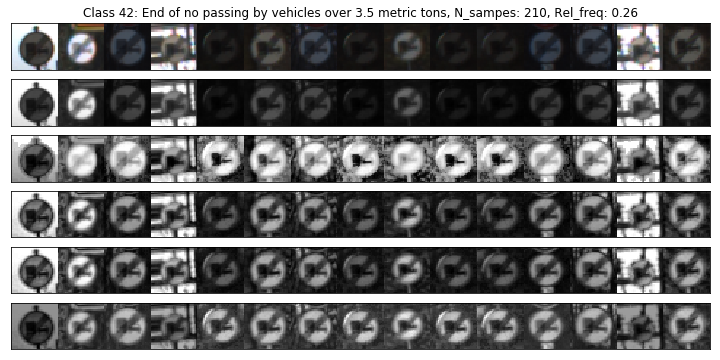

In [5]:
np.random.seed(1019)
N = n_classes
M = 15
img_canvas = []
img_canvas_gray = []
clahe = tu.DEFAULT_CLAHE
for i in range(n_classes):
    X_select = X_train[y_train == i]
    
    idx = np.random.choice(np.arange(X_select.shape[0]), M)
    img_canvas = np.concatenate(X_select[idx], axis=1)
    gray_images = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X_select[idx]]
    img_canvas_gray = np.concatenate(gray_images, axis=1)
    
    gray_images_equ = [cv2.equalizeHist(x) for x in gray_images]
    img_canvas_equ = np.concatenate(gray_images_equ, axis=1)
    
    gray_images_Lequ = [clahe.apply(x) for x in gray_images]
    img_canvas_Lequ = np.concatenate(gray_images_Lequ, axis=1)
    
    gray_images_Lequ_normed = [(x-128.)/128 for x in gray_images_Lequ]
    img_canvas_Lequ_normed = np.concatenate(gray_images_Lequ_normed, axis=1)
    
    gray_images_Lequ_normed_v2 = [(x-x.mean())/x.std() for x in gray_images_Lequ]
    img_canvas_Lequ_normed_v2 = np.concatenate(gray_images_Lequ_normed_v2, axis=1)
    
    N = 6
    
    plt.figure(figsize=(20,6))
    plt.subplot(N,1,1)
    plt.imshow(img_canvas)
    plt.xticks([])
    plt.yticks([])
    plt.title('Class {}: {}, N_sampes: {}, Rel_freq: {:.2}'.format(i, sign_df.loc[i]['SignName'], sign_df.loc[i]['label_counts'],sign_df.loc[i]['label_freq_normed']))
    
    if i == n_classes-1:
        plt.subplot(N,1,2)
        plt.imshow(img_canvas_gray, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,3)
        plt.imshow(img_canvas_equ, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,4)
        plt.imshow(img_canvas_Lequ, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,5)
        plt.imshow(img_canvas_Lequ_normed, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(N,1,6)
        plt.imshow(img_canvas_Lequ_normed_v2, cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.show()


# Dataset augmentation

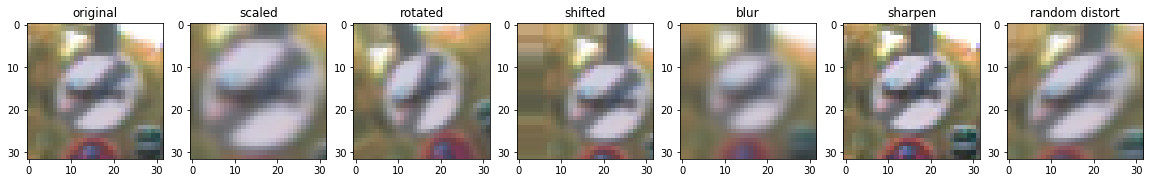

In [6]:
# demonstraing a set of functions for image transformation
test_img = X_train[100]
plt.figure(figsize=(20,10))
N = 7
i=1
plt.subplot(1, N, i)
plt.imshow(test_img)
plt.title('original')

i+=1
plt.subplot(1, N, i)
plt.imshow(tu.resize_img(test_img, scale=1.15))
plt.title('scaled')

i+=1
plt.subplot(1, N, i)
plt.imshow(tu.rotate_img(test_img, angle=25))
plt.title('rotated')

i+=1
plt.subplot(1, N, i)
plt.imshow(tu.shift_img(test_img, dx=5, dy=2))
plt.title('shifted')

i+=1
b, s = tu.blur_and_sharpen_img(test_img, kernel=(5,5), factor=0.8)
plt.subplot(1, N, i)
plt.imshow(b)
plt.title('blur')
i+=1
plt.subplot(1, N, i)
plt.imshow(s)
plt.title('sharpen')

i+=1
plt.subplot(1, N, i)
np.random.seed(1019)
plt.imshow(tu.distort_img(test_img, d_limit=5))
plt.title('random distort')

plt.show()

In [7]:
# merge X_train and X_valid

# print(X_train.shape)
# X_train = np.concatenate([X_train, X_valid], axis=0)
# print(X_train.shape)
# print(y_train.shape)
# y_train = np.concatenate([y_train, y_valid], axis=0)
# print(y_train.shape)

In [8]:
regen_data = False

if regen_data:
    flip_extend = False
    augment_data = False
    aug_factor = 0.7

    if flip_extend:
        X_train, y_train = tu.flip_extend(X_train, y_train)
        X_valid, y_valid = tu.flip_extend(X_valid, y_valid)

    if augment_data:
        setting = dict(distort=True,
                       resize=True, 
                       rotate=True, 
                       shift=True, 
                       blursharpen=True)
        boost=False

        if boost:
            target_y = [26, 21]
            N_copy = 10
            X_train_boost, y_train_boost = tu.augment_data(X_train, y_train, N_copy=N_copy, target_y=target_y, **setting)
            X_valid_boost, y_valid_boost = tu.augment_data(X_valid, y_valid, N_copy=N_copy, target_y=target_y, **setting)

        X_train, y_train = tu.augment_data(X_train, y_train, **setting, factor=aug_factor)
        X_valid, y_valid = tu.augment_data(X_valid, y_valid, **setting, factor=aug_factor)

        if boost:
            X_train = np.concatenate([X_train, X_train_boost], axis=0)
            y_train = np.concatenate([y_train, y_train_boost], axis=0)
            X_valid = np.concatenate([X_valid, X_valid_boost], axis=0)
            y_valid = np.concatenate([y_valid, y_valid_boost], axis=0)

    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

if regen_data:
    # color conversion, hist equalization and normalization
    X_train = tu.preprocess_data(X_train)
    X_valid = tu.preprocess_data(X_valid)
    X_test = tu.preprocess_data(X_test)
    norm_done = True

In [10]:
if regen_data:
    if X_train.nbytes > 4e9:
        print(X_train.nbytes)
        X_train = X_train.astype(np.float32)
        X_valid = X_valid.astype(np.float32)
    print(X_train.nbytes)

In [11]:
if regen_data:
    test_preprocessed_dataset_file = 'data/test_preprocessed.p'
    print(test_preprocessed_dataset_file)
    pickle.dump({"features": X_test, "labels": y_test}, open(test_preprocessed_dataset_file, "wb"))

    flip_str = ''
    augment_str = ''
    if flip_extend:
        flip_str = 'flip_extended_'

    if augment_data:
        augment_str = 'augmented_'
        if aug_factor != 1:
            augment_str += str(aug_factor) + '_'

    train_preprocessed_dataset_file = 'data/train_{}{}preprocessed.p'.format(flip_str, augment_str)
    print(train_preprocessed_dataset_file)
    pickle.dump({"features": X_train, "labels": y_train}, open(train_preprocessed_dataset_file, "wb"))

    valid_preprocessed_dataset_file = 'data/valid_{}{}preprocessed.p'.format(flip_str, augment_str)
    print(valid_preprocessed_dataset_file)
    pickle.dump({"features": X_valid, "labels": y_valid}, open(valid_preprocessed_dataset_file, "wb"))

In [12]:
if regen_data:
    np.random.seed(1019)

    plt.figure(figsize=(35,10))
    N = 35
    M = 10

    X_tmp = X_train

    img_canvas = []
    for i in range(M):
        idx = np.random.choice(np.arange(X_tmp.shape[0]), N)
        img_canvas.append(np.concatenate(X_tmp[idx], axis=1))

    img_canvas = np.concatenate(img_canvas, axis=0)

    if img_canvas.shape[-1]==1:
        plt.imshow(img_canvas.squeeze(), cmap='gray')
    elif img_canvas.shape[-1]==3:
        plt.imshow(img_canvas)
    else:
        plt.imshow(img_canvas[:,:,0], cmap='gray')

### Model Architecture

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [2]:
# load data

# original set
train_fname = 'data/train_preprocessed.p'
valid_fname = 'data/valid_preprocessed.p'

# augmented set with smaller variations
train_fname_FA_fine = 'data/train_flip_extended_augmented_0.7_preprocessed.p'
valid_fname_FA_fine = 'data/valid_flip_extended_augmented_0.7_preprocessed.p'

# augmented set
train_fname_FA = 'data/train_flip_extended_augmented_preprocessed.p'
valid_fname_FA = 'data/valid_flip_extended_augmented_preprocessed.p'

# flip extended set
train_fname_F = 'data/train_flip_extended_preprocessed.p'
valid_fname_F = 'data/valid_flip_extended_preprocessed.p'


test_fname = 'data/test_preprocessed.p'

def data_loader(train_file, valid_file, test_file):
    X_train, y_train = tu.load_pickled_data(train_file, columns = ['features', 'labels'])
    X_valid, y_valid = tu.load_pickled_data(valid_file, columns = ['features', 'labels'])
    X_test, y_test = tu.load_pickled_data(test_file, columns = ['features', 'labels'])
    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    print(X_test.shape, y_test.shape)
    return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [3]:
data_set1 = data_loader(train_fname_F, valid_fname_F, test_fname)
data_set2 = data_loader(train_fname_FA, valid_fname_FA, test_fname)
data_set3 = data_loader(train_fname_FA_fine, valid_fname_FA_fine, test_fname)

(59788, 32, 32, 1) (59788,)
(7590, 32, 32, 1) (7590,)
(12630, 32, 32, 1) (12630,)
(1016396, 32, 32, 1) (1016396,)
(129030, 32, 32, 1) (129030,)
(12630, 32, 32, 1) (12630,)
(1016396, 32, 32, 1) (1016396,)
(129030, 32, 32, 1) (129030,)
(12630, 32, 32, 1) (12630,)


In [16]:
# Original LeNet5
model = tu.lenet
params = tu.params_orig_lenet
config = dict(model=model, model_params=params, resuming=True)

_ = tu.train_model(*data_set1, **config, learning_rate=0.001)
_ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
_ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028400100E18>
model_params = {'conv1_d': 6, 'model_name': 'lenet', 'conv2_p': 0.95, 'conv2_d': 16, 'conv1_k': 5, 'conv1_p': 0.95, 'fc4_p': 0.5, 'conv2_k': 5, 'fc3_size': 120, 'fc3_p': 0.5, 'num_classes': 43, 'fc4_size': 84}
learning_rate = 0.001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet__conv1_d_6_conv1_k_5_conv1_p_0.95_conv2_d_16_conv2_k_5_conv2_p_0.95_fc3_p_0.5_fc3_size_120_fc4_p_0.5_fc4_size_84
6f1fbf83feb9ed73
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73
{'conv1_d': 6, 'model_name': 'lenet', 'conv2_p': 0.95, 'conv2_d': 16, 'conv1_k': 5, 'conv1_p': 0.95, 'fc4_p': 0.5, 'conv2_k': 5, 'fc3_size': 120, 'fc3_p': 0.5, 'num_classes': 43, 'fc4_size': 84}
lenet pool2 reshaped size:  [None, 1024]
INFO:tensor

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 62.18it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.00717901, accuracy: 99.84%
Validation loss: 0.08147191, accuracy: 98.45%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:07
      Timestamp: 2017/06/11 12:27:11


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.53it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.00802511, accuracy: 99.83%
Validation loss: 0.07968920, accuracy: 98.21%
      Best loss: 0.08147191 at epoch 0
   Elapsed time: 00:00:12
      Timestamp: 2017/06/11 12:27:16


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 72.33it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00522739, accuracy: 99.89%
Validation loss: 0.07678971, accuracy: 98.37%
      Best loss: 0.07968920 at epoch 1
   Elapsed time: 00:00:17
      Timestamp: 2017/06/11 12:27:21


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 71.95it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00504336, accuracy: 99.89%
Validation loss: 0.08193922, accuracy: 98.31%
      Best loss: 0.07678971 at epoch 2
   Elapsed time: 00:00:22
      Timestamp: 2017/06/11 12:27:26


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 72.73it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00463755, accuracy: 99.92%
Validation loss: 0.07672022, accuracy: 98.30%
      Best loss: 0.07678971 at epoch 2
   Elapsed time: 00:00:26
      Timestamp: 2017/06/11 12:27:30


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.70it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00413217, accuracy: 99.92%
Validation loss: 0.08582439, accuracy: 98.13%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:31
      Timestamp: 2017/06/11 12:27:35


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.08it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00378544, accuracy: 99.92%
Validation loss: 0.08826865, accuracy: 98.12%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:36
      Timestamp: 2017/06/11 12:27:40


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.99it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00341605, accuracy: 99.92%
Validation loss: 0.08188203, accuracy: 98.14%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:40
      Timestamp: 2017/06/11 12:27:44


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.81it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00318626, accuracy: 99.94%
Validation loss: 0.09127359, accuracy: 98.29%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:44
      Timestamp: 2017/06/11 12:27:48


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.69it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00324488, accuracy: 99.95%
Validation loss: 0.10806034, accuracy: 97.98%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:49
      Timestamp: 2017/06/11 12:27:53


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.79it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00303007, accuracy: 99.94%
Validation loss: 0.09634317, accuracy: 97.89%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:53
      Timestamp: 2017/06/11 12:27:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.08it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00367098, accuracy: 99.92%
Validation loss: 0.08853099, accuracy: 98.14%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:00:57
      Timestamp: 2017/06/11 12:28:02


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.97it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00238200, accuracy: 99.96%
Validation loss: 0.08531516, accuracy: 98.35%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:01:02
      Timestamp: 2017/06/11 12:28:06


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.23it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00232851, accuracy: 99.95%
Validation loss: 0.08469503, accuracy: 98.18%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:01:06
      Timestamp: 2017/06/11 12:28:10


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.02it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00219405, accuracy: 99.97%
Validation loss: 0.06870357, accuracy: 98.19%
      Best loss: 0.07672022 at epoch 4
   Elapsed time: 00:01:11
      Timestamp: 2017/06/11 12:28:15


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.81it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00236518, accuracy: 99.96%
Validation loss: 0.07298072, accuracy: 98.14%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:16
      Timestamp: 2017/06/11 12:28:20


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.06it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00211863, accuracy: 99.96%
Validation loss: 0.07025390, accuracy: 98.25%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:20
      Timestamp: 2017/06/11 12:28:24


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.83it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00250835, accuracy: 99.96%
Validation loss: 0.08939187, accuracy: 98.30%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:24
      Timestamp: 2017/06/11 12:28:28


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 73.64it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00193733, accuracy: 99.96%
Validation loss: 0.08612721, accuracy: 98.26%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:29
      Timestamp: 2017/06/11 12:28:33


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.06it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00236921, accuracy: 99.97%
Validation loss: 0.09755322, accuracy: 98.12%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:33
      Timestamp: 2017/06/11 12:28:37


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.35it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00169719, accuracy: 99.97%
Validation loss: 0.08485530, accuracy: 98.29%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:37
      Timestamp: 2017/06/11 12:28:41


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.10it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00164191, accuracy: 99.98%
Validation loss: 0.08233807, accuracy: 98.22%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:42
      Timestamp: 2017/06/11 12:28:46


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.37it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00228131, accuracy: 99.95%
Validation loss: 0.08137669, accuracy: 98.33%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:46
      Timestamp: 2017/06/11 12:28:50


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.04it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00168203, accuracy: 99.97%
Validation loss: 0.10618933, accuracy: 98.10%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:50
      Timestamp: 2017/06/11 12:28:55


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.06it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00161615, accuracy: 99.97%
Validation loss: 0.10614433, accuracy: 98.16%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:55
      Timestamp: 2017/06/11 12:28:59


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:03<00:00, 74.38it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00168078, accuracy: 99.97%
Validation loss: 0.09479815, accuracy: 98.26%
      Best loss: 0.06870357 at epoch 14
   Elapsed time: 00:01:59
      Timestamp: 2017/06/11 12:29:03
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\best_epoch
Early stopping.
Best monitored loss was 0.06870357 at epoch 14.
 Valid loss: 0.06870357, accuracy = 98.19%)
 Test loss: 0.14452103, accuracy = 96.40%)
 Total time: 00:02:00
  Timestamp: 2017/06/11 12:29:04
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028400100E18>
model_params = {'conv1_d': 6, 'model_name': 'lenet', 'conv2_p': 0.95,

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.35it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.08715447, accuracy: 97.52%
Validation loss: 0.18547683, accuracy: 94.88%
      Best loss: inf at epoch 0
   Elapsed time: 00:01:10
      Timestamp: 2017/06/11 12:30:15


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.75it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.07590455, accuracy: 97.86%
Validation loss: 0.17489646, accuracy: 95.30%
      Best loss: 0.18547683 at epoch 0
   Elapsed time: 00:02:21
      Timestamp: 2017/06/11 12:31:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.92it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.07052472, accuracy: 98.03%
Validation loss: 0.17036409, accuracy: 95.38%
      Best loss: 0.17489646 at epoch 1
   Elapsed time: 00:03:32
      Timestamp: 2017/06/11 12:32:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.62it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.06641792, accuracy: 98.14%
Validation loss: 0.17035314, accuracy: 95.52%
      Best loss: 0.17036409 at epoch 2
   Elapsed time: 00:04:42
      Timestamp: 2017/06/11 12:33:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.67it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.06432645, accuracy: 98.20%
Validation loss: 0.16843002, accuracy: 95.53%
      Best loss: 0.17035314 at epoch 3
   Elapsed time: 00:05:52
      Timestamp: 2017/06/11 12:34:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.53it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.06204717, accuracy: 98.26%
Validation loss: 0.16376753, accuracy: 95.65%
      Best loss: 0.16843002 at epoch 4
   Elapsed time: 00:07:02
      Timestamp: 2017/06/11 12:36:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.63it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.06084426, accuracy: 98.32%
Validation loss: 0.16318964, accuracy: 95.60%
      Best loss: 0.16376753 at epoch 5
   Elapsed time: 00:08:12
      Timestamp: 2017/06/11 12:37:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.17it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.05916393, accuracy: 98.39%
Validation loss: 0.15950150, accuracy: 95.71%
      Best loss: 0.16318964 at epoch 6
   Elapsed time: 00:09:23
      Timestamp: 2017/06/11 12:38:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.16it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.05813179, accuracy: 98.40%
Validation loss: 0.15964817, accuracy: 95.75%
      Best loss: 0.15950150 at epoch 7
   Elapsed time: 00:10:34
      Timestamp: 2017/06/11 12:39:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.83it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.05646210, accuracy: 98.46%
Validation loss: 0.15725185, accuracy: 95.84%
      Best loss: 0.15950150 at epoch 7
   Elapsed time: 00:11:43
      Timestamp: 2017/06/11 12:40:48


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.62it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.05578327, accuracy: 98.47%
Validation loss: 0.15832479, accuracy: 95.81%
      Best loss: 0.15725185 at epoch 9
   Elapsed time: 00:12:53
      Timestamp: 2017/06/11 12:41:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.37it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.05536416, accuracy: 98.51%
Validation loss: 0.15069679, accuracy: 95.87%
      Best loss: 0.15725185 at epoch 9
   Elapsed time: 00:14:03
      Timestamp: 2017/06/11 12:43:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.39it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.05366811, accuracy: 98.54%
Validation loss: 0.15500949, accuracy: 95.88%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:15:13
      Timestamp: 2017/06/11 12:44:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.73it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.05285227, accuracy: 98.57%
Validation loss: 0.15387468, accuracy: 95.93%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:16:22
      Timestamp: 2017/06/11 12:45:27


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.93it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.05303591, accuracy: 98.56%
Validation loss: 0.15344285, accuracy: 95.94%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:17:31
      Timestamp: 2017/06/11 12:46:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.87it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.05274041, accuracy: 98.57%
Validation loss: 0.15553640, accuracy: 95.94%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:18:41
      Timestamp: 2017/06/11 12:47:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.81it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.05215232, accuracy: 98.60%
Validation loss: 0.15572665, accuracy: 95.91%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:19:50
      Timestamp: 2017/06/11 12:48:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.87it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.05108293, accuracy: 98.63%
Validation loss: 0.15367263, accuracy: 95.97%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:20:59
      Timestamp: 2017/06/11 12:50:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.80it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.05173469, accuracy: 98.58%
Validation loss: 0.15605183, accuracy: 95.82%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:22:09
      Timestamp: 2017/06/11 12:51:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.83it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.05002742, accuracy: 98.65%
Validation loss: 0.15271396, accuracy: 96.01%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:23:18
      Timestamp: 2017/06/11 12:52:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.90it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.04985487, accuracy: 98.67%
Validation loss: 0.15134529, accuracy: 96.01%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:24:27
      Timestamp: 2017/06/11 12:53:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.48it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.04906083, accuracy: 98.68%
Validation loss: 0.15510254, accuracy: 95.98%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:25:36
      Timestamp: 2017/06/11 12:54:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.73it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.04928047, accuracy: 98.66%
Validation loss: 0.15271813, accuracy: 95.99%
      Best loss: 0.15069679 at epoch 11
   Elapsed time: 00:26:46
      Timestamp: 2017/06/11 12:55:50
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\best_epoch
Early stopping.
Best monitored loss was 0.15069679 at epoch 11.
 Valid loss: 0.15069679, accuracy = 95.87%)
 Test loss: 0.10940567, accuracy = 96.63%)
 Total time: 00:26:48
  Timestamp: 2017/06/11 12:55:53
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028400100E18>
model_params = {'conv1_d': 6, 'model_name': 'lenet', 'conv2_p': 0.95,

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.30it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.18086049, accuracy: 94.81%
Validation loss: 0.28995687, accuracy: 91.90%
      Best loss: inf at epoch 0
   Elapsed time: 00:01:16
      Timestamp: 2017/06/11 12:57:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.15it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.15825157, accuracy: 95.46%
Validation loss: 0.26201095, accuracy: 92.53%
      Best loss: 0.28995687 at epoch 0
   Elapsed time: 00:02:27
      Timestamp: 2017/06/11 12:58:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.49it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.14409044, accuracy: 95.85%
Validation loss: 0.24684305, accuracy: 92.92%
      Best loss: 0.26201095 at epoch 1
   Elapsed time: 00:03:37
      Timestamp: 2017/06/11 12:59:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.91it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.13344874, accuracy: 96.15%
Validation loss: 0.23831613, accuracy: 93.17%
      Best loss: 0.24684305 at epoch 2
   Elapsed time: 00:04:47
      Timestamp: 2017/06/11 13:00:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.16it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.12595060, accuracy: 96.36%
Validation loss: 0.22970018, accuracy: 93.40%
      Best loss: 0.23831613 at epoch 3
   Elapsed time: 00:05:57
      Timestamp: 2017/06/11 13:01:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.84it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.12048826, accuracy: 96.53%
Validation loss: 0.22288670, accuracy: 93.57%
      Best loss: 0.22970018 at epoch 4
   Elapsed time: 00:07:08
      Timestamp: 2017/06/11 13:03:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.32it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.11452409, accuracy: 96.69%
Validation loss: 0.21817067, accuracy: 93.73%
      Best loss: 0.22288670 at epoch 5
   Elapsed time: 00:08:18
      Timestamp: 2017/06/11 13:04:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.51it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.11033673, accuracy: 96.84%
Validation loss: 0.21610488, accuracy: 93.85%
      Best loss: 0.21817067 at epoch 6
   Elapsed time: 00:09:28
      Timestamp: 2017/06/11 13:05:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.26it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.10720075, accuracy: 96.92%
Validation loss: 0.21218954, accuracy: 93.94%
      Best loss: 0.21610488 at epoch 7
   Elapsed time: 00:10:38
      Timestamp: 2017/06/11 13:06:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.87it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.10427837, accuracy: 97.03%
Validation loss: 0.20723970, accuracy: 94.05%
      Best loss: 0.21218954 at epoch 8
   Elapsed time: 00:11:49
      Timestamp: 2017/06/11 13:07:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.18it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.10098588, accuracy: 97.13%
Validation loss: 0.20353896, accuracy: 94.15%
      Best loss: 0.20723970 at epoch 9
   Elapsed time: 00:13:03
      Timestamp: 2017/06/11 13:08:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.94it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.09842368, accuracy: 97.19%
Validation loss: 0.20307224, accuracy: 94.20%
      Best loss: 0.20353896 at epoch 10
   Elapsed time: 00:14:14
      Timestamp: 2017/06/11 13:10:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.54it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.09643076, accuracy: 97.25%
Validation loss: 0.20075656, accuracy: 94.26%
      Best loss: 0.20307224 at epoch 11
   Elapsed time: 00:15:24
      Timestamp: 2017/06/11 13:11:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.69it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.09413770, accuracy: 97.33%
Validation loss: 0.19921709, accuracy: 94.35%
      Best loss: 0.20075656 at epoch 12
   Elapsed time: 00:16:34
      Timestamp: 2017/06/11 13:12:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.26it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.09242310, accuracy: 97.38%
Validation loss: 0.19705051, accuracy: 94.42%
      Best loss: 0.19921709 at epoch 13
   Elapsed time: 00:17:44
      Timestamp: 2017/06/11 13:13:38


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.13it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.09050103, accuracy: 97.43%
Validation loss: 0.19483382, accuracy: 94.44%
      Best loss: 0.19705051 at epoch 14
   Elapsed time: 00:18:55
      Timestamp: 2017/06/11 13:14:49


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.18it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.08896147, accuracy: 97.49%
Validation loss: 0.19317227, accuracy: 94.46%
      Best loss: 0.19483382 at epoch 15
   Elapsed time: 00:20:05
      Timestamp: 2017/06/11 13:15:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.16it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.08795684, accuracy: 97.52%
Validation loss: 0.19411056, accuracy: 94.51%
      Best loss: 0.19317227 at epoch 16
   Elapsed time: 00:21:16
      Timestamp: 2017/06/11 13:17:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.69it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.08560706, accuracy: 97.58%
Validation loss: 0.19151135, accuracy: 94.57%
      Best loss: 0.19317227 at epoch 16
   Elapsed time: 00:22:26
      Timestamp: 2017/06/11 13:18:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.46it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.08454620, accuracy: 97.61%
Validation loss: 0.19130265, accuracy: 94.58%
      Best loss: 0.19151135 at epoch 18
   Elapsed time: 00:23:37
      Timestamp: 2017/06/11 13:19:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.46it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.08322035, accuracy: 97.67%
Validation loss: 0.18669920, accuracy: 94.71%
      Best loss: 0.19130265 at epoch 19
   Elapsed time: 00:24:47
      Timestamp: 2017/06/11 13:20:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.16it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.08208799, accuracy: 97.71%
Validation loss: 0.18635465, accuracy: 94.72%
      Best loss: 0.18669920 at epoch 20
   Elapsed time: 00:25:58
      Timestamp: 2017/06/11 13:21:52


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.66it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.08124979, accuracy: 97.72%
Validation loss: 0.18653631, accuracy: 94.72%
      Best loss: 0.18635465 at epoch 21
   Elapsed time: 00:27:08
      Timestamp: 2017/06/11 13:23:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.49it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.08025787, accuracy: 97.75%
Validation loss: 0.18446514, accuracy: 94.74%
      Best loss: 0.18635465 at epoch 21
   Elapsed time: 00:28:18
      Timestamp: 2017/06/11 13:24:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.59it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.07892346, accuracy: 97.78%
Validation loss: 0.18329461, accuracy: 94.77%
      Best loss: 0.18446514 at epoch 23
   Elapsed time: 00:29:28
      Timestamp: 2017/06/11 13:25:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.27it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.07849328, accuracy: 97.81%
Validation loss: 0.18367321, accuracy: 94.75%
      Best loss: 0.18329461 at epoch 24
   Elapsed time: 00:30:39
      Timestamp: 2017/06/11 13:26:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.80it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.07693495, accuracy: 97.85%
Validation loss: 0.18336019, accuracy: 94.80%
      Best loss: 0.18329461 at epoch 24
   Elapsed time: 00:31:48
      Timestamp: 2017/06/11 13:27:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.56it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.07552406, accuracy: 97.90%
Validation loss: 0.18184826, accuracy: 94.87%
      Best loss: 0.18329461 at epoch 24
   Elapsed time: 00:32:57
      Timestamp: 2017/06/11 13:28:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.69it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.07578959, accuracy: 97.87%
Validation loss: 0.18407238, accuracy: 94.78%
      Best loss: 0.18184826 at epoch 27
   Elapsed time: 00:34:07
      Timestamp: 2017/06/11 13:30:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.72it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.07443333, accuracy: 97.94%
Validation loss: 0.18120613, accuracy: 94.85%
      Best loss: 0.18184826 at epoch 27
   Elapsed time: 00:35:17
      Timestamp: 2017/06/11 13:31:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.46it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.07373068, accuracy: 97.95%
Validation loss: 0.18087467, accuracy: 94.87%
      Best loss: 0.18120613 at epoch 29
   Elapsed time: 00:36:27
      Timestamp: 2017/06/11 13:32:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.58it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.07315142, accuracy: 97.96%
Validation loss: 0.17999750, accuracy: 94.89%
      Best loss: 0.18087467 at epoch 30
   Elapsed time: 00:37:37
      Timestamp: 2017/06/11 13:33:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.75it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.07237356, accuracy: 97.98%
Validation loss: 0.17928632, accuracy: 94.92%
      Best loss: 0.17999750 at epoch 31
   Elapsed time: 00:38:47
      Timestamp: 2017/06/11 13:34:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.82it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.07211903, accuracy: 98.01%
Validation loss: 0.17771632, accuracy: 94.96%
      Best loss: 0.17928632 at epoch 32
   Elapsed time: 00:39:57
      Timestamp: 2017/06/11 13:35:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.95it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.07137086, accuracy: 98.02%
Validation loss: 0.17781797, accuracy: 94.99%
      Best loss: 0.17771632 at epoch 33
   Elapsed time: 00:41:06
      Timestamp: 2017/06/11 13:37:00


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.51it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.07085448, accuracy: 98.05%
Validation loss: 0.17514219, accuracy: 94.98%
      Best loss: 0.17771632 at epoch 33
   Elapsed time: 00:42:16
      Timestamp: 2017/06/11 13:38:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.46it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.07065685, accuracy: 98.06%
Validation loss: 0.17734443, accuracy: 94.99%
      Best loss: 0.17514219 at epoch 35
   Elapsed time: 00:43:26
      Timestamp: 2017/06/11 13:39:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.35it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.06985849, accuracy: 98.08%
Validation loss: 0.17545490, accuracy: 95.02%
      Best loss: 0.17514219 at epoch 35
   Elapsed time: 00:44:35
      Timestamp: 2017/06/11 13:40:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.76it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.06869681, accuracy: 98.11%
Validation loss: 0.17384261, accuracy: 95.02%
      Best loss: 0.17514219 at epoch 35
   Elapsed time: 00:45:45
      Timestamp: 2017/06/11 13:41:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:53<00:00, 74.49it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.06888642, accuracy: 98.09%
Validation loss: 0.17664719, accuracy: 94.99%
      Best loss: 0.17384261 at epoch 38
   Elapsed time: 00:46:56
      Timestamp: 2017/06/11 13:42:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:53<00:00, 74.46it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.06840179, accuracy: 98.11%
Validation loss: 0.17486241, accuracy: 95.01%
      Best loss: 0.17384261 at epoch 38
   Elapsed time: 00:48:08
      Timestamp: 2017/06/11 13:44:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.74it/s]


-------------- EPOCH   41/1001 --------------
     Train loss: 0.06787311, accuracy: 98.13%
Validation loss: 0.17438368, accuracy: 95.02%
      Best loss: 0.17384261 at epoch 38
   Elapsed time: 00:49:18
      Timestamp: 2017/06/11 13:45:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.25it/s]


-------------- EPOCH   42/1001 --------------
     Train loss: 0.06684673, accuracy: 98.16%
Validation loss: 0.17329874, accuracy: 95.03%
      Best loss: 0.17384261 at epoch 38
   Elapsed time: 00:50:28
      Timestamp: 2017/06/11 13:46:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.97it/s]


-------------- EPOCH   43/1001 --------------
     Train loss: 0.06654679, accuracy: 98.16%
Validation loss: 0.17661947, accuracy: 95.01%
      Best loss: 0.17329874 at epoch 42
   Elapsed time: 00:51:39
      Timestamp: 2017/06/11 13:47:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.70it/s]


-------------- EPOCH   44/1001 --------------
     Train loss: 0.06636206, accuracy: 98.16%
Validation loss: 0.17552568, accuracy: 95.01%
      Best loss: 0.17329874 at epoch 42
   Elapsed time: 00:52:48
      Timestamp: 2017/06/11 13:48:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.85it/s]


-------------- EPOCH   45/1001 --------------
     Train loss: 0.06590683, accuracy: 98.19%
Validation loss: 0.17211046, accuracy: 95.10%
      Best loss: 0.17329874 at epoch 42
   Elapsed time: 00:53:59
      Timestamp: 2017/06/11 13:49:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.13it/s]


-------------- EPOCH   46/1001 --------------
     Train loss: 0.06574331, accuracy: 98.18%
Validation loss: 0.17231219, accuracy: 95.07%
      Best loss: 0.17211046 at epoch 45
   Elapsed time: 00:55:09
      Timestamp: 2017/06/11 13:51:03


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.21it/s]


-------------- EPOCH   47/1001 --------------
     Train loss: 0.06533746, accuracy: 98.20%
Validation loss: 0.17139958, accuracy: 95.09%
      Best loss: 0.17211046 at epoch 45
   Elapsed time: 00:56:19
      Timestamp: 2017/06/11 13:52:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.99it/s]


-------------- EPOCH   48/1001 --------------
     Train loss: 0.06442261, accuracy: 98.22%
Validation loss: 0.17444447, accuracy: 95.10%
      Best loss: 0.17139958 at epoch 47
   Elapsed time: 00:57:29
      Timestamp: 2017/06/11 13:53:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.39it/s]


-------------- EPOCH   49/1001 --------------
     Train loss: 0.06431285, accuracy: 98.22%
Validation loss: 0.17114135, accuracy: 95.16%
      Best loss: 0.17139958 at epoch 47
   Elapsed time: 00:58:40
      Timestamp: 2017/06/11 13:54:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.58it/s]


-------------- EPOCH   50/1001 --------------
     Train loss: 0.06443998, accuracy: 98.23%
Validation loss: 0.17297399, accuracy: 95.14%
      Best loss: 0.17114135 at epoch 49
   Elapsed time: 00:59:51
      Timestamp: 2017/06/11 13:55:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.63it/s]


-------------- EPOCH   51/1001 --------------
     Train loss: 0.06343779, accuracy: 98.26%
Validation loss: 0.17120385, accuracy: 95.15%
      Best loss: 0.17114135 at epoch 49
   Elapsed time: 01:01:01
      Timestamp: 2017/06/11 13:56:56


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.70it/s]


-------------- EPOCH   52/1001 --------------
     Train loss: 0.06318581, accuracy: 98.26%
Validation loss: 0.17092617, accuracy: 95.16%
      Best loss: 0.17114135 at epoch 49
   Elapsed time: 01:02:12
      Timestamp: 2017/06/11 13:58:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.54it/s]


-------------- EPOCH   53/1001 --------------
     Train loss: 0.06293883, accuracy: 98.26%
Validation loss: 0.16961316, accuracy: 95.18%
      Best loss: 0.17092617 at epoch 52
   Elapsed time: 01:03:24
      Timestamp: 2017/06/11 13:59:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.70it/s]


-------------- EPOCH   54/1001 --------------
     Train loss: 0.06232759, accuracy: 98.29%
Validation loss: 0.16907314, accuracy: 95.19%
      Best loss: 0.16961316 at epoch 53
   Elapsed time: 01:04:35
      Timestamp: 2017/06/11 14:00:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.78it/s]


-------------- EPOCH   55/1001 --------------
     Train loss: 0.06193413, accuracy: 98.30%
Validation loss: 0.17061986, accuracy: 95.21%
      Best loss: 0.16907314 at epoch 54
   Elapsed time: 01:05:45
      Timestamp: 2017/06/11 14:01:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:54<00:00, 73.50it/s]


-------------- EPOCH   56/1001 --------------
     Train loss: 0.06168376, accuracy: 98.31%
Validation loss: 0.16888679, accuracy: 95.21%
      Best loss: 0.16907314 at epoch 54
   Elapsed time: 01:06:57
      Timestamp: 2017/06/11 14:02:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:53<00:00, 73.90it/s]


-------------- EPOCH   57/1001 --------------
     Train loss: 0.06120884, accuracy: 98.33%
Validation loss: 0.16929653, accuracy: 95.24%
      Best loss: 0.16888679 at epoch 56
   Elapsed time: 01:08:10
      Timestamp: 2017/06/11 14:04:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.83it/s]


-------------- EPOCH   58/1001 --------------
     Train loss: 0.06124060, accuracy: 98.32%
Validation loss: 0.16855522, accuracy: 95.23%
      Best loss: 0.16888679 at epoch 56
   Elapsed time: 01:09:20
      Timestamp: 2017/06/11 14:05:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.26it/s]


-------------- EPOCH   59/1001 --------------
     Train loss: 0.06109342, accuracy: 98.33%
Validation loss: 0.16895148, accuracy: 95.24%
      Best loss: 0.16855522 at epoch 58
   Elapsed time: 01:10:30
      Timestamp: 2017/06/11 14:06:24


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.59it/s]


-------------- EPOCH   60/1001 --------------
     Train loss: 0.06050122, accuracy: 98.34%
Validation loss: 0.16944618, accuracy: 95.24%
      Best loss: 0.16855522 at epoch 58
   Elapsed time: 01:11:39
      Timestamp: 2017/06/11 14:07:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.71it/s]


-------------- EPOCH   61/1001 --------------
     Train loss: 0.06071526, accuracy: 98.33%
Validation loss: 0.16714735, accuracy: 95.24%
      Best loss: 0.16855522 at epoch 58
   Elapsed time: 01:12:48
      Timestamp: 2017/06/11 14:08:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.69it/s]


-------------- EPOCH   62/1001 --------------
     Train loss: 0.06012295, accuracy: 98.35%
Validation loss: 0.16759341, accuracy: 95.27%
      Best loss: 0.16714735 at epoch 61
   Elapsed time: 01:13:59
      Timestamp: 2017/06/11 14:09:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.64it/s]


-------------- EPOCH   63/1001 --------------
     Train loss: 0.05973764, accuracy: 98.37%
Validation loss: 0.16777816, accuracy: 95.25%
      Best loss: 0.16714735 at epoch 61
   Elapsed time: 01:15:09
      Timestamp: 2017/06/11 14:11:03


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.48it/s]


-------------- EPOCH   64/1001 --------------
     Train loss: 0.05949676, accuracy: 98.38%
Validation loss: 0.16783443, accuracy: 95.28%
      Best loss: 0.16714735 at epoch 61
   Elapsed time: 01:16:20
      Timestamp: 2017/06/11 14:12:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.39it/s]


-------------- EPOCH   65/1001 --------------
     Train loss: 0.05987057, accuracy: 98.35%
Validation loss: 0.16680334, accuracy: 95.28%
      Best loss: 0.16714735 at epoch 61
   Elapsed time: 01:17:30
      Timestamp: 2017/06/11 14:13:24


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.42it/s]


-------------- EPOCH   66/1001 --------------
     Train loss: 0.05927818, accuracy: 98.37%
Validation loss: 0.16698054, accuracy: 95.23%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:18:42
      Timestamp: 2017/06/11 14:14:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.36it/s]


-------------- EPOCH   67/1001 --------------
     Train loss: 0.05921031, accuracy: 98.39%
Validation loss: 0.16838402, accuracy: 95.27%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:19:53
      Timestamp: 2017/06/11 14:15:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.38it/s]


-------------- EPOCH   68/1001 --------------
     Train loss: 0.05875978, accuracy: 98.41%
Validation loss: 0.16701477, accuracy: 95.30%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:21:03
      Timestamp: 2017/06/11 14:16:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.11it/s]


-------------- EPOCH   69/1001 --------------
     Train loss: 0.05877353, accuracy: 98.39%
Validation loss: 0.17067955, accuracy: 95.21%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:22:14
      Timestamp: 2017/06/11 14:18:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.86it/s]


-------------- EPOCH   70/1001 --------------
     Train loss: 0.05872958, accuracy: 98.38%
Validation loss: 0.16898516, accuracy: 95.23%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:23:25
      Timestamp: 2017/06/11 14:19:19


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.87it/s]


-------------- EPOCH   71/1001 --------------
     Train loss: 0.05845833, accuracy: 98.39%
Validation loss: 0.16768479, accuracy: 95.24%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:24:35
      Timestamp: 2017/06/11 14:20:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.83it/s]


-------------- EPOCH   72/1001 --------------
     Train loss: 0.05767762, accuracy: 98.42%
Validation loss: 0.16599303, accuracy: 95.35%
      Best loss: 0.16680334 at epoch 65
   Elapsed time: 01:25:45
      Timestamp: 2017/06/11 14:21:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.03it/s]


-------------- EPOCH   73/1001 --------------
     Train loss: 0.05761298, accuracy: 98.43%
Validation loss: 0.16570747, accuracy: 95.31%
      Best loss: 0.16599303 at epoch 72
   Elapsed time: 01:26:56
      Timestamp: 2017/06/11 14:22:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.62it/s]


-------------- EPOCH   74/1001 --------------
     Train loss: 0.05762977, accuracy: 98.42%
Validation loss: 0.16652487, accuracy: 95.31%
      Best loss: 0.16570747 at epoch 73
   Elapsed time: 01:28:07
      Timestamp: 2017/06/11 14:24:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.73it/s]


-------------- EPOCH   75/1001 --------------
     Train loss: 0.05746021, accuracy: 98.44%
Validation loss: 0.16437671, accuracy: 95.36%
      Best loss: 0.16570747 at epoch 73
   Elapsed time: 01:29:17
      Timestamp: 2017/06/11 14:25:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.49it/s]


-------------- EPOCH   76/1001 --------------
     Train loss: 0.05692568, accuracy: 98.45%
Validation loss: 0.16630343, accuracy: 95.32%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:30:28
      Timestamp: 2017/06/11 14:26:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.66it/s]


-------------- EPOCH   77/1001 --------------
     Train loss: 0.05666977, accuracy: 98.43%
Validation loss: 0.16519815, accuracy: 95.35%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:31:39
      Timestamp: 2017/06/11 14:27:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.71it/s]


-------------- EPOCH   78/1001 --------------
     Train loss: 0.05682829, accuracy: 98.44%
Validation loss: 0.16517706, accuracy: 95.35%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:32:49
      Timestamp: 2017/06/11 14:28:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.88it/s]


-------------- EPOCH   79/1001 --------------
     Train loss: 0.05581966, accuracy: 98.47%
Validation loss: 0.16601645, accuracy: 95.38%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:33:59
      Timestamp: 2017/06/11 14:29:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.66it/s]


-------------- EPOCH   80/1001 --------------
     Train loss: 0.05586260, accuracy: 98.47%
Validation loss: 0.16500679, accuracy: 95.37%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:35:10
      Timestamp: 2017/06/11 14:31:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 75.51it/s]


-------------- EPOCH   81/1001 --------------
     Train loss: 0.05589578, accuracy: 98.47%
Validation loss: 0.16580514, accuracy: 95.35%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:36:20
      Timestamp: 2017/06/11 14:32:15


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.58it/s]


-------------- EPOCH   82/1001 --------------
     Train loss: 0.05575347, accuracy: 98.48%
Validation loss: 0.16735747, accuracy: 95.34%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:37:30
      Timestamp: 2017/06/11 14:33:24


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.34it/s]


-------------- EPOCH   83/1001 --------------
     Train loss: 0.05546898, accuracy: 98.48%
Validation loss: 0.16434362, accuracy: 95.41%
      Best loss: 0.16437671 at epoch 75
   Elapsed time: 01:38:39
      Timestamp: 2017/06/11 14:34:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:52<00:00, 76.17it/s]


-------------- EPOCH   84/1001 --------------
     Train loss: 0.05511104, accuracy: 98.49%
Validation loss: 0.16520640, accuracy: 95.37%
      Best loss: 0.16434362 at epoch 83
   Elapsed time: 01:39:50
      Timestamp: 2017/06/11 14:35:44


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.47it/s]


-------------- EPOCH   85/1001 --------------
     Train loss: 0.05510735, accuracy: 98.48%
Validation loss: 0.16416941, accuracy: 95.41%
      Best loss: 0.16434362 at epoch 83
   Elapsed time: 01:40:59
      Timestamp: 2017/06/11 14:36:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.71it/s]


-------------- EPOCH   86/1001 --------------
     Train loss: 0.05518205, accuracy: 98.50%
Validation loss: 0.16385492, accuracy: 95.38%
      Best loss: 0.16416941 at epoch 85
   Elapsed time: 01:42:09
      Timestamp: 2017/06/11 14:38:03


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.70it/s]


-------------- EPOCH   87/1001 --------------
     Train loss: 0.05499213, accuracy: 98.49%
Validation loss: 0.16318583, accuracy: 95.43%
      Best loss: 0.16385492 at epoch 86
   Elapsed time: 01:43:18
      Timestamp: 2017/06/11 14:39:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.68it/s]


-------------- EPOCH   88/1001 --------------
     Train loss: 0.05473104, accuracy: 98.50%
Validation loss: 0.16319352, accuracy: 95.43%
      Best loss: 0.16318583 at epoch 87
   Elapsed time: 01:44:28
      Timestamp: 2017/06/11 14:40:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.64it/s]


-------------- EPOCH   89/1001 --------------
     Train loss: 0.05452274, accuracy: 98.51%
Validation loss: 0.16525548, accuracy: 95.40%
      Best loss: 0.16318583 at epoch 87
   Elapsed time: 01:45:38
      Timestamp: 2017/06/11 14:41:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.73it/s]


-------------- EPOCH   90/1001 --------------
     Train loss: 0.05445616, accuracy: 98.51%
Validation loss: 0.16436610, accuracy: 95.40%
      Best loss: 0.16318583 at epoch 87
   Elapsed time: 01:46:47
      Timestamp: 2017/06/11 14:42:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.62it/s]


-------------- EPOCH   91/1001 --------------
     Train loss: 0.05386398, accuracy: 98.53%
Validation loss: 0.16319816, accuracy: 95.48%
      Best loss: 0.16318583 at epoch 87
   Elapsed time: 01:47:56
      Timestamp: 2017/06/11 14:43:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.74it/s]


-------------- EPOCH   92/1001 --------------
     Train loss: 0.05444130, accuracy: 98.51%
Validation loss: 0.16432038, accuracy: 95.41%
      Best loss: 0.16318583 at epoch 87
   Elapsed time: 01:49:05
      Timestamp: 2017/06/11 14:44:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.64it/s]


-------------- EPOCH   93/1001 --------------
     Train loss: 0.05376004, accuracy: 98.53%
Validation loss: 0.16184915, accuracy: 95.48%
      Best loss: 0.16318583 at epoch 87
   Elapsed time: 01:50:14
      Timestamp: 2017/06/11 14:46:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.97it/s]


-------------- EPOCH   94/1001 --------------
     Train loss: 0.05361193, accuracy: 98.53%
Validation loss: 0.16541483, accuracy: 95.39%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:51:24
      Timestamp: 2017/06/11 14:47:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.93it/s]


-------------- EPOCH   95/1001 --------------
     Train loss: 0.05359070, accuracy: 98.53%
Validation loss: 0.16225369, accuracy: 95.43%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:52:33
      Timestamp: 2017/06/11 14:48:27


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.94it/s]


-------------- EPOCH   96/1001 --------------
     Train loss: 0.05378524, accuracy: 98.53%
Validation loss: 0.16223102, accuracy: 95.46%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:53:42
      Timestamp: 2017/06/11 14:49:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.90it/s]


-------------- EPOCH   97/1001 --------------
     Train loss: 0.05334211, accuracy: 98.55%
Validation loss: 0.16336480, accuracy: 95.44%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:54:51
      Timestamp: 2017/06/11 14:50:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.96it/s]


-------------- EPOCH   98/1001 --------------
     Train loss: 0.05344033, accuracy: 98.55%
Validation loss: 0.16405686, accuracy: 95.44%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:56:00
      Timestamp: 2017/06/11 14:51:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.92it/s]


-------------- EPOCH   99/1001 --------------
     Train loss: 0.05295735, accuracy: 98.55%
Validation loss: 0.16260049, accuracy: 95.47%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:57:08
      Timestamp: 2017/06/11 14:53:03


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.95it/s]


-------------- EPOCH  100/1001 --------------
     Train loss: 0.05332264, accuracy: 98.54%
Validation loss: 0.16374462, accuracy: 95.49%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:58:17
      Timestamp: 2017/06/11 14:54:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.91it/s]


-------------- EPOCH  101/1001 --------------
     Train loss: 0.05288310, accuracy: 98.55%
Validation loss: 0.16446246, accuracy: 95.40%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 01:59:26
      Timestamp: 2017/06/11 14:55:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.93it/s]


-------------- EPOCH  102/1001 --------------
     Train loss: 0.05258632, accuracy: 98.56%
Validation loss: 0.16399478, accuracy: 95.44%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 02:00:35
      Timestamp: 2017/06/11 14:56:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.94it/s]


-------------- EPOCH  103/1001 --------------
     Train loss: 0.05281639, accuracy: 98.57%
Validation loss: 0.16222253, accuracy: 95.46%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 02:01:44
      Timestamp: 2017/06/11 14:57:38


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.94it/s]


-------------- EPOCH  104/1001 --------------
     Train loss: 0.05273718, accuracy: 98.57%
Validation loss: 0.16150737, accuracy: 95.49%
      Best loss: 0.16184915 at epoch 93
   Elapsed time: 02:02:53
      Timestamp: 2017/06/11 14:58:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.88it/s]


-------------- EPOCH  105/1001 --------------
     Train loss: 0.05228246, accuracy: 98.58%
Validation loss: 0.16444294, accuracy: 95.44%
      Best loss: 0.16150737 at epoch 104
   Elapsed time: 02:04:03
      Timestamp: 2017/06/11 14:59:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.75it/s]


-------------- EPOCH  106/1001 --------------
     Train loss: 0.05203146, accuracy: 98.59%
Validation loss: 0.16203959, accuracy: 95.52%
      Best loss: 0.16150737 at epoch 104
   Elapsed time: 02:05:12
      Timestamp: 2017/06/11 15:01:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.69it/s]


-------------- EPOCH  107/1001 --------------
     Train loss: 0.05184704, accuracy: 98.58%
Validation loss: 0.16118889, accuracy: 95.48%
      Best loss: 0.16150737 at epoch 104
   Elapsed time: 02:06:21
      Timestamp: 2017/06/11 15:02:15


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.77it/s]


-------------- EPOCH  108/1001 --------------
     Train loss: 0.05225364, accuracy: 98.58%
Validation loss: 0.16299055, accuracy: 95.46%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:07:31
      Timestamp: 2017/06/11 15:03:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.73it/s]


-------------- EPOCH  109/1001 --------------
     Train loss: 0.05232936, accuracy: 98.58%
Validation loss: 0.16354211, accuracy: 95.43%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:08:40
      Timestamp: 2017/06/11 15:04:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.75it/s]


-------------- EPOCH  110/1001 --------------
     Train loss: 0.05165372, accuracy: 98.58%
Validation loss: 0.16281846, accuracy: 95.44%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:09:49
      Timestamp: 2017/06/11 15:05:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.67it/s]


-------------- EPOCH  111/1001 --------------
     Train loss: 0.05178012, accuracy: 98.59%
Validation loss: 0.16188838, accuracy: 95.49%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:10:58
      Timestamp: 2017/06/11 15:06:52


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.76it/s]


-------------- EPOCH  112/1001 --------------
     Train loss: 0.05170406, accuracy: 98.58%
Validation loss: 0.16251387, accuracy: 95.46%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:12:08
      Timestamp: 2017/06/11 15:08:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.66it/s]


-------------- EPOCH  113/1001 --------------
     Train loss: 0.05172856, accuracy: 98.59%
Validation loss: 0.16268774, accuracy: 95.43%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:13:17
      Timestamp: 2017/06/11 15:09:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.87it/s]


-------------- EPOCH  114/1001 --------------
     Train loss: 0.05136592, accuracy: 98.60%
Validation loss: 0.16363291, accuracy: 95.47%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:14:26
      Timestamp: 2017/06/11 15:10:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.89it/s]


-------------- EPOCH  115/1001 --------------
     Train loss: 0.05147741, accuracy: 98.60%
Validation loss: 0.16134639, accuracy: 95.49%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:15:35
      Timestamp: 2017/06/11 15:11:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 77.00it/s]


-------------- EPOCH  116/1001 --------------
     Train loss: 0.05114638, accuracy: 98.61%
Validation loss: 0.16417806, accuracy: 95.44%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:16:44
      Timestamp: 2017/06/11 15:12:38


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 76.87it/s]


-------------- EPOCH  117/1001 --------------
     Train loss: 0.05101485, accuracy: 98.61%
Validation loss: 0.16334404, accuracy: 95.49%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:17:53
      Timestamp: 2017/06/11 15:13:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [00:51<00:00, 77.00it/s]


-------------- EPOCH  118/1001 --------------
     Train loss: 0.05092686, accuracy: 98.63%
Validation loss: 0.16134584, accuracy: 95.52%
      Best loss: 0.16118889 at epoch 107
   Elapsed time: 02:19:01
      Timestamp: 2017/06/11 15:14:55
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\best_epoch
Early stopping.
Best monitored loss was 0.16118889 at epoch 107.
 Valid loss: 0.16118889, accuracy = 95.48%)
 Test loss: 0.10902880, accuracy = 97.14%)
 Total time: 02:19:04
  Timestamp: 2017/06/11 15:14:58
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\6f1fbf83feb9ed73\training_history.npz


In [17]:
# Original LeNet5 with Batch Norm
if 0:
    model = tu.lenet
    params = tu.params_orig_lenet
    params['batch_norm'] = True
    params['conv1_p'] = 1
    params['conv2_p'] = 1
    params['fc3_p'] = 1
    params['fc4_p'] = 1
    config = dict(model=model, model_params=params, resuming=True)

    _ = tu.train_model(*data_set1, **config, learning_rate=0.001)
    _ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
    _ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

In [18]:
# Large LeNet5
model = tu.lenet
params = tu.params_big_lenet
#params['batch_norm'] = True
config = dict(model=model, model_params=params, resuming=True)

_ = tu.train_model(*data_set1, **config, learning_rate=0.001)
_ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
_ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028400100E18>
model_params = {'conv1_d': 24, 'model_name': 'lenet', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv1_p': 0.8, 'fc4_p': 0.5, 'conv2_k': 5, 'fc3_size': 480, 'fc3_p': 0.5, 'num_classes': 43, 'fc4_size': 252}
learning_rate = 0.001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
15f0db4c8f34addc
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc
{'conv1_d': 24, 'model_name': 'lenet', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv1_p': 0.8, 'fc4_p': 0.5, 'conv2_k': 5, 'fc3_size': 480, 'fc3_p': 0.5, 'num_classes': 43, 'fc4_size': 252}
lenet pool2 reshaped size:  [None, 4096]
INFO:tensor

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 26.62it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.13645747, accuracy: 96.53%
Validation loss: 0.24010300, accuracy: 92.50%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:13
      Timestamp: 2017/06/11 15:15:12


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.43it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.03544946, accuracy: 99.22%
Validation loss: 0.10379888, accuracy: 96.92%
      Best loss: 0.24010300 at epoch 0
   Elapsed time: 00:00:25
      Timestamp: 2017/06/11 15:15:24


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.42it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.01311621, accuracy: 99.72%
Validation loss: 0.07035979, accuracy: 97.93%
      Best loss: 0.10379888 at epoch 1
   Elapsed time: 00:00:37
      Timestamp: 2017/06/11 15:15:36


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.40it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00952483, accuracy: 99.80%
Validation loss: 0.08320913, accuracy: 97.50%
      Best loss: 0.07035979 at epoch 2
   Elapsed time: 00:00:49
      Timestamp: 2017/06/11 15:15:48


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.43it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00496806, accuracy: 99.88%
Validation loss: 0.06259718, accuracy: 98.06%
      Best loss: 0.07035979 at epoch 2
   Elapsed time: 00:01:00
      Timestamp: 2017/06/11 15:15:59


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.47it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00373504, accuracy: 99.93%
Validation loss: 0.04918956, accuracy: 98.51%
      Best loss: 0.06259718 at epoch 4
   Elapsed time: 00:01:12
      Timestamp: 2017/06/11 15:16:11


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.45it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00217429, accuracy: 99.97%
Validation loss: 0.05042199, accuracy: 98.60%
      Best loss: 0.04918956 at epoch 5
   Elapsed time: 00:01:23
      Timestamp: 2017/06/11 15:16:23


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.49it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00138926, accuracy: 99.97%
Validation loss: 0.05211603, accuracy: 98.48%
      Best loss: 0.04918956 at epoch 5
   Elapsed time: 00:01:34
      Timestamp: 2017/06/11 15:16:34


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.48it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00113502, accuracy: 99.98%
Validation loss: 0.04912842, accuracy: 98.51%
      Best loss: 0.04918956 at epoch 5
   Elapsed time: 00:01:46
      Timestamp: 2017/06/11 15:16:45


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.48it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00114120, accuracy: 99.98%
Validation loss: 0.05923333, accuracy: 98.50%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:01:57
      Timestamp: 2017/06/11 15:16:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.48it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00080336, accuracy: 99.98%
Validation loss: 0.07004674, accuracy: 98.10%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:02:08
      Timestamp: 2017/06/11 15:17:08


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.50it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00038898, accuracy: 100.00%
Validation loss: 0.05952462, accuracy: 98.60%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:02:20
      Timestamp: 2017/06/11 15:17:19


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.48it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00086287, accuracy: 99.97%
Validation loss: 0.07866083, accuracy: 98.41%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:02:31
      Timestamp: 2017/06/11 15:17:30


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.48it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00065463, accuracy: 99.99%
Validation loss: 0.06020873, accuracy: 98.38%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:02:42
      Timestamp: 2017/06/11 15:17:41


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00037812, accuracy: 99.99%
Validation loss: 0.05337462, accuracy: 98.70%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:02:53
      Timestamp: 2017/06/11 15:17:52


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.51it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00038398, accuracy: 99.99%
Validation loss: 0.05427257, accuracy: 98.75%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:03:04
      Timestamp: 2017/06/11 15:18:03


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.51it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00035305, accuracy: 99.99%
Validation loss: 0.05388702, accuracy: 98.54%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:03:15
      Timestamp: 2017/06/11 15:18:14


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.50it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00017704, accuracy: 100.00%
Validation loss: 0.04170418, accuracy: 98.96%
      Best loss: 0.04912842 at epoch 8
   Elapsed time: 00:03:26
      Timestamp: 2017/06/11 15:18:25


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.50it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00026779, accuracy: 99.99%
Validation loss: 0.04182804, accuracy: 98.85%
      Best loss: 0.04170418 at epoch 17
   Elapsed time: 00:03:38
      Timestamp: 2017/06/11 15:18:37


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.50it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00018748, accuracy: 100.00%
Validation loss: 0.05855971, accuracy: 98.76%
      Best loss: 0.04170418 at epoch 17
   Elapsed time: 00:03:49
      Timestamp: 2017/06/11 15:18:48


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00016611, accuracy: 100.00%
Validation loss: 0.04185376, accuracy: 98.85%
      Best loss: 0.04170418 at epoch 17
   Elapsed time: 00:04:00
      Timestamp: 2017/06/11 15:18:59


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00045088, accuracy: 99.99%
Validation loss: 0.03831161, accuracy: 98.93%
      Best loss: 0.04170418 at epoch 17
   Elapsed time: 00:04:11
      Timestamp: 2017/06/11 15:19:10


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.49it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00010876, accuracy: 100.00%
Validation loss: 0.05482747, accuracy: 98.46%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:04:23
      Timestamp: 2017/06/11 15:19:22


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00012642, accuracy: 100.00%
Validation loss: 0.04737140, accuracy: 98.70%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:04:34
      Timestamp: 2017/06/11 15:19:33


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.50it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00019461, accuracy: 99.99%
Validation loss: 0.04804968, accuracy: 98.74%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:04:45
      Timestamp: 2017/06/11 15:19:44


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.50it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00022516, accuracy: 100.00%
Validation loss: 0.05422624, accuracy: 98.72%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:04:56
      Timestamp: 2017/06/11 15:19:55


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00007875, accuracy: 100.00%
Validation loss: 0.05466263, accuracy: 98.75%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:05:07
      Timestamp: 2017/06/11 15:20:06


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.53it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00011267, accuracy: 100.00%
Validation loss: 0.05390481, accuracy: 98.64%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:05:18
      Timestamp: 2017/06/11 15:20:17


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00022980, accuracy: 99.99%
Validation loss: 0.05481685, accuracy: 98.81%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:05:29
      Timestamp: 2017/06/11 15:20:28


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.51it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00014201, accuracy: 100.00%
Validation loss: 0.03735966, accuracy: 98.81%
      Best loss: 0.03831161 at epoch 21
   Elapsed time: 00:05:40
      Timestamp: 2017/06/11 15:20:39


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.51it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00004862, accuracy: 100.00%
Validation loss: 0.05285163, accuracy: 98.58%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:05:52
      Timestamp: 2017/06/11 15:20:51


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.48it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00019635, accuracy: 100.00%
Validation loss: 0.05922594, accuracy: 98.63%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:06:03
      Timestamp: 2017/06/11 15:21:02


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.49it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00003756, accuracy: 100.00%
Validation loss: 0.04499976, accuracy: 98.93%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:06:14
      Timestamp: 2017/06/11 15:21:13


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.51it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00020053, accuracy: 99.99%
Validation loss: 0.06746734, accuracy: 98.37%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:06:25
      Timestamp: 2017/06/11 15:21:24


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.52it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00011663, accuracy: 100.00%
Validation loss: 0.04544910, accuracy: 98.62%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:06:36
      Timestamp: 2017/06/11 15:21:36


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.58it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00026987, accuracy: 99.99%
Validation loss: 0.05298976, accuracy: 98.75%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:06:47
      Timestamp: 2017/06/11 15:21:47


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.56it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00006638, accuracy: 100.00%
Validation loss: 0.05181406, accuracy: 98.70%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:06:58
      Timestamp: 2017/06/11 15:21:58


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.54it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00006288, accuracy: 100.00%
Validation loss: 0.06180652, accuracy: 98.48%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:07:09
      Timestamp: 2017/06/11 15:22:09


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.54it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00011232, accuracy: 100.00%
Validation loss: 0.05059903, accuracy: 98.64%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:07:21
      Timestamp: 2017/06/11 15:22:20


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.51it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00025446, accuracy: 99.99%
Validation loss: 0.05272682, accuracy: 98.72%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:07:32
      Timestamp: 2017/06/11 15:22:31


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:08<00:00, 27.53it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00003483, accuracy: 100.00%
Validation loss: 0.04335702, accuracy: 99.01%
      Best loss: 0.03735966 at epoch 29
   Elapsed time: 00:07:43
      Timestamp: 2017/06/11 15:22:42
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\best_epoch
Early stopping.
Best monitored loss was 0.03735966 at epoch 29.
 Valid loss: 0.03735966, accuracy = 98.81%)
 Test loss: 0.15112544, accuracy = 97.02%)
 Total time: 00:07:44
  Timestamp: 2017/06/11 15:22:43
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028400100E18>
model_params = {'conv1_d': 24, 'model_name': 'lenet', 'conv2_p': 0.8

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.90it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.05745337, accuracy: 98.52%
Validation loss: 0.13295234, accuracy: 96.33%
      Best loss: inf at epoch 0
   Elapsed time: 00:03:10
      Timestamp: 2017/06/11 15:25:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.87it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.02803606, accuracy: 99.30%
Validation loss: 0.09518448, accuracy: 97.31%
      Best loss: 0.13295234 at epoch 0
   Elapsed time: 00:06:14
      Timestamp: 2017/06/11 15:28:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.01712266, accuracy: 99.57%
Validation loss: 0.08051911, accuracy: 97.69%
      Best loss: 0.09518448 at epoch 1
   Elapsed time: 00:09:18
      Timestamp: 2017/06/11 15:32:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.01105957, accuracy: 99.73%
Validation loss: 0.07096864, accuracy: 98.01%
      Best loss: 0.08051911 at epoch 2
   Elapsed time: 00:12:22
      Timestamp: 2017/06/11 15:35:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00763138, accuracy: 99.81%
Validation loss: 0.06318646, accuracy: 98.18%
      Best loss: 0.07096864 at epoch 3
   Elapsed time: 00:15:26
      Timestamp: 2017/06/11 15:38:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.87it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00565842, accuracy: 99.87%
Validation loss: 0.06378740, accuracy: 98.22%
      Best loss: 0.06318646 at epoch 4
   Elapsed time: 00:18:30
      Timestamp: 2017/06/11 15:41:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00406944, accuracy: 99.90%
Validation loss: 0.06004070, accuracy: 98.37%
      Best loss: 0.06318646 at epoch 4
   Elapsed time: 00:21:33
      Timestamp: 2017/06/11 15:44:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00307509, accuracy: 99.93%
Validation loss: 0.05853856, accuracy: 98.44%
      Best loss: 0.06004070 at epoch 6
   Elapsed time: 00:24:37
      Timestamp: 2017/06/11 15:47:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00252595, accuracy: 99.94%
Validation loss: 0.05911781, accuracy: 98.44%
      Best loss: 0.05853856 at epoch 7
   Elapsed time: 00:27:41
      Timestamp: 2017/06/11 15:50:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00188452, accuracy: 99.96%
Validation loss: 0.05508825, accuracy: 98.47%
      Best loss: 0.05853856 at epoch 7
   Elapsed time: 00:30:45
      Timestamp: 2017/06/11 15:53:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.84it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00159515, accuracy: 99.97%
Validation loss: 0.05451467, accuracy: 98.52%
      Best loss: 0.05508825 at epoch 9
   Elapsed time: 00:33:49
      Timestamp: 2017/06/11 15:56:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00134247, accuracy: 99.97%
Validation loss: 0.05308304, accuracy: 98.57%
      Best loss: 0.05451467 at epoch 10
   Elapsed time: 00:36:53
      Timestamp: 2017/06/11 15:59:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.83it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00103588, accuracy: 99.98%
Validation loss: 0.05502336, accuracy: 98.57%
      Best loss: 0.05308304 at epoch 11
   Elapsed time: 00:39:57
      Timestamp: 2017/06/11 16:02:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00081616, accuracy: 99.99%
Validation loss: 0.05725144, accuracy: 98.58%
      Best loss: 0.05308304 at epoch 11
   Elapsed time: 00:43:00
      Timestamp: 2017/06/11 16:05:44


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.84it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00076891, accuracy: 99.98%
Validation loss: 0.05917204, accuracy: 98.58%
      Best loss: 0.05308304 at epoch 11
   Elapsed time: 00:46:03
      Timestamp: 2017/06/11 16:08:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00061584, accuracy: 99.99%
Validation loss: 0.05186287, accuracy: 98.68%
      Best loss: 0.05308304 at epoch 11
   Elapsed time: 00:49:07
      Timestamp: 2017/06/11 16:11:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.84it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00054766, accuracy: 99.99%
Validation loss: 0.05715002, accuracy: 98.65%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 00:52:11
      Timestamp: 2017/06/11 16:14:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00045433, accuracy: 99.99%
Validation loss: 0.05255527, accuracy: 98.73%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 00:55:14
      Timestamp: 2017/06/11 16:17:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.84it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00039800, accuracy: 99.99%
Validation loss: 0.05326112, accuracy: 98.70%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 00:58:17
      Timestamp: 2017/06/11 16:21:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.84it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00036483, accuracy: 99.99%
Validation loss: 0.05317472, accuracy: 98.71%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 01:01:21
      Timestamp: 2017/06/11 16:24:05


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.83it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00032862, accuracy: 99.99%
Validation loss: 0.05368301, accuracy: 98.72%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 01:04:24
      Timestamp: 2017/06/11 16:27:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.84it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00027348, accuracy: 100.00%
Validation loss: 0.06394281, accuracy: 98.71%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 01:07:28
      Timestamp: 2017/06/11 16:30:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.85it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00022901, accuracy: 100.00%
Validation loss: 0.05438768, accuracy: 98.77%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 01:10:31
      Timestamp: 2017/06/11 16:33:15


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00020579, accuracy: 100.00%
Validation loss: 0.05342472, accuracy: 98.74%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 01:13:34
      Timestamp: 2017/06/11 16:36:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.83it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00017569, accuracy: 100.00%
Validation loss: 0.05059156, accuracy: 98.74%
      Best loss: 0.05186287 at epoch 15
   Elapsed time: 01:16:38
      Timestamp: 2017/06/11 16:39:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.65it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00014574, accuracy: 100.00%
Validation loss: 0.05483095, accuracy: 98.78%
      Best loss: 0.05059156 at epoch 24
   Elapsed time: 01:19:44
      Timestamp: 2017/06/11 16:42:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.42it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00012103, accuracy: 100.00%
Validation loss: 0.05536165, accuracy: 98.75%
      Best loss: 0.05059156 at epoch 24
   Elapsed time: 01:22:50
      Timestamp: 2017/06/11 16:45:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.43it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00011898, accuracy: 100.00%
Validation loss: 0.05285492, accuracy: 98.77%
      Best loss: 0.05059156 at epoch 24
   Elapsed time: 01:25:56
      Timestamp: 2017/06/11 16:48:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.50it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00010357, accuracy: 100.00%
Validation loss: 0.05026147, accuracy: 98.79%
      Best loss: 0.05059156 at epoch 24
   Elapsed time: 01:29:02
      Timestamp: 2017/06/11 16:51:46


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.42it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00013280, accuracy: 100.00%
Validation loss: 0.05249891, accuracy: 98.73%
      Best loss: 0.05026147 at epoch 28
   Elapsed time: 01:32:09
      Timestamp: 2017/06/11 16:54:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.54it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00010173, accuracy: 100.00%
Validation loss: 0.04778724, accuracy: 98.86%
      Best loss: 0.05026147 at epoch 28
   Elapsed time: 01:35:15
      Timestamp: 2017/06/11 16:57:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.46it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00009286, accuracy: 100.00%
Validation loss: 0.05056773, accuracy: 98.79%
      Best loss: 0.04778724 at epoch 30
   Elapsed time: 01:38:22
      Timestamp: 2017/06/11 17:01:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.49it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00010915, accuracy: 100.00%
Validation loss: 0.05176714, accuracy: 98.79%
      Best loss: 0.04778724 at epoch 30
   Elapsed time: 01:41:27
      Timestamp: 2017/06/11 17:04:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.46it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00007739, accuracy: 100.00%
Validation loss: 0.04583912, accuracy: 98.90%
      Best loss: 0.04778724 at epoch 30
   Elapsed time: 01:44:34
      Timestamp: 2017/06/11 17:07:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.61it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00006358, accuracy: 100.00%
Validation loss: 0.04815517, accuracy: 98.81%
      Best loss: 0.04583912 at epoch 33
   Elapsed time: 01:47:39
      Timestamp: 2017/06/11 17:10:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.60it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00006166, accuracy: 100.00%
Validation loss: 0.05142988, accuracy: 98.84%
      Best loss: 0.04583912 at epoch 33
   Elapsed time: 01:50:45
      Timestamp: 2017/06/11 17:13:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.43it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00005963, accuracy: 100.00%
Validation loss: 0.04411340, accuracy: 98.94%
      Best loss: 0.04583912 at epoch 33
   Elapsed time: 01:53:52
      Timestamp: 2017/06/11 17:16:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.56it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00004886, accuracy: 100.00%
Validation loss: 0.04976214, accuracy: 98.80%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 01:56:58
      Timestamp: 2017/06/11 17:19:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.49it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00005387, accuracy: 100.00%
Validation loss: 0.04969258, accuracy: 98.84%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:00:04
      Timestamp: 2017/06/11 17:22:48


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.50it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00005190, accuracy: 100.00%
Validation loss: 0.04808288, accuracy: 98.83%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:03:11
      Timestamp: 2017/06/11 17:25:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.55it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00004430, accuracy: 100.00%
Validation loss: 0.04598467, accuracy: 98.88%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:06:16
      Timestamp: 2017/06/11 17:29:00


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.50it/s]


-------------- EPOCH   41/1001 --------------
     Train loss: 0.00004490, accuracy: 100.00%
Validation loss: 0.04706261, accuracy: 98.87%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:09:22
      Timestamp: 2017/06/11 17:32:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.50it/s]


-------------- EPOCH   42/1001 --------------
     Train loss: 0.00003799, accuracy: 100.00%
Validation loss: 0.05370852, accuracy: 98.79%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:12:28
      Timestamp: 2017/06/11 17:35:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.56it/s]


-------------- EPOCH   43/1001 --------------
     Train loss: 0.00003056, accuracy: 100.00%
Validation loss: 0.05426996, accuracy: 98.81%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:15:34
      Timestamp: 2017/06/11 17:38:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.60it/s]


-------------- EPOCH   44/1001 --------------
     Train loss: 0.00003139, accuracy: 100.00%
Validation loss: 0.04676788, accuracy: 98.92%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:18:39
      Timestamp: 2017/06/11 17:41:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.53it/s]


-------------- EPOCH   45/1001 --------------
     Train loss: 0.00002602, accuracy: 100.00%
Validation loss: 0.04830761, accuracy: 98.91%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:21:45
      Timestamp: 2017/06/11 17:44:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.64it/s]


-------------- EPOCH   46/1001 --------------
     Train loss: 0.00003209, accuracy: 100.00%
Validation loss: 0.05394209, accuracy: 98.85%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:24:50
      Timestamp: 2017/06/11 17:47:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.62it/s]


-------------- EPOCH   47/1001 --------------
     Train loss: 0.00002352, accuracy: 100.00%
Validation loss: 0.04656666, accuracy: 98.92%
      Best loss: 0.04411340 at epoch 36
   Elapsed time: 02:27:55
      Timestamp: 2017/06/11 17:50:39
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\best_epoch
Early stopping.
Best monitored loss was 0.04411340 at epoch 36.
 Valid loss: 0.04411340, accuracy = 98.94%)
 Test loss: 0.03894554, accuracy = 99.02%)
 Total time: 02:28:01
  Timestamp: 2017/06/11 17:50:45
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028400100E18>
model_params = {'conv1_d': 24, 'model_name': 'lenet', 'conv2_p': 0.8

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.68it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.03519494, accuracy: 99.04%
Validation loss: 0.10633148, accuracy: 96.94%
      Best loss: inf at epoch 0
   Elapsed time: 00:03:12
      Timestamp: 2017/06/11 17:53:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.56it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.02325777, accuracy: 99.37%
Validation loss: 0.09220639, accuracy: 97.31%
      Best loss: 0.10633148 at epoch 0
   Elapsed time: 00:06:19
      Timestamp: 2017/06/11 17:57:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.50it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.01666869, accuracy: 99.57%
Validation loss: 0.08385666, accuracy: 97.58%
      Best loss: 0.09220639 at epoch 1
   Elapsed time: 00:09:25
      Timestamp: 2017/06/11 18:00:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.49it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.01293382, accuracy: 99.67%
Validation loss: 0.07975822, accuracy: 97.70%
      Best loss: 0.08385666 at epoch 2
   Elapsed time: 00:12:33
      Timestamp: 2017/06/11 18:03:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:25<00:00, 27.38it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.01052292, accuracy: 99.74%
Validation loss: 0.07607532, accuracy: 97.82%
      Best loss: 0.07975822 at epoch 3
   Elapsed time: 00:15:40
      Timestamp: 2017/06/11 18:06:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.54it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00879552, accuracy: 99.79%
Validation loss: 0.07513637, accuracy: 97.86%
      Best loss: 0.07607532 at epoch 4
   Elapsed time: 00:18:47
      Timestamp: 2017/06/11 18:09:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.52it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00712750, accuracy: 99.84%
Validation loss: 0.07362951, accuracy: 97.90%
      Best loss: 0.07513637 at epoch 5
   Elapsed time: 00:21:53
      Timestamp: 2017/06/11 18:12:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.67it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00619097, accuracy: 99.86%
Validation loss: 0.06987215, accuracy: 97.96%
      Best loss: 0.07362951 at epoch 6
   Elapsed time: 00:24:59
      Timestamp: 2017/06/11 18:15:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.65it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00532893, accuracy: 99.89%
Validation loss: 0.06944761, accuracy: 98.01%
      Best loss: 0.06987215 at epoch 7
   Elapsed time: 00:28:04
      Timestamp: 2017/06/11 18:18:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.71it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00451786, accuracy: 99.90%
Validation loss: 0.06977586, accuracy: 98.08%
      Best loss: 0.06944761 at epoch 8
   Elapsed time: 00:31:09
      Timestamp: 2017/06/11 18:21:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.68it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00405067, accuracy: 99.92%
Validation loss: 0.06837982, accuracy: 98.10%
      Best loss: 0.06944761 at epoch 8
   Elapsed time: 00:34:14
      Timestamp: 2017/06/11 18:25:00


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.58it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00362023, accuracy: 99.93%
Validation loss: 0.06697021, accuracy: 98.13%
      Best loss: 0.06837982 at epoch 10
   Elapsed time: 00:37:20
      Timestamp: 2017/06/11 18:28:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.60it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00321731, accuracy: 99.94%
Validation loss: 0.06442044, accuracy: 98.20%
      Best loss: 0.06697021 at epoch 11
   Elapsed time: 00:40:27
      Timestamp: 2017/06/11 18:31:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.45it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00279778, accuracy: 99.95%
Validation loss: 0.06445735, accuracy: 98.21%
      Best loss: 0.06442044 at epoch 12
   Elapsed time: 00:43:34
      Timestamp: 2017/06/11 18:34:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.58it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00248332, accuracy: 99.95%
Validation loss: 0.06424046, accuracy: 98.20%
      Best loss: 0.06442044 at epoch 12
   Elapsed time: 00:46:39
      Timestamp: 2017/06/11 18:37:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:25<00:00, 27.29it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00222915, accuracy: 99.96%
Validation loss: 0.06333091, accuracy: 98.24%
      Best loss: 0.06424046 at epoch 14
   Elapsed time: 00:49:48
      Timestamp: 2017/06/11 18:40:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.59it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00205973, accuracy: 99.96%
Validation loss: 0.06409730, accuracy: 98.24%
      Best loss: 0.06333091 at epoch 15
   Elapsed time: 00:52:54
      Timestamp: 2017/06/11 18:43:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.55it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00183746, accuracy: 99.97%
Validation loss: 0.06507376, accuracy: 98.26%
      Best loss: 0.06333091 at epoch 15
   Elapsed time: 00:55:59
      Timestamp: 2017/06/11 18:46:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.62it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00172235, accuracy: 99.97%
Validation loss: 0.06238461, accuracy: 98.27%
      Best loss: 0.06333091 at epoch 15
   Elapsed time: 00:59:05
      Timestamp: 2017/06/11 18:49:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.48it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00151557, accuracy: 99.98%
Validation loss: 0.06301665, accuracy: 98.30%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:02:12
      Timestamp: 2017/06/11 18:52:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.48it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00143448, accuracy: 99.98%
Validation loss: 0.06392819, accuracy: 98.30%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:05:18
      Timestamp: 2017/06/11 18:56:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.40it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00127222, accuracy: 99.98%
Validation loss: 0.06428983, accuracy: 98.29%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:08:25
      Timestamp: 2017/06/11 18:59:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.49it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00114058, accuracy: 99.98%
Validation loss: 0.06686457, accuracy: 98.25%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:11:31
      Timestamp: 2017/06/11 19:02:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.59it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00106558, accuracy: 99.98%
Validation loss: 0.06473783, accuracy: 98.30%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:14:36
      Timestamp: 2017/06/11 19:05:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.50it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00095508, accuracy: 99.98%
Validation loss: 0.06592218, accuracy: 98.32%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:17:42
      Timestamp: 2017/06/11 19:08:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.47it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00094429, accuracy: 99.99%
Validation loss: 0.06315375, accuracy: 98.33%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:20:48
      Timestamp: 2017/06/11 19:11:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.48it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00080877, accuracy: 99.99%
Validation loss: 0.06293121, accuracy: 98.35%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:23:55
      Timestamp: 2017/06/11 19:14:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:24<00:00, 27.49it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00077107, accuracy: 99.99%
Validation loss: 0.06442915, accuracy: 98.35%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:27:01
      Timestamp: 2017/06/11 19:17:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.65it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00070458, accuracy: 99.99%
Validation loss: 0.06282338, accuracy: 98.35%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:30:06
      Timestamp: 2017/06/11 19:20:52


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.69it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00071280, accuracy: 99.99%
Validation loss: 0.06156739, accuracy: 98.36%
      Best loss: 0.06238461 at epoch 18
   Elapsed time: 01:33:11
      Timestamp: 2017/06/11 19:23:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.66it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00058808, accuracy: 99.99%
Validation loss: 0.06415543, accuracy: 98.36%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:36:16
      Timestamp: 2017/06/11 19:27:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.73it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00058964, accuracy: 99.99%
Validation loss: 0.06528687, accuracy: 98.33%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:39:21
      Timestamp: 2017/06/11 19:30:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.82it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00053862, accuracy: 99.99%
Validation loss: 0.06571494, accuracy: 98.35%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:42:24
      Timestamp: 2017/06/11 19:33:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.83it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00048077, accuracy: 99.99%
Validation loss: 0.06396867, accuracy: 98.37%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:45:28
      Timestamp: 2017/06/11 19:36:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.82it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00046941, accuracy: 99.99%
Validation loss: 0.06720083, accuracy: 98.35%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:48:32
      Timestamp: 2017/06/11 19:39:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00045018, accuracy: 100.00%
Validation loss: 0.06635568, accuracy: 98.34%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:51:35
      Timestamp: 2017/06/11 19:42:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:22<00:00, 27.86it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00040517, accuracy: 100.00%
Validation loss: 0.06566373, accuracy: 98.38%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:54:39
      Timestamp: 2017/06/11 19:45:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.63it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00038490, accuracy: 100.00%
Validation loss: 0.06831762, accuracy: 98.34%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 01:57:44
      Timestamp: 2017/06/11 19:48:30


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.59it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00036617, accuracy: 100.00%
Validation loss: 0.06854164, accuracy: 98.35%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 02:00:50
      Timestamp: 2017/06/11 19:51:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.61it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00035745, accuracy: 100.00%
Validation loss: 0.06496292, accuracy: 98.36%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 02:03:55
      Timestamp: 2017/06/11 19:54:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [02:23<00:00, 27.61it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00031830, accuracy: 100.00%
Validation loss: 0.06851407, accuracy: 98.36%
      Best loss: 0.06156739 at epoch 29
   Elapsed time: 02:07:00
      Timestamp: 2017/06/11 19:57:46
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\best_epoch
Early stopping.
Best monitored loss was 0.06156739 at epoch 29.
 Valid loss: 0.06156739, accuracy = 98.36%)
 Test loss: 0.03935921, accuracy = 99.02%)
 Total time: 02:07:05
  Timestamp: 2017/06/11 19:57:51
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc\training_history.npz


In [19]:
# Large LeNet5 with Batch Norm
if 0:
    model = tu.lenet
    params = tu.params_big_lenet
    params['batch_norm'] = True
    config = dict(model=model, model_params=params, resuming=True)

    _ = tu.train_model(*data_set1, **config, learning_rate=0.001)
    _ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
    _ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

In [20]:
# Sermanet v1, v2 - normal size and big
model = tu.sermanet # tu.sermanet or tu.sermanet_v2
params = tu.params_sermanet # tu.params_sermanet, tu.params_sermanet_big, tu.params_sermanet_v2, tu.params_sermanet_v2_big
#params['batch_norm'] = True
config = dict(model=model, model_params=params, resuming=True)

_ = tu.train_model(*data_set1, **config, learning_rate=0.001)
_ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
_ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

========= train_model() arguments: ==========
resuming = True
model = <function sermanet at 0x0000028400100F28>
model_params = {'conv1_d': 108, 'conv1_k': 5, 'conv2_p': 0.8, 'num_classes': 43, 'conv2_d': 108, 'model_name': 'sermanet', 'conv2_k': 5, 'fc4_p': 0.5, 'fc4_size': 100, 'conv1_p': 0.9}
learning_rate = 0.001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
sermanet__conv1_d_108_conv1_k_5_conv1_p_0.9_conv2_d_108_conv2_k_5_conv2_p_0.8_fc4_p_0.5_fc4_size_100
49bbc6483b4ba8cc
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc
{'conv1_d': 108, 'conv1_k': 5, 'conv2_p': 0.8, 'num_classes': 43, 'conv2_d': 108, 'model_name': 'sermanet', 'conv2_k': 5, 'fc4_p': 0.5, 'fc4_size': 100, 'conv1_p': 0.9}
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc648

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:29<00:00,  5.34it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.32138277, accuracy: 91.25%
Validation loss: 0.48058177, accuracy: 87.44%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:39
      Timestamp: 2017/06/11 19:58:32


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.23it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.10361942, accuracy: 97.88%
Validation loss: 0.20872138, accuracy: 94.19%
      Best loss: 0.48058177 at epoch 0
   Elapsed time: 00:01:17
      Timestamp: 2017/06/11 19:59:10


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.27it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.05857161, accuracy: 98.87%
Validation loss: 0.15721978, accuracy: 95.16%
      Best loss: 0.20872138 at epoch 1
   Elapsed time: 00:01:54
      Timestamp: 2017/06/11 19:59:47


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.27it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.04051367, accuracy: 99.27%
Validation loss: 0.13855215, accuracy: 95.18%
      Best loss: 0.15721978 at epoch 2
   Elapsed time: 00:02:31
      Timestamp: 2017/06/11 20:00:24


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.26it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.02859688, accuracy: 99.51%
Validation loss: 0.10381596, accuracy: 96.55%
      Best loss: 0.13855215 at epoch 3
   Elapsed time: 00:03:08
      Timestamp: 2017/06/11 20:01:01


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.28it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.02052533, accuracy: 99.69%
Validation loss: 0.08894268, accuracy: 97.15%
      Best loss: 0.10381596 at epoch 4
   Elapsed time: 00:03:46
      Timestamp: 2017/06/11 20:01:39


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.28it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.01710108, accuracy: 99.68%
Validation loss: 0.10312722, accuracy: 96.84%
      Best loss: 0.08894268 at epoch 5
   Elapsed time: 00:04:23
      Timestamp: 2017/06/11 20:02:16


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.28it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.01446799, accuracy: 99.77%
Validation loss: 0.08056947, accuracy: 97.58%
      Best loss: 0.08894268 at epoch 5
   Elapsed time: 00:05:00
      Timestamp: 2017/06/11 20:02:52


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.28it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.01418899, accuracy: 99.75%
Validation loss: 0.10117870, accuracy: 96.94%
      Best loss: 0.08056947 at epoch 7
   Elapsed time: 00:05:37
      Timestamp: 2017/06/11 20:03:30


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.28it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.01022245, accuracy: 99.84%
Validation loss: 0.09022996, accuracy: 97.44%
      Best loss: 0.08056947 at epoch 7
   Elapsed time: 00:06:13
      Timestamp: 2017/06/11 20:04:06


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.29it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00737821, accuracy: 99.91%
Validation loss: 0.07709979, accuracy: 97.67%
      Best loss: 0.08056947 at epoch 7
   Elapsed time: 00:06:50
      Timestamp: 2017/06/11 20:04:43


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.29it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00632412, accuracy: 99.92%
Validation loss: 0.06231626, accuracy: 98.14%
      Best loss: 0.07709979 at epoch 10
   Elapsed time: 00:07:27
      Timestamp: 2017/06/11 20:05:20


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.29it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00614248, accuracy: 99.90%
Validation loss: 0.07158147, accuracy: 97.97%
      Best loss: 0.06231626 at epoch 11
   Elapsed time: 00:08:04
      Timestamp: 2017/06/11 20:05:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.29it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00497180, accuracy: 99.91%
Validation loss: 0.06527685, accuracy: 98.41%
      Best loss: 0.06231626 at epoch 11
   Elapsed time: 00:08:41
      Timestamp: 2017/06/11 20:06:34


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.29it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00585696, accuracy: 99.91%
Validation loss: 0.07524795, accuracy: 97.81%
      Best loss: 0.06231626 at epoch 11
   Elapsed time: 00:09:17
      Timestamp: 2017/06/11 20:07:10


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.30it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00452742, accuracy: 99.94%
Validation loss: 0.05671895, accuracy: 98.35%
      Best loss: 0.06231626 at epoch 11
   Elapsed time: 00:09:54
      Timestamp: 2017/06/11 20:07:47


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.30it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00332353, accuracy: 99.95%
Validation loss: 0.07688551, accuracy: 97.81%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:10:31
      Timestamp: 2017/06/11 20:08:24


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:28<00:00,  8.30it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00393350, accuracy: 99.94%
Validation loss: 0.06759316, accuracy: 97.85%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:11:08
      Timestamp: 2017/06/11 20:09:01


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.37it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00313821, accuracy: 99.96%
Validation loss: 0.07940468, accuracy: 97.98%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:11:44
      Timestamp: 2017/06/11 20:09:37


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00263808, accuracy: 99.95%
Validation loss: 0.07095413, accuracy: 98.18%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:12:20
      Timestamp: 2017/06/11 20:10:13


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00286637, accuracy: 99.97%
Validation loss: 0.07542101, accuracy: 98.08%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:12:56
      Timestamp: 2017/06/11 20:10:49


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00249660, accuracy: 99.96%
Validation loss: 0.06295806, accuracy: 98.16%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:13:32
      Timestamp: 2017/06/11 20:11:25


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00210393, accuracy: 99.98%
Validation loss: 0.05618108, accuracy: 98.48%
      Best loss: 0.05671895 at epoch 15
   Elapsed time: 00:14:09
      Timestamp: 2017/06/11 20:12:01


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.37it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00359207, accuracy: 99.95%
Validation loss: 0.05589159, accuracy: 98.41%
      Best loss: 0.05618108 at epoch 22
   Elapsed time: 00:14:46
      Timestamp: 2017/06/11 20:12:38


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00149109, accuracy: 99.98%
Validation loss: 0.05866143, accuracy: 98.41%
      Best loss: 0.05589159 at epoch 23
   Elapsed time: 00:15:22
      Timestamp: 2017/06/11 20:13:15


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00237601, accuracy: 99.98%
Validation loss: 0.05664268, accuracy: 98.74%
      Best loss: 0.05589159 at epoch 23
   Elapsed time: 00:15:59
      Timestamp: 2017/06/11 20:13:51


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00225252, accuracy: 99.97%
Validation loss: 0.06509032, accuracy: 98.56%
      Best loss: 0.05589159 at epoch 23
   Elapsed time: 00:16:35
      Timestamp: 2017/06/11 20:14:28


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00144654, accuracy: 99.99%
Validation loss: 0.05467280, accuracy: 98.76%
      Best loss: 0.05589159 at epoch 23
   Elapsed time: 00:17:11
      Timestamp: 2017/06/11 20:15:04


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00176688, accuracy: 99.98%
Validation loss: 0.05578126, accuracy: 98.88%
      Best loss: 0.05467280 at epoch 27
   Elapsed time: 00:17:48
      Timestamp: 2017/06/11 20:15:41


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00166134, accuracy: 99.99%
Validation loss: 0.04988062, accuracy: 98.63%
      Best loss: 0.05467280 at epoch 27
   Elapsed time: 00:18:24
      Timestamp: 2017/06/11 20:16:17


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00127472, accuracy: 99.98%
Validation loss: 0.05570819, accuracy: 98.75%
      Best loss: 0.04988062 at epoch 29
   Elapsed time: 00:19:01
      Timestamp: 2017/06/11 20:16:54


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00143580, accuracy: 99.99%
Validation loss: 0.05103237, accuracy: 98.77%
      Best loss: 0.04988062 at epoch 29
   Elapsed time: 00:19:37
      Timestamp: 2017/06/11 20:17:30


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00164558, accuracy: 99.98%
Validation loss: 0.07497606, accuracy: 98.09%
      Best loss: 0.04988062 at epoch 29
   Elapsed time: 00:20:13
      Timestamp: 2017/06/11 20:18:06


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00113204, accuracy: 99.99%
Validation loss: 0.04694645, accuracy: 98.92%
      Best loss: 0.04988062 at epoch 29
   Elapsed time: 00:20:49
      Timestamp: 2017/06/11 20:18:42


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00114830, accuracy: 99.99%
Validation loss: 0.06062951, accuracy: 98.54%
      Best loss: 0.04694645 at epoch 33
   Elapsed time: 00:21:26
      Timestamp: 2017/06/11 20:19:19


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00078568, accuracy: 100.00%
Validation loss: 0.07490641, accuracy: 98.64%
      Best loss: 0.04694645 at epoch 33
   Elapsed time: 00:22:02
      Timestamp: 2017/06/11 20:19:55


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00068983, accuracy: 100.00%
Validation loss: 0.07346824, accuracy: 98.27%
      Best loss: 0.04694645 at epoch 33
   Elapsed time: 00:22:38
      Timestamp: 2017/06/11 20:20:31


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00088212, accuracy: 100.00%
Validation loss: 0.06689668, accuracy: 98.38%
      Best loss: 0.04694645 at epoch 33
   Elapsed time: 00:23:15
      Timestamp: 2017/06/11 20:21:07


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.38it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00093761, accuracy: 99.99%
Validation loss: 0.08187553, accuracy: 98.26%
      Best loss: 0.04694645 at epoch 33
   Elapsed time: 00:23:51
      Timestamp: 2017/06/11 20:21:44


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00063542, accuracy: 100.00%
Validation loss: 0.04507584, accuracy: 98.83%
      Best loss: 0.04694645 at epoch 33
   Elapsed time: 00:24:27
      Timestamp: 2017/06/11 20:22:20


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00078271, accuracy: 99.99%
Validation loss: 0.06632975, accuracy: 98.60%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:25:04
      Timestamp: 2017/06/11 20:22:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   41/1001 --------------
     Train loss: 0.00090246, accuracy: 99.99%
Validation loss: 0.06159093, accuracy: 98.64%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:25:40
      Timestamp: 2017/06/11 20:23:33


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   42/1001 --------------
     Train loss: 0.00065899, accuracy: 100.00%
Validation loss: 0.05430944, accuracy: 98.62%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:26:16
      Timestamp: 2017/06/11 20:24:09


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   43/1001 --------------
     Train loss: 0.00066970, accuracy: 99.99%
Validation loss: 0.06908001, accuracy: 98.55%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:26:52
      Timestamp: 2017/06/11 20:24:45


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   44/1001 --------------
     Train loss: 0.00063899, accuracy: 99.99%
Validation loss: 0.05338363, accuracy: 98.97%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:27:28
      Timestamp: 2017/06/11 20:25:21


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   45/1001 --------------
     Train loss: 0.00049719, accuracy: 100.00%
Validation loss: 0.05317323, accuracy: 98.80%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:28:04
      Timestamp: 2017/06/11 20:25:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   46/1001 --------------
     Train loss: 0.00095263, accuracy: 99.98%
Validation loss: 0.05389619, accuracy: 98.79%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:28:41
      Timestamp: 2017/06/11 20:26:33


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.40it/s]


-------------- EPOCH   47/1001 --------------
     Train loss: 0.00068133, accuracy: 99.99%
Validation loss: 0.08022067, accuracy: 98.47%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:29:17
      Timestamp: 2017/06/11 20:27:10


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.40it/s]


-------------- EPOCH   48/1001 --------------
     Train loss: 0.00060049, accuracy: 100.00%
Validation loss: 0.06151812, accuracy: 98.52%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:29:53
      Timestamp: 2017/06/11 20:27:46


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.40it/s]


-------------- EPOCH   49/1001 --------------
     Train loss: 0.00039715, accuracy: 100.00%
Validation loss: 0.07245856, accuracy: 98.48%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:30:29
      Timestamp: 2017/06/11 20:28:22


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:27<00:00,  8.39it/s]


-------------- EPOCH   50/1001 --------------
     Train loss: 0.00050888, accuracy: 100.00%
Validation loss: 0.07279128, accuracy: 98.60%
      Best loss: 0.04507584 at epoch 39
   Elapsed time: 00:31:05
      Timestamp: 2017/06/11 20:28:58
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\best_epoch
Early stopping.
Best monitored loss was 0.04507584 at epoch 39.
 Valid loss: 0.04507584, accuracy = 98.83%)
 Test loss: 0.14055096, accuracy = 97.13%)
 Total time: 00:31:08
  Timestamp: 2017/06/11 20:29:01
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function sermanet at 0x0000028400100F28>
model_params = {'conv1_d': 108, 'conv1_k': 5, 'conv2_p': 0.8, 'nu

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  7.08it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.10667317, accuracy: 97.14%
Validation loss: 0.20531392, accuracy: 94.41%
      Best loss: inf at epoch 0
   Elapsed time: 00:10:16
      Timestamp: 2017/06/11 20:39:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.43it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.06364747, accuracy: 98.35%
Validation loss: 0.15205566, accuracy: 95.84%
      Best loss: 0.20531392 at epoch 0
   Elapsed time: 00:20:25
      Timestamp: 2017/06/11 20:49:27


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.04341534, accuracy: 98.92%
Validation loss: 0.12680971, accuracy: 96.46%
      Best loss: 0.15205566 at epoch 1
   Elapsed time: 00:30:35
      Timestamp: 2017/06/11 20:59:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.03260648, accuracy: 99.21%
Validation loss: 0.12436117, accuracy: 96.73%
      Best loss: 0.12680971 at epoch 2
   Elapsed time: 00:40:45
      Timestamp: 2017/06/11 21:09:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.02433073, accuracy: 99.43%
Validation loss: 0.10358882, accuracy: 97.20%
      Best loss: 0.12436117 at epoch 3
   Elapsed time: 00:50:55
      Timestamp: 2017/06/11 21:19:56


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.01993488, accuracy: 99.57%
Validation loss: 0.09986680, accuracy: 97.37%
      Best loss: 0.10358882 at epoch 4
   Elapsed time: 01:01:06
      Timestamp: 2017/06/11 21:30:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:56<00:00,  8.33it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.01612006, accuracy: 99.67%
Validation loss: 0.09156764, accuracy: 97.60%
      Best loss: 0.09986680 at epoch 5
   Elapsed time: 01:11:21
      Timestamp: 2017/06/11 21:40:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.01389539, accuracy: 99.72%
Validation loss: 0.08990334, accuracy: 97.67%
      Best loss: 0.09156764 at epoch 6
   Elapsed time: 01:21:31
      Timestamp: 2017/06/11 21:50:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.01100542, accuracy: 99.78%
Validation loss: 0.08614051, accuracy: 97.81%
      Best loss: 0.08990334 at epoch 7
   Elapsed time: 01:31:41
      Timestamp: 2017/06/11 22:00:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00974457, accuracy: 99.82%
Validation loss: 0.08005581, accuracy: 97.96%
      Best loss: 0.08614051 at epoch 8
   Elapsed time: 01:41:52
      Timestamp: 2017/06/11 22:10:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00785602, accuracy: 99.85%
Validation loss: 0.09051535, accuracy: 97.89%
      Best loss: 0.08005581 at epoch 9
   Elapsed time: 01:52:02
      Timestamp: 2017/06/11 22:21:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00662511, accuracy: 99.87%
Validation loss: 0.08108784, accuracy: 98.05%
      Best loss: 0.08005581 at epoch 9
   Elapsed time: 02:02:11
      Timestamp: 2017/06/11 22:31:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00639365, accuracy: 99.88%
Validation loss: 0.08095144, accuracy: 97.97%
      Best loss: 0.08005581 at epoch 9
   Elapsed time: 02:12:21
      Timestamp: 2017/06/11 22:41:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00525400, accuracy: 99.91%
Validation loss: 0.07439574, accuracy: 98.18%
      Best loss: 0.08005581 at epoch 9
   Elapsed time: 02:22:30
      Timestamp: 2017/06/11 22:51:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:53<00:00,  8.39it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00483832, accuracy: 99.92%
Validation loss: 0.08683622, accuracy: 98.09%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 02:32:43
      Timestamp: 2017/06/11 23:01:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:55<00:00,  8.35it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00414704, accuracy: 99.93%
Validation loss: 0.08794578, accuracy: 98.10%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 02:42:56
      Timestamp: 2017/06/11 23:11:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00407503, accuracy: 99.93%
Validation loss: 0.08752958, accuracy: 98.01%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 02:53:06
      Timestamp: 2017/06/11 23:22:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00369600, accuracy: 99.94%
Validation loss: 0.09364272, accuracy: 98.08%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 03:03:15
      Timestamp: 2017/06/11 23:32:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00310224, accuracy: 99.94%
Validation loss: 0.08067134, accuracy: 98.24%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 03:13:25
      Timestamp: 2017/06/11 23:42:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:54<00:00,  8.37it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00315020, accuracy: 99.96%
Validation loss: 0.08500516, accuracy: 98.18%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 03:23:38
      Timestamp: 2017/06/11 23:52:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:54<00:00,  8.38it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00259368, accuracy: 99.96%
Validation loss: 0.08276982, accuracy: 98.29%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 03:33:50
      Timestamp: 2017/06/12 00:02:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00256446, accuracy: 99.96%
Validation loss: 0.07329174, accuracy: 98.37%
      Best loss: 0.07439574 at epoch 13
   Elapsed time: 03:44:00
      Timestamp: 2017/06/12 00:13:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00233275, accuracy: 99.97%
Validation loss: 0.06907218, accuracy: 98.42%
      Best loss: 0.07329174 at epoch 21
   Elapsed time: 03:54:10
      Timestamp: 2017/06/12 00:23:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00187549, accuracy: 99.97%
Validation loss: 0.07263091, accuracy: 98.45%
      Best loss: 0.06907218 at epoch 22
   Elapsed time: 04:04:20
      Timestamp: 2017/06/12 00:33:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00191239, accuracy: 99.98%
Validation loss: 0.07162957, accuracy: 98.46%
      Best loss: 0.06907218 at epoch 22
   Elapsed time: 04:14:30
      Timestamp: 2017/06/12 00:43:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00210657, accuracy: 99.98%
Validation loss: 0.07076545, accuracy: 98.45%
      Best loss: 0.06907218 at epoch 22
   Elapsed time: 04:24:39
      Timestamp: 2017/06/12 00:53:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00160715, accuracy: 99.98%
Validation loss: 0.07653911, accuracy: 98.43%
      Best loss: 0.06907218 at epoch 22
   Elapsed time: 04:34:49
      Timestamp: 2017/06/12 01:03:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.42it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00169695, accuracy: 99.98%
Validation loss: 0.06213051, accuracy: 98.61%
      Best loss: 0.06907218 at epoch 22
   Elapsed time: 04:44:58
      Timestamp: 2017/06/12 01:14:00


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00160650, accuracy: 99.98%
Validation loss: 0.08363395, accuracy: 98.40%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 04:55:08
      Timestamp: 2017/06/12 01:24:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:56<00:00,  8.34it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00149025, accuracy: 99.98%
Validation loss: 0.07733117, accuracy: 98.46%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 05:05:23
      Timestamp: 2017/06/12 01:34:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00133290, accuracy: 99.99%
Validation loss: 0.06957346, accuracy: 98.60%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 05:15:33
      Timestamp: 2017/06/12 01:44:35


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00119237, accuracy: 99.99%
Validation loss: 0.07331751, accuracy: 98.52%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 05:25:43
      Timestamp: 2017/06/12 01:54:44


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:51<00:00,  8.41it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00120226, accuracy: 99.99%
Validation loss: 0.07632631, accuracy: 98.48%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 05:35:52
      Timestamp: 2017/06/12 02:04:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00100980, accuracy: 99.99%
Validation loss: 0.07705536, accuracy: 98.51%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 05:46:02
      Timestamp: 2017/06/12 02:15:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00101049, accuracy: 99.99%
Validation loss: 0.06821752, accuracy: 98.63%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 05:56:12
      Timestamp: 2017/06/12 02:25:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00095613, accuracy: 99.99%
Validation loss: 0.08142816, accuracy: 98.48%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 06:06:22
      Timestamp: 2017/06/12 02:35:24


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00094178, accuracy: 99.99%
Validation loss: 0.07923110, accuracy: 98.53%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 06:16:32
      Timestamp: 2017/06/12 02:45:34


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00092211, accuracy: 99.99%
Validation loss: 0.08589619, accuracy: 98.48%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 06:26:42
      Timestamp: 2017/06/12 02:55:44


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00082741, accuracy: 99.99%
Validation loss: 0.08682851, accuracy: 98.41%
      Best loss: 0.06213051 at epoch 27
   Elapsed time: 06:36:51
      Timestamp: 2017/06/12 03:05:53
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\best_epoch
Early stopping.
Best monitored loss was 0.06213051 at epoch 27.
 Valid loss: 0.06213051, accuracy = 98.61%)
 Test loss: 0.06138505, accuracy = 98.65%)
 Total time: 06:37:09
  Timestamp: 2017/06/12 03:06:10
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function sermanet at 0x0000028400100F28>
model_params = {'conv1_d': 108, 'conv1_k': 5, 'conv2_p': 0.8, 'num

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.05401555, accuracy: 98.41%
Validation loss: 0.15134002, accuracy: 95.96%
      Best loss: inf at epoch 0
   Elapsed time: 00:10:17
      Timestamp: 2017/06/12 03:16:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.03739841, accuracy: 98.93%
Validation loss: 0.12637895, accuracy: 96.55%
      Best loss: 0.15134002 at epoch 0
   Elapsed time: 00:20:28
      Timestamp: 2017/06/12 03:26:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.02900223, accuracy: 99.19%
Validation loss: 0.11108708, accuracy: 96.85%
      Best loss: 0.12637895 at epoch 1
   Elapsed time: 00:30:39
      Timestamp: 2017/06/12 03:36:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.02423069, accuracy: 99.34%
Validation loss: 0.10528717, accuracy: 97.00%
      Best loss: 0.11108708 at epoch 2
   Elapsed time: 00:40:50
      Timestamp: 2017/06/12 03:47:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.02034980, accuracy: 99.47%
Validation loss: 0.10258540, accuracy: 97.14%
      Best loss: 0.10528717 at epoch 3
   Elapsed time: 00:51:01
      Timestamp: 2017/06/12 03:57:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.01713802, accuracy: 99.56%
Validation loss: 0.09798244, accuracy: 97.25%
      Best loss: 0.10258540 at epoch 4
   Elapsed time: 01:01:12
      Timestamp: 2017/06/12 04:07:24


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.01546475, accuracy: 99.61%
Validation loss: 0.09384555, accuracy: 97.39%
      Best loss: 0.09798244 at epoch 5
   Elapsed time: 01:11:23
      Timestamp: 2017/06/12 04:17:35


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.01341152, accuracy: 99.67%
Validation loss: 0.09422516, accuracy: 97.45%
      Best loss: 0.09384555 at epoch 6
   Elapsed time: 01:21:34
      Timestamp: 2017/06/12 04:27:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.01228348, accuracy: 99.71%
Validation loss: 0.08177334, accuracy: 97.66%
      Best loss: 0.09384555 at epoch 6
   Elapsed time: 01:31:44
      Timestamp: 2017/06/12 04:37:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.01123742, accuracy: 99.75%
Validation loss: 0.08341723, accuracy: 97.64%
      Best loss: 0.08177334 at epoch 8
   Elapsed time: 01:41:55
      Timestamp: 2017/06/12 04:48:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00996442, accuracy: 99.77%
Validation loss: 0.08429842, accuracy: 97.67%
      Best loss: 0.08177334 at epoch 8
   Elapsed time: 01:52:05
      Timestamp: 2017/06/12 04:58:16


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00931339, accuracy: 99.79%
Validation loss: 0.08095167, accuracy: 97.76%
      Best loss: 0.08177334 at epoch 8
   Elapsed time: 02:02:15
      Timestamp: 2017/06/12 05:08:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00839099, accuracy: 99.82%
Validation loss: 0.08230380, accuracy: 97.77%
      Best loss: 0.08095167 at epoch 11
   Elapsed time: 02:12:26
      Timestamp: 2017/06/12 05:18:38


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00780250, accuracy: 99.83%
Validation loss: 0.07877632, accuracy: 97.84%
      Best loss: 0.08095167 at epoch 11
   Elapsed time: 02:22:36
      Timestamp: 2017/06/12 05:28:48


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00705745, accuracy: 99.85%
Validation loss: 0.08110973, accuracy: 97.82%
      Best loss: 0.07877632 at epoch 13
   Elapsed time: 02:32:47
      Timestamp: 2017/06/12 05:38:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00682194, accuracy: 99.86%
Validation loss: 0.08024460, accuracy: 97.87%
      Best loss: 0.07877632 at epoch 13
   Elapsed time: 02:42:58
      Timestamp: 2017/06/12 05:49:09


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00628653, accuracy: 99.88%
Validation loss: 0.07908946, accuracy: 97.90%
      Best loss: 0.07877632 at epoch 13
   Elapsed time: 02:53:08
      Timestamp: 2017/06/12 05:59:19


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00576119, accuracy: 99.89%
Validation loss: 0.07802409, accuracy: 97.91%
      Best loss: 0.07877632 at epoch 13
   Elapsed time: 03:03:18
      Timestamp: 2017/06/12 06:09:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00537335, accuracy: 99.90%
Validation loss: 0.08209113, accuracy: 97.91%
      Best loss: 0.07802409 at epoch 17
   Elapsed time: 03:13:28
      Timestamp: 2017/06/12 06:19:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00515388, accuracy: 99.90%
Validation loss: 0.07421688, accuracy: 98.02%
      Best loss: 0.07802409 at epoch 17
   Elapsed time: 03:23:39
      Timestamp: 2017/06/12 06:29:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00492743, accuracy: 99.91%
Validation loss: 0.07723231, accuracy: 97.92%
      Best loss: 0.07421688 at epoch 19
   Elapsed time: 03:33:49
      Timestamp: 2017/06/12 06:40:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00460577, accuracy: 99.92%
Validation loss: 0.07156269, accuracy: 98.05%
      Best loss: 0.07421688 at epoch 19
   Elapsed time: 03:43:59
      Timestamp: 2017/06/12 06:50:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:53<00:00,  8.39it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00440871, accuracy: 99.93%
Validation loss: 0.07893419, accuracy: 97.97%
      Best loss: 0.07156269 at epoch 21
   Elapsed time: 03:54:11
      Timestamp: 2017/06/12 07:00:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:56<00:00,  8.33it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00413613, accuracy: 99.93%
Validation loss: 0.07855857, accuracy: 97.98%
      Best loss: 0.07156269 at epoch 21
   Elapsed time: 04:04:27
      Timestamp: 2017/06/12 07:10:38


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00385039, accuracy: 99.94%
Validation loss: 0.07070456, accuracy: 98.11%
      Best loss: 0.07156269 at epoch 21
   Elapsed time: 04:14:37
      Timestamp: 2017/06/12 07:20:48


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00374066, accuracy: 99.94%
Validation loss: 0.07485126, accuracy: 98.08%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 04:24:47
      Timestamp: 2017/06/12 07:30:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00348616, accuracy: 99.94%
Validation loss: 0.08111922, accuracy: 98.00%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 04:34:57
      Timestamp: 2017/06/12 07:41:09


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00335809, accuracy: 99.95%
Validation loss: 0.07094073, accuracy: 98.15%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 04:45:07
      Timestamp: 2017/06/12 07:51:19


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00322086, accuracy: 99.95%
Validation loss: 0.07260114, accuracy: 98.14%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 04:55:17
      Timestamp: 2017/06/12 08:01:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.41it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00306959, accuracy: 99.96%
Validation loss: 0.08564599, accuracy: 98.04%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 05:05:27
      Timestamp: 2017/06/12 08:11:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00285047, accuracy: 99.96%
Validation loss: 0.07863839, accuracy: 98.08%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 05:15:37
      Timestamp: 2017/06/12 08:21:49


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00283055, accuracy: 99.96%
Validation loss: 0.06619117, accuracy: 98.27%
      Best loss: 0.07070456 at epoch 24
   Elapsed time: 05:25:48
      Timestamp: 2017/06/12 08:31:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00266865, accuracy: 99.96%
Validation loss: 0.07896996, accuracy: 98.09%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 05:35:59
      Timestamp: 2017/06/12 08:42:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:56<00:00,  8.33it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00256365, accuracy: 99.97%
Validation loss: 0.07179409, accuracy: 98.20%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 05:46:14
      Timestamp: 2017/06/12 08:52:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:52<00:00,  8.40it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00262877, accuracy: 99.97%
Validation loss: 0.07387456, accuracy: 98.13%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 05:56:24
      Timestamp: 2017/06/12 09:02:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [07:56<00:00,  8.33it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00242384, accuracy: 99.97%
Validation loss: 0.07041829, accuracy: 98.19%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 06:06:40
      Timestamp: 2017/06/12 09:12:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.21it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00229397, accuracy: 99.97%
Validation loss: 0.07749947, accuracy: 98.14%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 06:17:03
      Timestamp: 2017/06/12 09:23:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.22it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00220878, accuracy: 99.97%
Validation loss: 0.06860867, accuracy: 98.27%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 06:27:25
      Timestamp: 2017/06/12 09:33:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.22it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00226412, accuracy: 99.97%
Validation loss: 0.07142777, accuracy: 98.21%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 06:37:47
      Timestamp: 2017/06/12 09:43:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.21it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00200928, accuracy: 99.98%
Validation loss: 0.07825013, accuracy: 98.12%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 06:48:10
      Timestamp: 2017/06/12 09:54:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.22it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00197966, accuracy: 99.98%
Validation loss: 0.07502548, accuracy: 98.21%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 06:58:32
      Timestamp: 2017/06/12 10:04:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.22it/s]


-------------- EPOCH   41/1001 --------------
     Train loss: 0.00195381, accuracy: 99.98%
Validation loss: 0.07085587, accuracy: 98.26%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 07:08:54
      Timestamp: 2017/06/12 10:15:05


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [08:03<00:00,  8.22it/s]


-------------- EPOCH   42/1001 --------------
     Train loss: 0.00183107, accuracy: 99.98%
Validation loss: 0.07734762, accuracy: 98.21%
      Best loss: 0.06619117 at epoch 31
   Elapsed time: 07:19:16
      Timestamp: 2017/06/12 10:25:27
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\best_epoch
Early stopping.
Best monitored loss was 0.06619117 at epoch 31.
 Valid loss: 0.06619117, accuracy = 98.27%)
 Test loss: 0.07215000, accuracy = 98.82%)
 Total time: 07:19:33
  Timestamp: 2017/06/12 10:25:45
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\49bbc6483b4ba8cc\training_history.npz


In [22]:
model = tu.sermanet_v2 # tu.sermanet or tu.sermanet_v2
params = tu.params_sermanet_v2 # tu.params_sermanet, tu.params_sermanet_big, tu.params_sermanet_v2, tu.params_sermanet_v2_big
#params['batch_norm'] = True
config = dict(model=model, model_params=params, resuming=True)

_ = tu.train_model(*data_set1, **config, learning_rate=0.001)
_ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
_ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

========= train_model() arguments: ==========
resuming = True
model = <function sermanet_v2 at 0x0000028400100EA0>
model_params = {'conv3_p': 0.7, 'conv1_d': 32, 'fc4_p': 0.5, 'model_name': 'sermanet_v2', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv3_d': 128, 'fc4_size': 1024, 'conv3_k': 5, 'conv2_k': 5, 'num_classes': 43, 'conv1_p': 0.9}
learning_rate = 0.001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
sermanet_v2__conv1_d_32_conv1_k_5_conv1_p_0.9_conv2_d_64_conv2_k_5_conv2_p_0.8_conv3_d_128_conv3_k_5_conv3_p_0.7_fc4_p_0.5_fc4_size_1024
4b3d0a658c5b28b4
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4
{'conv3_p': 0.7, 'conv1_d': 32, 'fc4_p': 0.5, 'model_name': 'sermanet_v2', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv3_d': 128, 'fc4_size': 1024, 'conv3_k': 5, 'conv2_k': 5, 'num_classes': 43, 

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:14<00:00, 16.33it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.41866813, accuracy: 89.62%
Validation loss: 0.59277560, accuracy: 82.45%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:20
      Timestamp: 2017/06/12 10:33:54


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.11it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.10044613, accuracy: 97.79%
Validation loss: 0.25272647, accuracy: 92.49%
      Best loss: 0.59277560 at epoch 0
   Elapsed time: 00:00:39
      Timestamp: 2017/06/12 10:34:12


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:14<00:00, 16.38it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.04123976, accuracy: 99.19%
Validation loss: 0.16338609, accuracy: 95.22%
      Best loss: 0.25272647 at epoch 1
   Elapsed time: 00:00:58
      Timestamp: 2017/06/12 10:34:32


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:14<00:00, 16.71it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.01910654, accuracy: 99.63%
Validation loss: 0.14156443, accuracy: 95.99%
      Best loss: 0.16338609 at epoch 2
   Elapsed time: 00:01:17
      Timestamp: 2017/06/12 10:34:50


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.03it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.01433563, accuracy: 99.68%
Validation loss: 0.11424262, accuracy: 96.73%
      Best loss: 0.14156443 at epoch 3
   Elapsed time: 00:01:36
      Timestamp: 2017/06/12 10:35:09


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 16.86it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00924534, accuracy: 99.83%
Validation loss: 0.11324132, accuracy: 96.84%
      Best loss: 0.11424262 at epoch 4
   Elapsed time: 00:01:54
      Timestamp: 2017/06/12 10:35:28


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 16.94it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00714516, accuracy: 99.86%
Validation loss: 0.12446625, accuracy: 96.96%
      Best loss: 0.11324132 at epoch 5
   Elapsed time: 00:02:13
      Timestamp: 2017/06/12 10:35:47


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 16.90it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00797569, accuracy: 99.77%
Validation loss: 0.11646729, accuracy: 97.01%
      Best loss: 0.11324132 at epoch 5
   Elapsed time: 00:02:31
      Timestamp: 2017/06/12 10:36:04


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.01it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00448727, accuracy: 99.90%
Validation loss: 0.09890748, accuracy: 97.19%
      Best loss: 0.11324132 at epoch 5
   Elapsed time: 00:02:49
      Timestamp: 2017/06/12 10:36:22


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 16.86it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00264726, accuracy: 99.96%
Validation loss: 0.12010864, accuracy: 97.19%
      Best loss: 0.09890748 at epoch 8
   Elapsed time: 00:03:08
      Timestamp: 2017/06/12 10:36:41


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.25it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00221653, accuracy: 99.97%
Validation loss: 0.12344693, accuracy: 97.06%
      Best loss: 0.09890748 at epoch 8
   Elapsed time: 00:03:25
      Timestamp: 2017/06/12 10:36:59


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.30it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00177923, accuracy: 99.97%
Validation loss: 0.13289785, accuracy: 96.97%
      Best loss: 0.09890748 at epoch 8
   Elapsed time: 00:03:43
      Timestamp: 2017/06/12 10:37:16


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.31it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00198774, accuracy: 99.97%
Validation loss: 0.09091235, accuracy: 97.63%
      Best loss: 0.09890748 at epoch 8
   Elapsed time: 00:04:00
      Timestamp: 2017/06/12 10:37:34


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.29it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00207600, accuracy: 99.96%
Validation loss: 0.07926495, accuracy: 98.12%
      Best loss: 0.09091235 at epoch 12
   Elapsed time: 00:04:19
      Timestamp: 2017/06/12 10:37:52


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.28it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00081178, accuracy: 99.98%
Validation loss: 0.08582419, accuracy: 97.97%
      Best loss: 0.07926495 at epoch 13
   Elapsed time: 00:04:37
      Timestamp: 2017/06/12 10:38:11


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.31it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00062154, accuracy: 99.99%
Validation loss: 0.08213051, accuracy: 97.80%
      Best loss: 0.07926495 at epoch 13
   Elapsed time: 00:04:55
      Timestamp: 2017/06/12 10:38:28


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.31it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00060332, accuracy: 100.00%
Validation loss: 0.08236849, accuracy: 98.26%
      Best loss: 0.07926495 at epoch 13
   Elapsed time: 00:05:12
      Timestamp: 2017/06/12 10:38:46


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.32it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00056899, accuracy: 99.99%
Validation loss: 0.07300163, accuracy: 98.26%
      Best loss: 0.07926495 at epoch 13
   Elapsed time: 00:05:30
      Timestamp: 2017/06/12 10:39:03


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.29it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00093227, accuracy: 99.98%
Validation loss: 0.09750151, accuracy: 97.42%
      Best loss: 0.07300163 at epoch 17
   Elapsed time: 00:05:48
      Timestamp: 2017/06/12 10:39:22


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.32it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00081308, accuracy: 99.98%
Validation loss: 0.07360870, accuracy: 98.16%
      Best loss: 0.07300163 at epoch 17
   Elapsed time: 00:06:06
      Timestamp: 2017/06/12 10:39:39


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.32it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00121488, accuracy: 99.98%
Validation loss: 0.08441848, accuracy: 97.88%
      Best loss: 0.07300163 at epoch 17
   Elapsed time: 00:06:23
      Timestamp: 2017/06/12 10:39:57


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.31it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00061100, accuracy: 99.99%
Validation loss: 0.08225657, accuracy: 98.25%
      Best loss: 0.07300163 at epoch 17
   Elapsed time: 00:06:41
      Timestamp: 2017/06/12 10:40:14


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.33it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00066296, accuracy: 99.99%
Validation loss: 0.06606652, accuracy: 98.06%
      Best loss: 0.07300163 at epoch 17
   Elapsed time: 00:06:58
      Timestamp: 2017/06/12 10:40:32


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.30it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00049795, accuracy: 99.99%
Validation loss: 0.08205578, accuracy: 97.93%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:07:17
      Timestamp: 2017/06/12 10:40:50


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.32it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00067263, accuracy: 99.98%
Validation loss: 0.08086843, accuracy: 98.21%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:07:34
      Timestamp: 2017/06/12 10:41:07


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.34it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00044564, accuracy: 99.99%
Validation loss: 0.10242248, accuracy: 98.05%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:07:52
      Timestamp: 2017/06/12 10:41:25


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.31it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00030088, accuracy: 100.00%
Validation loss: 0.08433574, accuracy: 98.00%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:08:09
      Timestamp: 2017/06/12 10:41:43


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.33it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00125169, accuracy: 99.97%
Validation loss: 0.12362136, accuracy: 97.52%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:08:27
      Timestamp: 2017/06/12 10:42:00


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.33it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00023506, accuracy: 99.99%
Validation loss: 0.09017518, accuracy: 98.12%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:08:44
      Timestamp: 2017/06/12 10:42:18


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.34it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00019848, accuracy: 100.00%
Validation loss: 0.09317037, accuracy: 98.35%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:09:02
      Timestamp: 2017/06/12 10:42:35


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.33it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00128703, accuracy: 99.96%
Validation loss: 0.09272299, accuracy: 98.38%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:09:19
      Timestamp: 2017/06/12 10:42:53


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.31it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00026379, accuracy: 99.99%
Validation loss: 0.08119245, accuracy: 98.14%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:09:37
      Timestamp: 2017/06/12 10:43:10


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.33it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00017670, accuracy: 100.00%
Validation loss: 0.09483503, accuracy: 97.91%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:09:54
      Timestamp: 2017/06/12 10:43:28


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:13<00:00, 17.33it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00026636, accuracy: 99.99%
Validation loss: 0.07104862, accuracy: 98.19%
      Best loss: 0.06606652 at epoch 22
   Elapsed time: 00:10:12
      Timestamp: 2017/06/12 10:43:45
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\best_epoch
Early stopping.
Best monitored loss was 0.06606652 at epoch 22.
 Valid loss: 0.06606652, accuracy = 98.06%)
 Test loss: 0.16195874, accuracy = 96.03%)
 Total time: 00:10:13
  Timestamp: 2017/06/12 10:43:46
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function sermanet_v2 at 0x0000028400100EA0>
model_params = {'conv3_p': 0.7, 'conv1_d': 32, 'fc4_p': 0.5, 'm

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:46<00:00, 16.11it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.02553274, accuracy: 99.34%
Validation loss: 0.11344933, accuracy: 96.57%
      Best loss: inf at epoch 0
   Elapsed time: 00:04:58
      Timestamp: 2017/06/12 10:48:46


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.01272390, accuracy: 99.68%
Validation loss: 0.09393592, accuracy: 97.19%
      Best loss: 0.11344933 at epoch 0
   Elapsed time: 00:09:50
      Timestamp: 2017/06/12 10:53:38


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00724807, accuracy: 99.83%
Validation loss: 0.07591862, accuracy: 97.72%
      Best loss: 0.09393592 at epoch 1
   Elapsed time: 00:14:41
      Timestamp: 2017/06/12 10:58:29


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00470840, accuracy: 99.90%
Validation loss: 0.07219301, accuracy: 97.88%
      Best loss: 0.07591862 at epoch 2
   Elapsed time: 00:19:33
      Timestamp: 2017/06/12 11:03:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00301328, accuracy: 99.94%
Validation loss: 0.06361569, accuracy: 98.10%
      Best loss: 0.07219301 at epoch 3
   Elapsed time: 00:24:25
      Timestamp: 2017/06/12 11:08:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00196432, accuracy: 99.96%
Validation loss: 0.06169208, accuracy: 98.17%
      Best loss: 0.06361569 at epoch 4
   Elapsed time: 00:29:16
      Timestamp: 2017/06/12 11:13:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00153380, accuracy: 99.97%
Validation loss: 0.06187926, accuracy: 98.23%
      Best loss: 0.06169208 at epoch 5
   Elapsed time: 00:34:07
      Timestamp: 2017/06/12 11:17:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00106632, accuracy: 99.98%
Validation loss: 0.05924513, accuracy: 98.30%
      Best loss: 0.06169208 at epoch 5
   Elapsed time: 00:38:58
      Timestamp: 2017/06/12 11:22:46


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:47<00:00, 17.44it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00078558, accuracy: 99.99%
Validation loss: 0.06098944, accuracy: 98.31%
      Best loss: 0.05924513 at epoch 7
   Elapsed time: 00:43:52
      Timestamp: 2017/06/12 11:27:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:47<00:00, 17.42it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00060367, accuracy: 99.99%
Validation loss: 0.05647652, accuracy: 98.44%
      Best loss: 0.05924513 at epoch 7
   Elapsed time: 00:48:46
      Timestamp: 2017/06/12 11:32:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:46<00:00, 17.55it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00050710, accuracy: 100.00%
Validation loss: 0.05690534, accuracy: 98.36%
      Best loss: 0.05647652 at epoch 9
   Elapsed time: 00:53:38
      Timestamp: 2017/06/12 11:37:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00039061, accuracy: 100.00%
Validation loss: 0.04898699, accuracy: 98.58%
      Best loss: 0.05647652 at epoch 9
   Elapsed time: 00:58:28
      Timestamp: 2017/06/12 11:42:16


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00030033, accuracy: 100.00%
Validation loss: 0.05310032, accuracy: 98.53%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:03:20
      Timestamp: 2017/06/12 11:47:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00024641, accuracy: 100.00%
Validation loss: 0.05569934, accuracy: 98.46%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:08:11
      Timestamp: 2017/06/12 11:51:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00020677, accuracy: 100.00%
Validation loss: 0.05322364, accuracy: 98.59%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:13:02
      Timestamp: 2017/06/12 11:56:49


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00015556, accuracy: 100.00%
Validation loss: 0.05665525, accuracy: 98.52%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:17:52
      Timestamp: 2017/06/12 12:01:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00012857, accuracy: 100.00%
Validation loss: 0.05078857, accuracy: 98.60%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:22:43
      Timestamp: 2017/06/12 12:06:30


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00012732, accuracy: 100.00%
Validation loss: 0.05503936, accuracy: 98.60%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:27:33
      Timestamp: 2017/06/12 12:11:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00010241, accuracy: 100.00%
Validation loss: 0.05314017, accuracy: 98.65%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:32:23
      Timestamp: 2017/06/12 12:16:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00008793, accuracy: 100.00%
Validation loss: 0.05097576, accuracy: 98.71%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:37:14
      Timestamp: 2017/06/12 12:21:02


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00011656, accuracy: 100.00%
Validation loss: 0.05293073, accuracy: 98.67%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:42:05
      Timestamp: 2017/06/12 12:25:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00007660, accuracy: 100.00%
Validation loss: 0.05054769, accuracy: 98.73%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:46:56
      Timestamp: 2017/06/12 12:30:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00006992, accuracy: 100.00%
Validation loss: 0.05387841, accuracy: 98.69%
      Best loss: 0.04898699 at epoch 11
   Elapsed time: 01:51:46
      Timestamp: 2017/06/12 12:35:34
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\best_epoch
Early stopping.
Best monitored loss was 0.04898699 at epoch 11.
 Valid loss: 0.04898699, accuracy = 98.58%)
 Test loss: 0.06443538, accuracy = 98.40%)
 Total time: 01:51:54
  Timestamp: 2017/06/12 12:35:42
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function sermanet_v2 at 0x0000028400100EA0>
model_params = {'conv3_p': 0.7, 'conv1_d': 32, 'fc4_p': 0.5, '

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:46<00:00, 17.51it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.03173612, accuracy: 99.17%
Validation loss: 0.12478233, accuracy: 96.39%
      Best loss: inf at epoch 0
   Elapsed time: 00:05:00
      Timestamp: 2017/06/12 12:40:43


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:49<00:00, 17.29it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.02047120, accuracy: 99.50%
Validation loss: 0.10627878, accuracy: 96.86%
      Best loss: 0.12478233 at epoch 0
   Elapsed time: 00:09:56
      Timestamp: 2017/06/12 12:45:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:47<00:00, 17.45it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.01425103, accuracy: 99.66%
Validation loss: 0.10182190, accuracy: 97.07%
      Best loss: 0.10627878 at epoch 1
   Elapsed time: 00:14:50
      Timestamp: 2017/06/12 12:50:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:47<00:00, 17.45it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.01068409, accuracy: 99.76%
Validation loss: 0.09473459, accuracy: 97.24%
      Best loss: 0.10182190 at epoch 2
   Elapsed time: 00:19:43
      Timestamp: 2017/06/12 12:55:27


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00863371, accuracy: 99.82%
Validation loss: 0.08971712, accuracy: 97.35%
      Best loss: 0.09473459 at epoch 3
   Elapsed time: 00:24:34
      Timestamp: 2017/06/12 13:00:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00686995, accuracy: 99.87%
Validation loss: 0.09350575, accuracy: 97.37%
      Best loss: 0.08971712 at epoch 4
   Elapsed time: 00:29:25
      Timestamp: 2017/06/12 13:05:09


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00558127, accuracy: 99.90%
Validation loss: 0.08875996, accuracy: 97.45%
      Best loss: 0.08971712 at epoch 4
   Elapsed time: 00:34:16
      Timestamp: 2017/06/12 13:09:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00461986, accuracy: 99.92%
Validation loss: 0.08788344, accuracy: 97.52%
      Best loss: 0.08875996 at epoch 6
   Elapsed time: 00:39:07
      Timestamp: 2017/06/12 13:14:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00387336, accuracy: 99.94%
Validation loss: 0.08663594, accuracy: 97.58%
      Best loss: 0.08788344 at epoch 7
   Elapsed time: 00:43:58
      Timestamp: 2017/06/12 13:19:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00323328, accuracy: 99.95%
Validation loss: 0.08512063, accuracy: 97.65%
      Best loss: 0.08663594 at epoch 8
   Elapsed time: 00:48:50
      Timestamp: 2017/06/12 13:24:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00276994, accuracy: 99.96%
Validation loss: 0.08462740, accuracy: 97.65%
      Best loss: 0.08512063 at epoch 9
   Elapsed time: 00:53:41
      Timestamp: 2017/06/12 13:29:24


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00243634, accuracy: 99.97%
Validation loss: 0.08540210, accuracy: 97.68%
      Best loss: 0.08462740 at epoch 10
   Elapsed time: 00:58:32
      Timestamp: 2017/06/12 13:34:16


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00213956, accuracy: 99.97%
Validation loss: 0.08195034, accuracy: 97.74%
      Best loss: 0.08462740 at epoch 10
   Elapsed time: 01:03:23
      Timestamp: 2017/06/12 13:39:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00177277, accuracy: 99.98%
Validation loss: 0.08067530, accuracy: 97.79%
      Best loss: 0.08195034 at epoch 12
   Elapsed time: 01:08:14
      Timestamp: 2017/06/12 13:43:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00154220, accuracy: 99.98%
Validation loss: 0.08282529, accuracy: 97.77%
      Best loss: 0.08067530 at epoch 13
   Elapsed time: 01:13:05
      Timestamp: 2017/06/12 13:48:49


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00134005, accuracy: 99.99%
Validation loss: 0.08019550, accuracy: 97.83%
      Best loss: 0.08067530 at epoch 13
   Elapsed time: 01:17:56
      Timestamp: 2017/06/12 13:53:39


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00121960, accuracy: 99.99%
Validation loss: 0.08020399, accuracy: 97.83%
      Best loss: 0.08019550 at epoch 15
   Elapsed time: 01:22:47
      Timestamp: 2017/06/12 13:58:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00097326, accuracy: 99.99%
Validation loss: 0.08005322, accuracy: 97.86%
      Best loss: 0.08019550 at epoch 15
   Elapsed time: 01:27:37
      Timestamp: 2017/06/12 14:03:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00092298, accuracy: 99.99%
Validation loss: 0.08142578, accuracy: 97.85%
      Best loss: 0.08005322 at epoch 17
   Elapsed time: 01:32:29
      Timestamp: 2017/06/12 14:08:12


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00081539, accuracy: 99.99%
Validation loss: 0.07975824, accuracy: 97.92%
      Best loss: 0.08005322 at epoch 17
   Elapsed time: 01:37:19
      Timestamp: 2017/06/12 14:13:03


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00077378, accuracy: 99.99%
Validation loss: 0.08042055, accuracy: 97.88%
      Best loss: 0.07975824 at epoch 19
   Elapsed time: 01:42:11
      Timestamp: 2017/06/12 14:17:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00074449, accuracy: 100.00%
Validation loss: 0.08006196, accuracy: 97.89%
      Best loss: 0.07975824 at epoch 19
   Elapsed time: 01:47:02
      Timestamp: 2017/06/12 14:22:46


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00061176, accuracy: 100.00%
Validation loss: 0.08045116, accuracy: 97.95%
      Best loss: 0.07975824 at epoch 19
   Elapsed time: 01:51:52
      Timestamp: 2017/06/12 14:27:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00057183, accuracy: 100.00%
Validation loss: 0.07725246, accuracy: 97.98%
      Best loss: 0.07975824 at epoch 19
   Elapsed time: 01:56:43
      Timestamp: 2017/06/12 14:32:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00052157, accuracy: 100.00%
Validation loss: 0.07579944, accuracy: 98.01%
      Best loss: 0.07725246 at epoch 23
   Elapsed time: 02:01:34
      Timestamp: 2017/06/12 14:37:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00047954, accuracy: 100.00%
Validation loss: 0.07795035, accuracy: 97.99%
      Best loss: 0.07579944 at epoch 24
   Elapsed time: 02:06:26
      Timestamp: 2017/06/12 14:42:09


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:51<00:00, 17.14it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00038953, accuracy: 100.00%
Validation loss: 0.07974106, accuracy: 97.98%
      Best loss: 0.07579944 at epoch 24
   Elapsed time: 02:11:23
      Timestamp: 2017/06/12 14:47:06


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:46<00:00, 17.54it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00035260, accuracy: 100.00%
Validation loss: 0.08024594, accuracy: 98.02%
      Best loss: 0.07579944 at epoch 24
   Elapsed time: 02:16:15
      Timestamp: 2017/06/12 14:51:58


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:46<00:00, 17.52it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00034938, accuracy: 100.00%
Validation loss: 0.07969437, accuracy: 97.99%
      Best loss: 0.07579944 at epoch 24
   Elapsed time: 02:21:06
      Timestamp: 2017/06/12 14:56:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:44<00:00, 17.66it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00030437, accuracy: 100.00%
Validation loss: 0.07876593, accuracy: 97.98%
      Best loss: 0.07579944 at epoch 24
   Elapsed time: 02:25:56
      Timestamp: 2017/06/12 15:01:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.63it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00035898, accuracy: 100.00%
Validation loss: 0.07401769, accuracy: 98.06%
      Best loss: 0.07579944 at epoch 24
   Elapsed time: 02:30:46
      Timestamp: 2017/06/12 15:06:30


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.64it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00027200, accuracy: 100.00%
Validation loss: 0.07867676, accuracy: 98.03%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 02:35:37
      Timestamp: 2017/06/12 15:11:21


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.64it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00024538, accuracy: 100.00%
Validation loss: 0.07684387, accuracy: 98.00%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 02:40:27
      Timestamp: 2017/06/12 15:16:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:44<00:00, 17.65it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00022361, accuracy: 100.00%
Validation loss: 0.07772583, accuracy: 98.02%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 02:45:17
      Timestamp: 2017/06/12 15:21:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.64it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00020489, accuracy: 100.00%
Validation loss: 0.07407951, accuracy: 98.09%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 02:50:07
      Timestamp: 2017/06/12 15:25:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:44<00:00, 17.66it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00020260, accuracy: 100.00%
Validation loss: 0.07440206, accuracy: 98.11%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 02:54:58
      Timestamp: 2017/06/12 15:30:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:47<00:00, 17.44it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00019950, accuracy: 100.00%
Validation loss: 0.07481445, accuracy: 98.09%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 02:59:51
      Timestamp: 2017/06/12 15:35:35


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:47<00:00, 17.45it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00018250, accuracy: 100.00%
Validation loss: 0.07145461, accuracy: 98.17%
      Best loss: 0.07401769 at epoch 30
   Elapsed time: 03:04:45
      Timestamp: 2017/06/12 15:40:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00017592, accuracy: 100.00%
Validation loss: 0.07590156, accuracy: 98.15%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:09:36
      Timestamp: 2017/06/12 15:45:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00013923, accuracy: 100.00%
Validation loss: 0.07180885, accuracy: 98.17%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:14:27
      Timestamp: 2017/06/12 15:50:11


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00015375, accuracy: 100.00%
Validation loss: 0.07618600, accuracy: 98.10%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:19:18
      Timestamp: 2017/06/12 15:55:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   41/1001 --------------
     Train loss: 0.00013995, accuracy: 100.00%
Validation loss: 0.07696822, accuracy: 98.12%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:24:08
      Timestamp: 2017/06/12 15:59:52


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   42/1001 --------------
     Train loss: 0.00013600, accuracy: 100.00%
Validation loss: 0.07518710, accuracy: 98.13%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:28:59
      Timestamp: 2017/06/12 16:04:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   43/1001 --------------
     Train loss: 0.00011740, accuracy: 100.00%
Validation loss: 0.07352411, accuracy: 98.15%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:33:49
      Timestamp: 2017/06/12 16:09:33


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   44/1001 --------------
     Train loss: 0.00012517, accuracy: 100.00%
Validation loss: 0.07415988, accuracy: 98.14%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:38:40
      Timestamp: 2017/06/12 16:14:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   45/1001 --------------
     Train loss: 0.00009987, accuracy: 100.00%
Validation loss: 0.07628289, accuracy: 98.11%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:43:30
      Timestamp: 2017/06/12 16:19:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   46/1001 --------------
     Train loss: 0.00010960, accuracy: 100.00%
Validation loss: 0.06935786, accuracy: 98.18%
      Best loss: 0.07145461 at epoch 37
   Elapsed time: 03:48:21
      Timestamp: 2017/06/12 16:24:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   47/1001 --------------
     Train loss: 0.00009649, accuracy: 100.00%
Validation loss: 0.07430726, accuracy: 98.15%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 03:53:12
      Timestamp: 2017/06/12 16:28:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.58it/s]


-------------- EPOCH   48/1001 --------------
     Train loss: 0.00009483, accuracy: 100.00%
Validation loss: 0.07331381, accuracy: 98.17%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 03:58:03
      Timestamp: 2017/06/12 16:33:46


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   49/1001 --------------
     Train loss: 0.00008801, accuracy: 100.00%
Validation loss: 0.07709165, accuracy: 98.12%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:02:54
      Timestamp: 2017/06/12 16:38:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   50/1001 --------------
     Train loss: 0.00008301, accuracy: 100.00%
Validation loss: 0.08174629, accuracy: 98.16%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:07:44
      Timestamp: 2017/06/12 16:43:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   51/1001 --------------
     Train loss: 0.00007925, accuracy: 100.00%
Validation loss: 0.07495401, accuracy: 98.14%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:12:35
      Timestamp: 2017/06/12 16:48:18


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   52/1001 --------------
     Train loss: 0.00007133, accuracy: 100.00%
Validation loss: 0.07883718, accuracy: 98.16%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:17:25
      Timestamp: 2017/06/12 16:53:09


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   53/1001 --------------
     Train loss: 0.00007995, accuracy: 100.00%
Validation loss: 0.08100142, accuracy: 98.14%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:22:16
      Timestamp: 2017/06/12 16:57:59


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   54/1001 --------------
     Train loss: 0.00007954, accuracy: 100.00%
Validation loss: 0.07490804, accuracy: 98.18%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:27:06
      Timestamp: 2017/06/12 17:02:50


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   55/1001 --------------
     Train loss: 0.00006214, accuracy: 100.00%
Validation loss: 0.07819163, accuracy: 98.15%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:31:57
      Timestamp: 2017/06/12 17:07:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.59it/s]


-------------- EPOCH   56/1001 --------------
     Train loss: 0.00006128, accuracy: 100.00%
Validation loss: 0.07726660, accuracy: 98.15%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:36:48
      Timestamp: 2017/06/12 17:12:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [03:45<00:00, 17.60it/s]


-------------- EPOCH   57/1001 --------------
     Train loss: 0.00006187, accuracy: 100.00%
Validation loss: 0.08078658, accuracy: 98.11%
      Best loss: 0.06935786 at epoch 46
   Elapsed time: 04:41:38
      Timestamp: 2017/06/12 17:17:22
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\best_epoch
Early stopping.
Best monitored loss was 0.06935786 at epoch 46.
 Valid loss: 0.06935786, accuracy = 98.18%)
 Test loss: 0.06770291, accuracy = 98.35%)
 Total time: 04:41:46
  Timestamp: 2017/06/12 17:17:30
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4\training_history.npz


In [23]:
model = tu.sermanet # tu.sermanet or tu.sermanet_v2
params = tu.params_sermanet_big # tu.params_sermanet, tu.params_sermanet_big, tu.params_sermanet_v2, tu.params_sermanet_v2_big
#params['batch_norm'] = True
config = dict(model=model, model_params=params, resuming=True)

_ = tu.train_model(*data_set1, **config, learning_rate=0.001)
_ = tu.train_model(*data_set2, **config, learning_rate=0.0001)
_ = tu.train_model(*data_set3, **config, learning_rate=0.00003)

========= train_model() arguments: ==========
resuming = True
model = <function sermanet at 0x0000028400100F28>
model_params = {'conv1_d': 100, 'conv1_k': 5, 'conv2_p': 0.8, 'num_classes': 43, 'conv2_d': 200, 'model_name': 'sermanet', 'conv2_k': 5, 'fc4_p': 0.5, 'fc4_size': 200, 'conv1_p': 0.9}
learning_rate = 0.001
max_epochs = 1001
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
sermanet__conv1_d_100_conv1_k_5_conv1_p_0.9_conv2_d_200_conv2_k_5_conv2_p_0.8_fc4_p_0.5_fc4_size_200
0e3d0db5a124f5b0
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0
{'conv1_d': 100, 'conv1_k': 5, 'conv2_p': 0.8, 'num_classes': 43, 'conv2_d': 200, 'model_name': 'sermanet', 'conv2_k': 5, 'fc4_p': 0.5, 'fc4_size': 200, 'conv1_p': 0.9}
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5

100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:36<00:00,  4.12it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.50823624, accuracy: 86.64%
Validation loss: 0.64615922, accuracy: 81.03%
      Best loss: inf at epoch 0
   Elapsed time: 00:00:50
      Timestamp: 2017/06/12 17:18:21


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.51it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.18143098, accuracy: 96.08%
Validation loss: 0.28884580, accuracy: 92.03%
      Best loss: 0.64615922 at epoch 0
   Elapsed time: 00:01:37
      Timestamp: 2017/06/12 17:19:09


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.51it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.12093967, accuracy: 97.65%
Validation loss: 0.22913474, accuracy: 93.62%
      Best loss: 0.28884580 at epoch 1
   Elapsed time: 00:02:25
      Timestamp: 2017/06/12 17:19:56


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.51it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.07339911, accuracy: 98.42%
Validation loss: 0.19685801, accuracy: 94.78%
      Best loss: 0.22913474 at epoch 2
   Elapsed time: 00:03:13
      Timestamp: 2017/06/12 17:20:44


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.51it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.06357062, accuracy: 98.67%
Validation loss: 0.16330009, accuracy: 95.80%
      Best loss: 0.19685801 at epoch 3
   Elapsed time: 00:04:00
      Timestamp: 2017/06/12 17:21:31


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.06000574, accuracy: 98.71%
Validation loss: 0.17684695, accuracy: 95.01%
      Best loss: 0.16330009 at epoch 4
   Elapsed time: 00:04:48
      Timestamp: 2017/06/12 17:22:19


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.03922694, accuracy: 99.37%
Validation loss: 0.12138195, accuracy: 96.73%
      Best loss: 0.16330009 at epoch 4
   Elapsed time: 00:05:35
      Timestamp: 2017/06/12 17:23:06


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.03882042, accuracy: 99.26%
Validation loss: 0.13226518, accuracy: 96.43%
      Best loss: 0.12138195 at epoch 6
   Elapsed time: 00:06:22
      Timestamp: 2017/06/12 17:23:53


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.03335076, accuracy: 99.25%
Validation loss: 0.15496536, accuracy: 95.86%
      Best loss: 0.12138195 at epoch 6
   Elapsed time: 00:07:09
      Timestamp: 2017/06/12 17:24:40


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.51it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.02236817, accuracy: 99.55%
Validation loss: 0.12571107, accuracy: 96.84%
      Best loss: 0.12138195 at epoch 6
   Elapsed time: 00:07:56
      Timestamp: 2017/06/12 17:25:27


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.02332000, accuracy: 99.55%
Validation loss: 0.13054874, accuracy: 96.82%
      Best loss: 0.12138195 at epoch 6
   Elapsed time: 00:08:43
      Timestamp: 2017/06/12 17:26:14


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.02094700, accuracy: 99.58%
Validation loss: 0.14671245, accuracy: 96.84%
      Best loss: 0.12138195 at epoch 6
   Elapsed time: 00:09:30
      Timestamp: 2017/06/12 17:27:01


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.01519039, accuracy: 99.70%
Validation loss: 0.10395757, accuracy: 97.14%
      Best loss: 0.12138195 at epoch 6
   Elapsed time: 00:10:16
      Timestamp: 2017/06/12 17:27:48


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.52it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.01659153, accuracy: 99.67%
Validation loss: 0.12304162, accuracy: 96.81%
      Best loss: 0.10395757 at epoch 12
   Elapsed time: 00:11:04
      Timestamp: 2017/06/12 17:28:35


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.01513579, accuracy: 99.79%
Validation loss: 0.09944612, accuracy: 97.54%
      Best loss: 0.10395757 at epoch 12
   Elapsed time: 00:11:51
      Timestamp: 2017/06/12 17:29:22


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.01215526, accuracy: 99.75%
Validation loss: 0.11505086, accuracy: 96.97%
      Best loss: 0.09944612 at epoch 14
   Elapsed time: 00:12:38
      Timestamp: 2017/06/12 17:30:09


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.01138747, accuracy: 99.78%
Validation loss: 0.09419966, accuracy: 97.19%
      Best loss: 0.09944612 at epoch 14
   Elapsed time: 00:13:25
      Timestamp: 2017/06/12 17:30:56


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.01116880, accuracy: 99.77%
Validation loss: 0.11541675, accuracy: 97.19%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:14:13
      Timestamp: 2017/06/12 17:31:44


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00937194, accuracy: 99.82%
Validation loss: 0.12727978, accuracy: 97.01%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:14:59
      Timestamp: 2017/06/12 17:32:31


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00980584, accuracy: 99.87%
Validation loss: 0.10593601, accuracy: 97.18%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:15:46
      Timestamp: 2017/06/12 17:33:17


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00775839, accuracy: 99.86%
Validation loss: 0.10461129, accuracy: 97.13%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:16:33
      Timestamp: 2017/06/12 17:34:04


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00617801, accuracy: 99.86%
Validation loss: 0.11218261, accuracy: 97.21%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:17:20
      Timestamp: 2017/06/12 17:34:51


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00605570, accuracy: 99.89%
Validation loss: 0.09640392, accuracy: 97.40%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:18:06
      Timestamp: 2017/06/12 17:35:38


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00497518, accuracy: 99.92%
Validation loss: 0.09781023, accuracy: 97.55%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:18:53
      Timestamp: 2017/06/12 17:36:25


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00519783, accuracy: 99.90%
Validation loss: 0.09587987, accuracy: 97.67%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:19:40
      Timestamp: 2017/06/12 17:37:11


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00528847, accuracy: 99.89%
Validation loss: 0.09616659, accuracy: 97.62%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:20:27
      Timestamp: 2017/06/12 17:37:58


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00498957, accuracy: 99.90%
Validation loss: 0.10590164, accuracy: 97.67%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:21:14
      Timestamp: 2017/06/12 17:38:45


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [00:35<00:00,  6.53it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00334496, accuracy: 99.94%
Validation loss: 0.10655770, accuracy: 97.62%
      Best loss: 0.09419966 at epoch 16
   Elapsed time: 00:22:00
      Timestamp: 2017/06/12 17:39:32
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\best_epoch
Early stopping.
Best monitored loss was 0.09419966 at epoch 16.
 Valid loss: 0.09419966, accuracy = 97.19%)
 Test loss: 0.20614484, accuracy = 94.64%)
 Total time: 00:22:04
  Timestamp: 2017/06/12 17:39:35
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function sermanet at 0x0000028400100F28>
model_params = {'conv1_d': 100, 'conv1_k': 5, 'conv2_p': 0.8, 'num

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  5.44it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.18677707, accuracy: 94.79%
Validation loss: 0.29984731, accuracy: 91.16%
      Best loss: inf at epoch 0
   Elapsed time: 00:13:17
      Timestamp: 2017/06/12 17:52:53


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.08804033, accuracy: 97.70%
Validation loss: 0.20051825, accuracy: 94.06%
      Best loss: 0.29984731 at epoch 0
   Elapsed time: 00:26:28
      Timestamp: 2017/06/12 18:06:05


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.04141902, accuracy: 98.96%
Validation loss: 0.14119619, accuracy: 95.72%
      Best loss: 0.20051825 at epoch 1
   Elapsed time: 00:39:41
      Timestamp: 2017/06/12 18:19:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.02024713, accuracy: 99.52%
Validation loss: 0.10020145, accuracy: 96.96%
      Best loss: 0.14119619 at epoch 2
   Elapsed time: 00:52:53
      Timestamp: 2017/06/12 18:32:30


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.01259944, accuracy: 99.69%
Validation loss: 0.09307237, accuracy: 97.24%
      Best loss: 0.10020145 at epoch 3
   Elapsed time: 01:06:06
      Timestamp: 2017/06/12 18:45:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00738429, accuracy: 99.82%
Validation loss: 0.08876449, accuracy: 97.49%
      Best loss: 0.09307237 at epoch 4
   Elapsed time: 01:19:18
      Timestamp: 2017/06/12 18:58:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00535240, accuracy: 99.88%
Validation loss: 0.07766661, accuracy: 97.80%
      Best loss: 0.08876449 at epoch 5
   Elapsed time: 01:32:30
      Timestamp: 2017/06/12 19:12:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.52it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00342984, accuracy: 99.93%
Validation loss: 0.06667798, accuracy: 98.11%
      Best loss: 0.07766661 at epoch 6
   Elapsed time: 01:45:43
      Timestamp: 2017/06/12 19:25:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00227865, accuracy: 99.95%
Validation loss: 0.06651440, accuracy: 98.11%
      Best loss: 0.06667798 at epoch 7
   Elapsed time: 01:58:55
      Timestamp: 2017/06/12 19:38:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00176426, accuracy: 99.96%
Validation loss: 0.05624553, accuracy: 98.45%
      Best loss: 0.06651440 at epoch 8
   Elapsed time: 02:12:08
      Timestamp: 2017/06/12 19:51:44


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00112769, accuracy: 99.98%
Validation loss: 0.05937611, accuracy: 98.51%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 02:25:20
      Timestamp: 2017/06/12 20:04:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00092390, accuracy: 99.98%
Validation loss: 0.06383870, accuracy: 98.34%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 02:38:32
      Timestamp: 2017/06/12 20:18:08


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:08<00:00,  6.53it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00067867, accuracy: 99.99%
Validation loss: 0.05832513, accuracy: 98.51%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 02:51:44
      Timestamp: 2017/06/12 20:31:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:14<00:00,  6.46it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00063110, accuracy: 99.99%
Validation loss: 0.06575805, accuracy: 98.46%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 03:05:04
      Timestamp: 2017/06/12 20:44:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:11<00:00,  6.49it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00045851, accuracy: 99.99%
Validation loss: 0.05648381, accuracy: 98.63%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 03:18:20
      Timestamp: 2017/06/12 20:57:56


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00042961, accuracy: 99.99%
Validation loss: 0.07525159, accuracy: 98.32%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 03:31:30
      Timestamp: 2017/06/12 21:11:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00025249, accuracy: 100.00%
Validation loss: 0.05355800, accuracy: 98.73%
      Best loss: 0.05624553 at epoch 9
   Elapsed time: 03:44:41
      Timestamp: 2017/06/12 21:24:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00025882, accuracy: 100.00%
Validation loss: 0.05233678, accuracy: 98.74%
      Best loss: 0.05355800 at epoch 16
   Elapsed time: 03:57:52
      Timestamp: 2017/06/12 21:37:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00020030, accuracy: 100.00%
Validation loss: 0.05676341, accuracy: 98.68%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 04:11:04
      Timestamp: 2017/06/12 21:50:40


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00018810, accuracy: 100.00%
Validation loss: 0.05549223, accuracy: 98.73%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 04:24:15
      Timestamp: 2017/06/12 22:03:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:11<00:00,  6.50it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00015527, accuracy: 100.00%
Validation loss: 0.05753795, accuracy: 98.76%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 04:37:31
      Timestamp: 2017/06/12 22:17:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:09<00:00,  6.51it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00013921, accuracy: 100.00%
Validation loss: 0.05234523, accuracy: 98.85%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 04:50:44
      Timestamp: 2017/06/12 22:30:20


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00012256, accuracy: 100.00%
Validation loss: 0.07590570, accuracy: 98.49%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 05:03:55
      Timestamp: 2017/06/12 22:43:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.54it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00010010, accuracy: 100.00%
Validation loss: 0.06116461, accuracy: 98.73%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 05:17:05
      Timestamp: 2017/06/12 22:56:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00009733, accuracy: 100.00%
Validation loss: 0.06375246, accuracy: 98.68%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 05:30:15
      Timestamp: 2017/06/12 23:09:52


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00006903, accuracy: 100.00%
Validation loss: 0.05885677, accuracy: 98.76%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 05:43:26
      Timestamp: 2017/06/12 23:23:03


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.54it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00006289, accuracy: 100.00%
Validation loss: 0.06000027, accuracy: 98.82%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 05:56:36
      Timestamp: 2017/06/12 23:36:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.54it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00005631, accuracy: 100.00%
Validation loss: 0.06826954, accuracy: 98.67%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 06:09:47
      Timestamp: 2017/06/12 23:49:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.54it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00005821, accuracy: 100.00%
Validation loss: 0.05499758, accuracy: 98.78%
      Best loss: 0.05233678 at epoch 17
   Elapsed time: 06:22:57
      Timestamp: 2017/06/13 00:02:33
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\best_epoch
Early stopping.
Best monitored loss was 0.05233678 at epoch 17.
 Valid loss: 0.05233678, accuracy = 98.74%)
 Test loss: 0.05143935, accuracy = 98.84%)
 Total time: 06:23:20
  Timestamp: 2017/06/13 00:02:56
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\training_history.npz
========= train_model() arguments: ==========
resuming = True
model = <function sermanet at 0x0000028400100F28>
model_params = {'conv1_d': 100, 'conv1_k': 5, 'conv2_p': 0.8, 'nu

100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH    0/1001 --------------
     Train loss: 0.02695026, accuracy: 99.25%
Validation loss: 0.11713106, accuracy: 96.76%
      Best loss: inf at epoch 0
   Elapsed time: 00:13:20
      Timestamp: 2017/06/13 00:16:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:05<00:00,  6.55it/s]


-------------- EPOCH    1/1001 --------------
     Train loss: 0.01475497, accuracy: 99.59%
Validation loss: 0.10352419, accuracy: 97.24%
      Best loss: 0.11713106 at epoch 0
   Elapsed time: 00:26:30
      Timestamp: 2017/06/13 00:29:27


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    2/1001 --------------
     Train loss: 0.00986688, accuracy: 99.73%
Validation loss: 0.09247394, accuracy: 97.52%
      Best loss: 0.10352419 at epoch 1
   Elapsed time: 00:39:40
      Timestamp: 2017/06/13 00:42:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    3/1001 --------------
     Train loss: 0.00691484, accuracy: 99.82%
Validation loss: 0.08896897, accuracy: 97.64%
      Best loss: 0.09247394 at epoch 2
   Elapsed time: 00:52:50
      Timestamp: 2017/06/13 00:55:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    4/1001 --------------
     Train loss: 0.00517252, accuracy: 99.88%
Validation loss: 0.08680035, accuracy: 97.78%
      Best loss: 0.08896897 at epoch 3
   Elapsed time: 01:06:00
      Timestamp: 2017/06/13 01:08:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:05<00:00,  6.55it/s]


-------------- EPOCH    5/1001 --------------
     Train loss: 0.00366990, accuracy: 99.91%
Validation loss: 0.08581914, accuracy: 97.86%
      Best loss: 0.08680035 at epoch 4
   Elapsed time: 01:19:09
      Timestamp: 2017/06/13 01:22:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    6/1001 --------------
     Train loss: 0.00292765, accuracy: 99.94%
Validation loss: 0.08288533, accuracy: 97.92%
      Best loss: 0.08581914 at epoch 5
   Elapsed time: 01:32:19
      Timestamp: 2017/06/13 01:35:17


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    7/1001 --------------
     Train loss: 0.00226018, accuracy: 99.95%
Validation loss: 0.08004009, accuracy: 97.99%
      Best loss: 0.08288533 at epoch 6
   Elapsed time: 01:45:30
      Timestamp: 2017/06/13 01:48:27


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    8/1001 --------------
     Train loss: 0.00203396, accuracy: 99.96%
Validation loss: 0.07800417, accuracy: 98.03%
      Best loss: 0.08004009 at epoch 7
   Elapsed time: 01:58:40
      Timestamp: 2017/06/13 02:01:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH    9/1001 --------------
     Train loss: 0.00153448, accuracy: 99.97%
Validation loss: 0.07750058, accuracy: 98.11%
      Best loss: 0.07800417 at epoch 8
   Elapsed time: 02:11:50
      Timestamp: 2017/06/13 02:14:47


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   10/1001 --------------
     Train loss: 0.00128883, accuracy: 99.98%
Validation loss: 0.07231470, accuracy: 98.17%
      Best loss: 0.07750058 at epoch 9
   Elapsed time: 02:24:59
      Timestamp: 2017/06/13 02:27:57


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   11/1001 --------------
     Train loss: 0.00113748, accuracy: 99.98%
Validation loss: 0.07465766, accuracy: 98.16%
      Best loss: 0.07231470 at epoch 10
   Elapsed time: 02:38:10
      Timestamp: 2017/06/13 02:41:07


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   12/1001 --------------
     Train loss: 0.00102224, accuracy: 99.99%
Validation loss: 0.07016029, accuracy: 98.23%
      Best loss: 0.07231470 at epoch 10
   Elapsed time: 02:51:19
      Timestamp: 2017/06/13 02:54:16


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   13/1001 --------------
     Train loss: 0.00086315, accuracy: 99.99%
Validation loss: 0.06898430, accuracy: 98.26%
      Best loss: 0.07016029 at epoch 12
   Elapsed time: 03:04:29
      Timestamp: 2017/06/13 03:07:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   14/1001 --------------
     Train loss: 0.00071039, accuracy: 99.99%
Validation loss: 0.07324873, accuracy: 98.26%
      Best loss: 0.06898430 at epoch 13
   Elapsed time: 03:17:39
      Timestamp: 2017/06/13 03:20:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   15/1001 --------------
     Train loss: 0.00057689, accuracy: 99.99%
Validation loss: 0.07075699, accuracy: 98.29%
      Best loss: 0.06898430 at epoch 13
   Elapsed time: 03:30:48
      Timestamp: 2017/06/13 03:33:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   16/1001 --------------
     Train loss: 0.00051191, accuracy: 100.00%
Validation loss: 0.07098569, accuracy: 98.33%
      Best loss: 0.06898430 at epoch 13
   Elapsed time: 03:43:57
      Timestamp: 2017/06/13 03:46:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   17/1001 --------------
     Train loss: 0.00047863, accuracy: 100.00%
Validation loss: 0.06854166, accuracy: 98.39%
      Best loss: 0.06898430 at epoch 13
   Elapsed time: 03:57:06
      Timestamp: 2017/06/13 04:00:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   18/1001 --------------
     Train loss: 0.00043610, accuracy: 100.00%
Validation loss: 0.06740644, accuracy: 98.41%
      Best loss: 0.06854166 at epoch 17
   Elapsed time: 04:10:16
      Timestamp: 2017/06/13 04:13:14


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   19/1001 --------------
     Train loss: 0.00035316, accuracy: 100.00%
Validation loss: 0.07357830, accuracy: 98.32%
      Best loss: 0.06740644 at epoch 18
   Elapsed time: 04:23:26
      Timestamp: 2017/06/13 04:26:23


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   20/1001 --------------
     Train loss: 0.00031597, accuracy: 100.00%
Validation loss: 0.06680135, accuracy: 98.42%
      Best loss: 0.06740644 at epoch 18
   Elapsed time: 04:36:35
      Timestamp: 2017/06/13 04:39:32


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   21/1001 --------------
     Train loss: 0.00025603, accuracy: 100.00%
Validation loss: 0.07409082, accuracy: 98.35%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 04:49:45
      Timestamp: 2017/06/13 04:52:42


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   22/1001 --------------
     Train loss: 0.00022537, accuracy: 100.00%
Validation loss: 0.07129846, accuracy: 98.40%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 05:02:54
      Timestamp: 2017/06/13 05:05:51


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   23/1001 --------------
     Train loss: 0.00026639, accuracy: 100.00%
Validation loss: 0.07501986, accuracy: 98.32%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 05:16:03
      Timestamp: 2017/06/13 05:19:01


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   24/1001 --------------
     Train loss: 0.00020255, accuracy: 100.00%
Validation loss: 0.07397653, accuracy: 98.39%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 05:29:12
      Timestamp: 2017/06/13 05:32:10


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   25/1001 --------------
     Train loss: 0.00019130, accuracy: 100.00%
Validation loss: 0.06806382, accuracy: 98.47%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 05:42:21
      Timestamp: 2017/06/13 05:45:19


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   26/1001 --------------
     Train loss: 0.00017978, accuracy: 100.00%
Validation loss: 0.06955393, accuracy: 98.45%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 05:55:31
      Timestamp: 2017/06/13 05:58:28


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:05<00:00,  6.55it/s]


-------------- EPOCH   27/1001 --------------
     Train loss: 0.00015297, accuracy: 100.00%
Validation loss: 0.06663506, accuracy: 98.48%
      Best loss: 0.06680135 at epoch 20
   Elapsed time: 06:08:39
      Timestamp: 2017/06/13 06:11:37


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   28/1001 --------------
     Train loss: 0.00014407, accuracy: 100.00%
Validation loss: 0.07025890, accuracy: 98.43%
      Best loss: 0.06663506 at epoch 27
   Elapsed time: 06:21:49
      Timestamp: 2017/06/13 06:24:46


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   29/1001 --------------
     Train loss: 0.00011167, accuracy: 100.00%
Validation loss: 0.06913442, accuracy: 98.51%
      Best loss: 0.06663506 at epoch 27
   Elapsed time: 06:34:58
      Timestamp: 2017/06/13 06:37:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   30/1001 --------------
     Train loss: 0.00010141, accuracy: 100.00%
Validation loss: 0.07574693, accuracy: 98.40%
      Best loss: 0.06663506 at epoch 27
   Elapsed time: 06:48:07
      Timestamp: 2017/06/13 06:51:04


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   31/1001 --------------
     Train loss: 0.00011617, accuracy: 100.00%
Validation loss: 0.07409638, accuracy: 98.44%
      Best loss: 0.06663506 at epoch 27
   Elapsed time: 07:01:16
      Timestamp: 2017/06/13 07:04:13


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   32/1001 --------------
     Train loss: 0.00008857, accuracy: 100.00%
Validation loss: 0.07616381, accuracy: 98.37%
      Best loss: 0.06663506 at epoch 27
   Elapsed time: 07:14:25
      Timestamp: 2017/06/13 07:17:22


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   33/1001 --------------
     Train loss: 0.00010556, accuracy: 100.00%
Validation loss: 0.06488052, accuracy: 98.58%
      Best loss: 0.06663506 at epoch 27
   Elapsed time: 07:27:34
      Timestamp: 2017/06/13 07:30:31


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   34/1001 --------------
     Train loss: 0.00008770, accuracy: 100.00%
Validation loss: 0.06421196, accuracy: 98.60%
      Best loss: 0.06488052 at epoch 33
   Elapsed time: 07:40:44
      Timestamp: 2017/06/13 07:43:41


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:06<00:00,  6.55it/s]


-------------- EPOCH   35/1001 --------------
     Train loss: 0.00007153, accuracy: 100.00%
Validation loss: 0.06753487, accuracy: 98.56%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 07:53:56
      Timestamp: 2017/06/13 07:56:54


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:17<00:00,  6.43it/s]


-------------- EPOCH   36/1001 --------------
     Train loss: 0.00007145, accuracy: 100.00%
Validation loss: 0.07428385, accuracy: 98.56%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 08:07:19
      Timestamp: 2017/06/13 08:10:16


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:05<00:00,  6.55it/s]


-------------- EPOCH   37/1001 --------------
     Train loss: 0.00006632, accuracy: 100.00%
Validation loss: 0.06849927, accuracy: 98.54%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 08:20:27
      Timestamp: 2017/06/13 08:23:25


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   38/1001 --------------
     Train loss: 0.00005821, accuracy: 100.00%
Validation loss: 0.06845148, accuracy: 98.57%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 08:33:38
      Timestamp: 2017/06/13 08:36:35


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   39/1001 --------------
     Train loss: 0.00005232, accuracy: 100.00%
Validation loss: 0.07568003, accuracy: 98.46%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 08:46:48
      Timestamp: 2017/06/13 08:49:45


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   40/1001 --------------
     Train loss: 0.00004818, accuracy: 100.00%
Validation loss: 0.07343132, accuracy: 98.47%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 08:59:58
      Timestamp: 2017/06/13 09:02:55


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   41/1001 --------------
     Train loss: 0.00005586, accuracy: 100.00%
Validation loss: 0.07280934, accuracy: 98.55%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 09:13:08
      Timestamp: 2017/06/13 09:16:05


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   42/1001 --------------
     Train loss: 0.00004514, accuracy: 100.00%
Validation loss: 0.06763780, accuracy: 98.61%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 09:26:19
      Timestamp: 2017/06/13 09:29:16


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   43/1001 --------------
     Train loss: 0.00004964, accuracy: 100.00%
Validation loss: 0.07116698, accuracy: 98.57%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 09:39:29
      Timestamp: 2017/06/13 09:42:26


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   44/1001 --------------
     Train loss: 0.00003586, accuracy: 100.00%
Validation loss: 0.06844708, accuracy: 98.64%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 09:52:39
      Timestamp: 2017/06/13 09:55:36


100%|██████████████████████████████████████████████████████████████████████████████| 3971/3971 [10:07<00:00,  6.54it/s]


-------------- EPOCH   45/1001 --------------
     Train loss: 0.00003174, accuracy: 100.00%
Validation loss: 0.07196483, accuracy: 98.52%
      Best loss: 0.06421196 at epoch 34
   Elapsed time: 10:05:49
      Timestamp: 2017/06/13 10:08:47
INFO:tensorflow:Restoring parameters from C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\best_epoch
Early stopping.
Best monitored loss was 0.06421196 at epoch 34.
 Valid loss: 0.06421196, accuracy = 98.60%)
 Test loss: 0.03956195, accuracy = 99.02%)
 Total time: 10:06:12
  Timestamp: 2017/06/13 10:09:09
Model file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\model_cpkt
Train history file: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\0e3d0db5a124f5b0\training_history.npz


In [4]:
model = tu.lenet
params = tu.params_big_lenet

#model = tu.sermanet
#params = tu.params_sermanet_big

result = tu.train_model(*data_set1, model=model, model_params=params, resuming=True, max_epochs=-1)

========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000029333230E18>
model_params = {'conv1_k': 5, 'conv1_d': 24, 'conv2_p': 0.8, 'conv2_d': 64, 'fc3_size': 480, 'conv1_p': 0.8, 'fc4_size': 252, 'model_name': 'lenet', 'fc4_p': 0.5, 'fc3_p': 0.5, 'conv2_k': 5, 'num_classes': 43}
learning_rate = 0.001
max_epochs = -1
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = False
plot_featuremap = False
lenet__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
15f0db4c8f34addc
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc
{'conv1_k': 5, 'conv1_d': 24, 'conv2_p': 0.8, 'conv2_d': 64, 'fc3_size': 480, 'conv1_p': 0.8, 'fc4_size': 252, 'model_name': 'lenet', 'fc4_p': 0.5, 'fc3_p': 0.5, 'conv2_k': 5, 'num_classes': 43}
lenet pool2 reshaped size:  [None, 4096]
<tf.Variable 

# Investigating misclassified examples

In [93]:
valid_cp = result['valid_cp']
valid_ya = result['valid_ya']
valid_yp = result['valid_yp']
test_cp = result['test_cp']
test_ya = result['test_ya']
test_yp = result['test_yp']

print('Sanity check accuracy on validation set ', valid_cp.sum()/len(valid_cp))
print('There are {} misclassified examples in validation set'.format((1-valid_cp).sum()))

print('Sanity check accuracy on test set ', test_cp.sum()/len(test_cp))
print('There are {} misclassified examples in test set'.format((1-test_cp).sum()))

Sanity check accuracy on validation set  0.993807641634
There are 47.0 misclassified examples in validation set
Sanity check accuracy on test set  0.990182106097
There are 124.0 misclassified examples in test set


In [94]:
def hist_misclass(cp, ya, yp, title=None):
    icp = 1-cp
    df = pd.DataFrame({'mistake': icp, 'actual_label': ya, 'pred_label': yp})
    df=df[df['mistake']==1]
    plt.figure(figsize=(20,4))
    a = 0.5
    df.actual_label.hist(bins=np.arange(n_classes+1)-0.5, alpha=a, normed=True)
    #plt.hist(y_valid, alpha=a, bins=np.arange(n_classes+1)-0.5, normed=True)
    plt.hist(y_train, alpha=a, bins=np.arange(n_classes+1)-0.5, normed=True)
    plt.xticks(range(n_classes), sign_df['SignName'], rotation='vertical')
    plt.legend(['mistake frequency', 
                #'actual lable frequency in validation set', 
                'actual lable frequency in training set'])
    plt.autoscale(enable=True, axis='x', tight=True)
    if title is not None:
        plt.title(title)
    plt.show()
    
    misdf = df.actual_label.value_counts()
    misdf = misdf.to_frame('mistake_count')
    misdf_with_names = pd.merge(sign_df, misdf, left_index=True, right_index=True)
    misdf_with_names['mistake_freq'] = misdf_with_names['mistake_count'] / misdf_with_names['mistake_count'].sum() 
    #display(misdf_with_names.sort_values(by='mistake_count', ascending=False).head(10))
    #print(misdf.index.astype(int))
        
def plot_misclass_images(X_data, cp, ya, yp, title=None):
    icp = 1-cp
    X_misclassified = X_data[icp.astype(bool)]
    print(X_misclassified.shape)
    print(ya[icp.astype(bool)][:35])
    print(yp[icp.astype(bool)][:35])

    N = 35
    M = X_misclassified.shape[0] // 35

    if M > 35:
        print('M is too big: ', M)
        M = 35

    plt.figure(figsize=(N,M))

    img_canvas = []

    for i in range(M):
        idx = range(i*N, (i+1)*N)
        img_canvas.append(np.concatenate(X_misclassified[idx], axis=1))

    img_canvas = np.concatenate(img_canvas, axis=0)

    if img_canvas.shape[-1]==1:
        plt.imshow(img_canvas.squeeze(), cmap='gray')
    elif img_canvas.shape[-1]==3:
        plt.imshow(img_canvas)
    else:
        plt.imshow(img_canvas[:,:,0], cmap='gray')
    
    if title is not None:
        plt.title(title)
    plt.show()

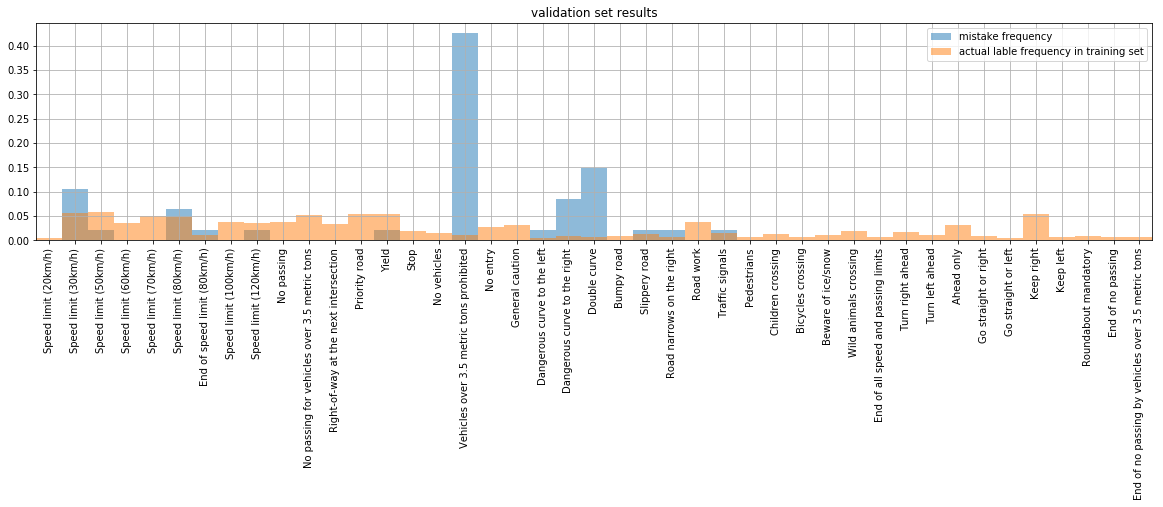

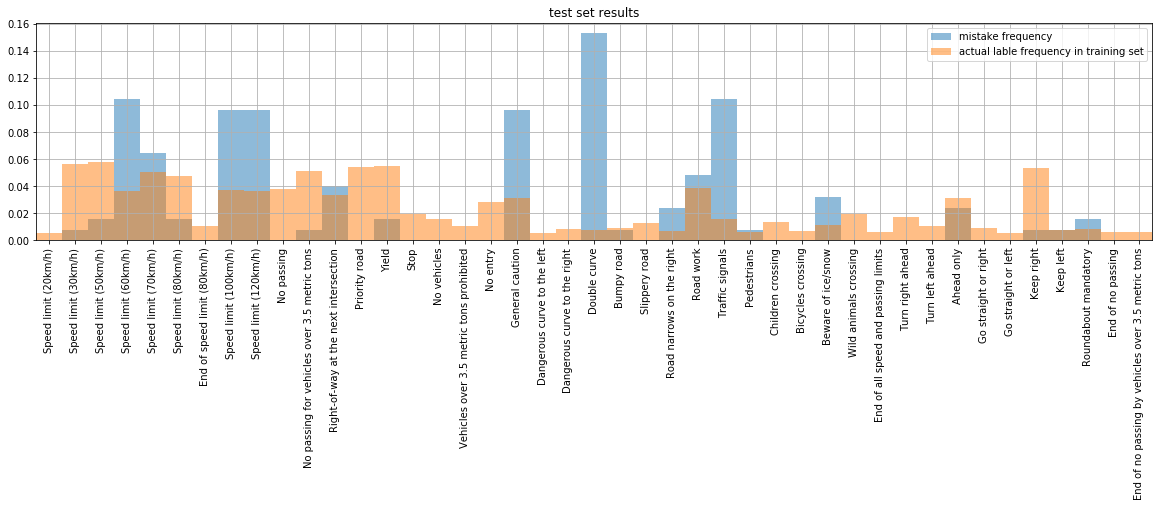

In [95]:
hist_misclass(cp=valid_cp, ya=valid_ya, yp=valid_yp, title='validation set results')
hist_misclass(cp=test_cp, ya=test_ya, yp=test_yp, title='test set results')

(47, 32, 32, 1)
[  1.   1.   1.   1.   1.   2.   5.   5.   5.   6.   8.  13.  16.  16.  16.
  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.  16.
  16.  16.  19.  20.  20.]
[  4.   4.   4.   4.  15.   3.   7.  10.  10.   5.   7.  12.  41.  41.  41.
  41.  41.  41.   9.  41.   9.   9.   9.   9.   9.   9.  41.  41.  41.  41.
   9.   9.  29.  27.  27.]


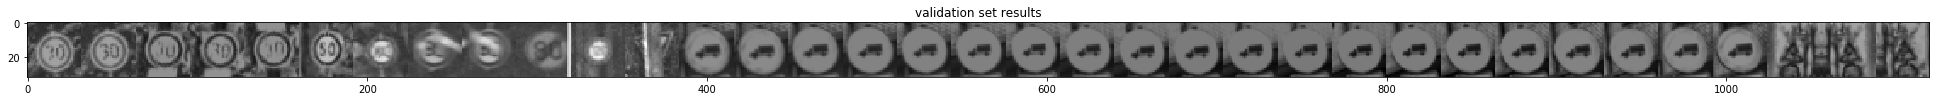

(124, 32, 32, 1)
[ 30.  30.  25.  38.  26.   4.  30.   4.  26.  11.  11.  25.   8.   3.  21.
   7.  21.   4.  18.   8.   7.  21.  18.   2.   4.  24.   5.   8.   1.  24.
  27.   5.   3.   8.   2.]
[ 11.  23.  27.   2.  25.   2.  23.   1.  25.  30.  30.  11.   5.   5.  26.
   8.  26.   1.  26.   7.   8.  26.  11.   1.  18.  27.   1.   3.   2.  18.
  11.   7.   5.   5.   1.]


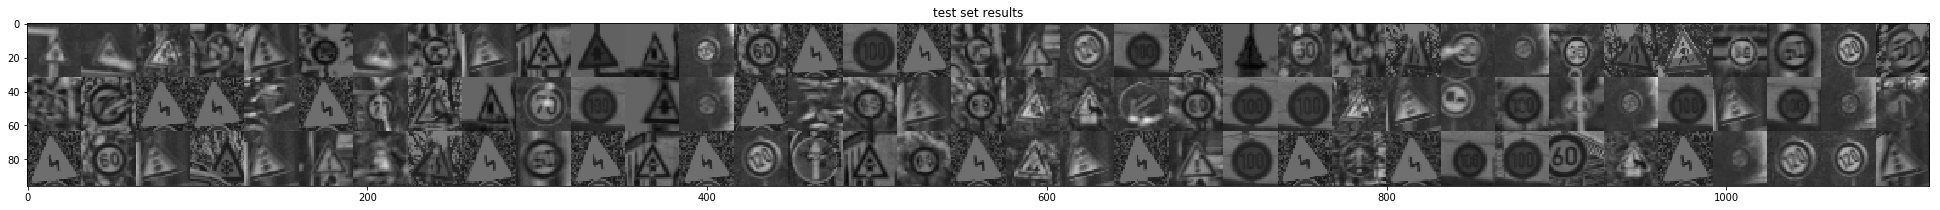

In [96]:
plot_misclass_images(X_data=data_set1[2], cp=valid_cp, ya=valid_ya, yp=valid_yp, title='validation set results')
plot_misclass_images(X_data=data_set1[4], cp=test_cp, ya=test_ya, yp=test_yp, title='test set results')

Confusion matrix, without normalization


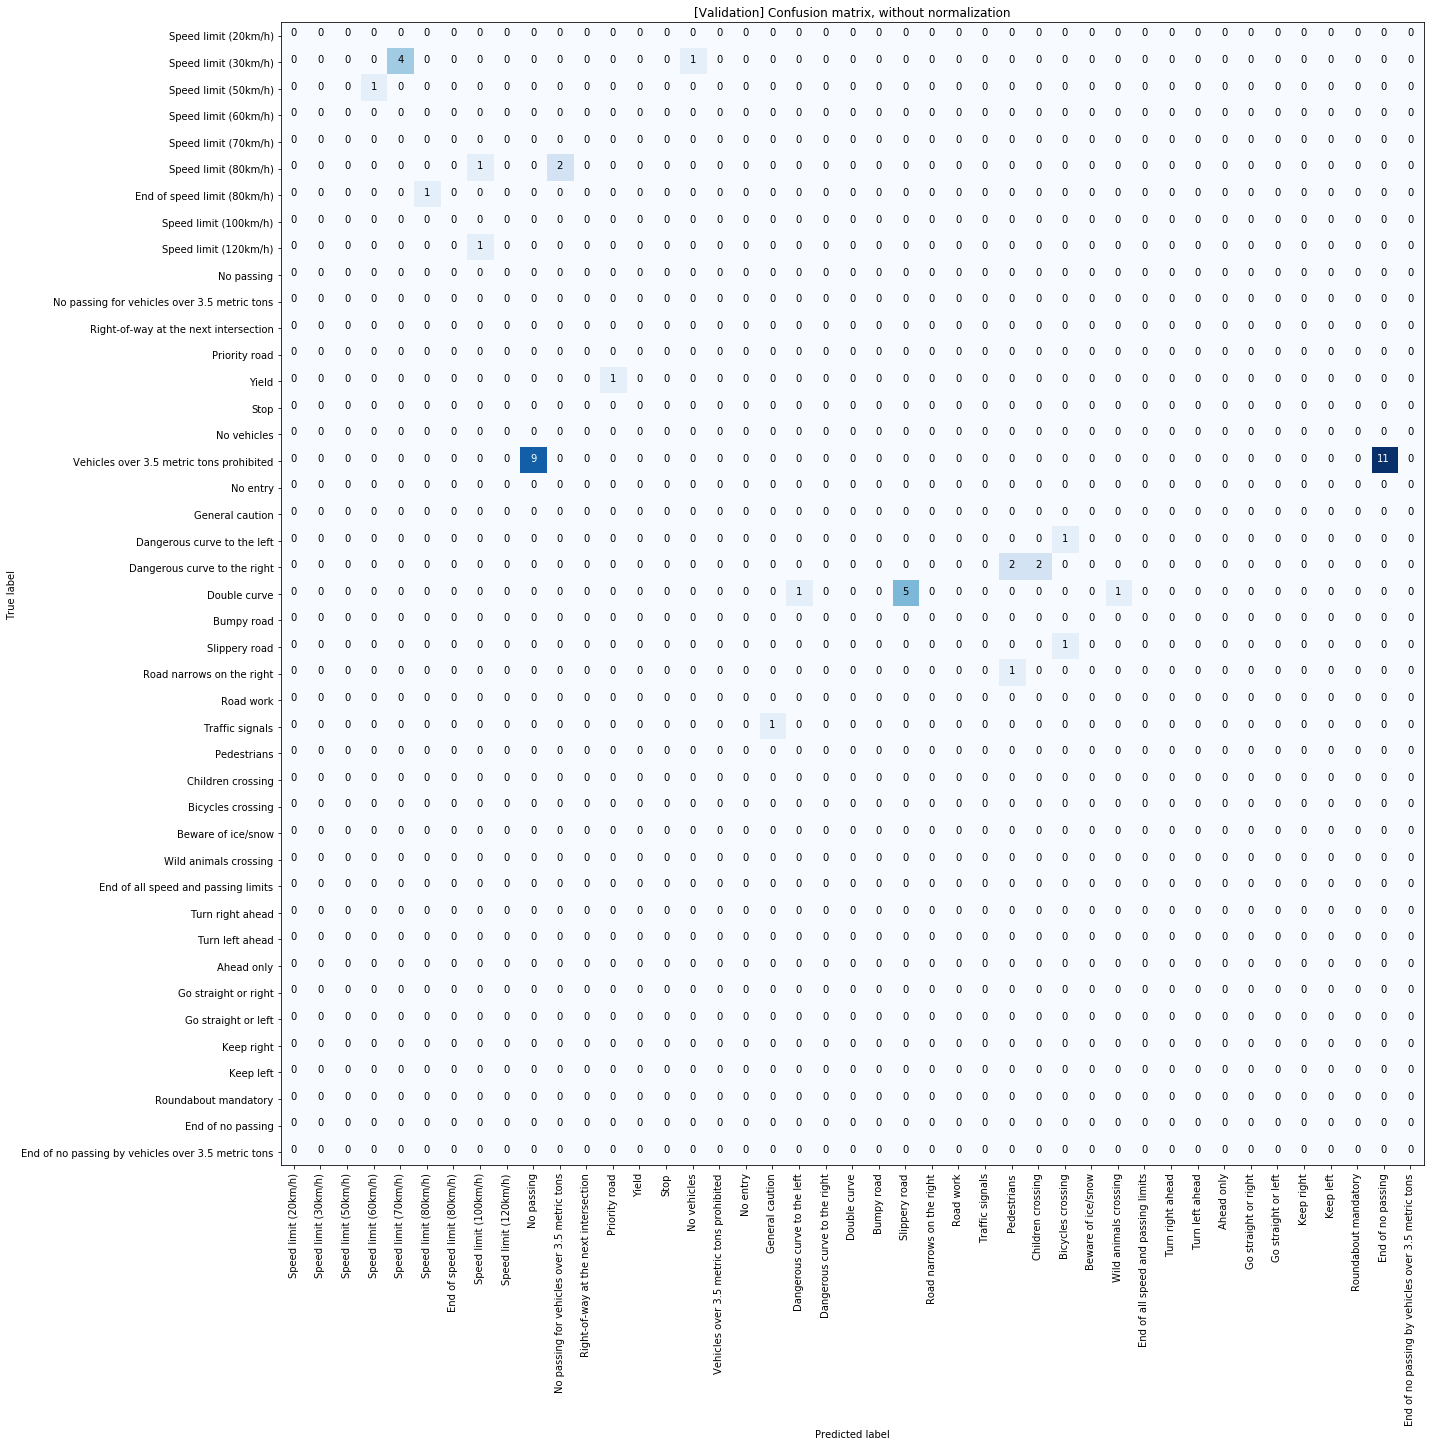

Confusion matrix, without normalization


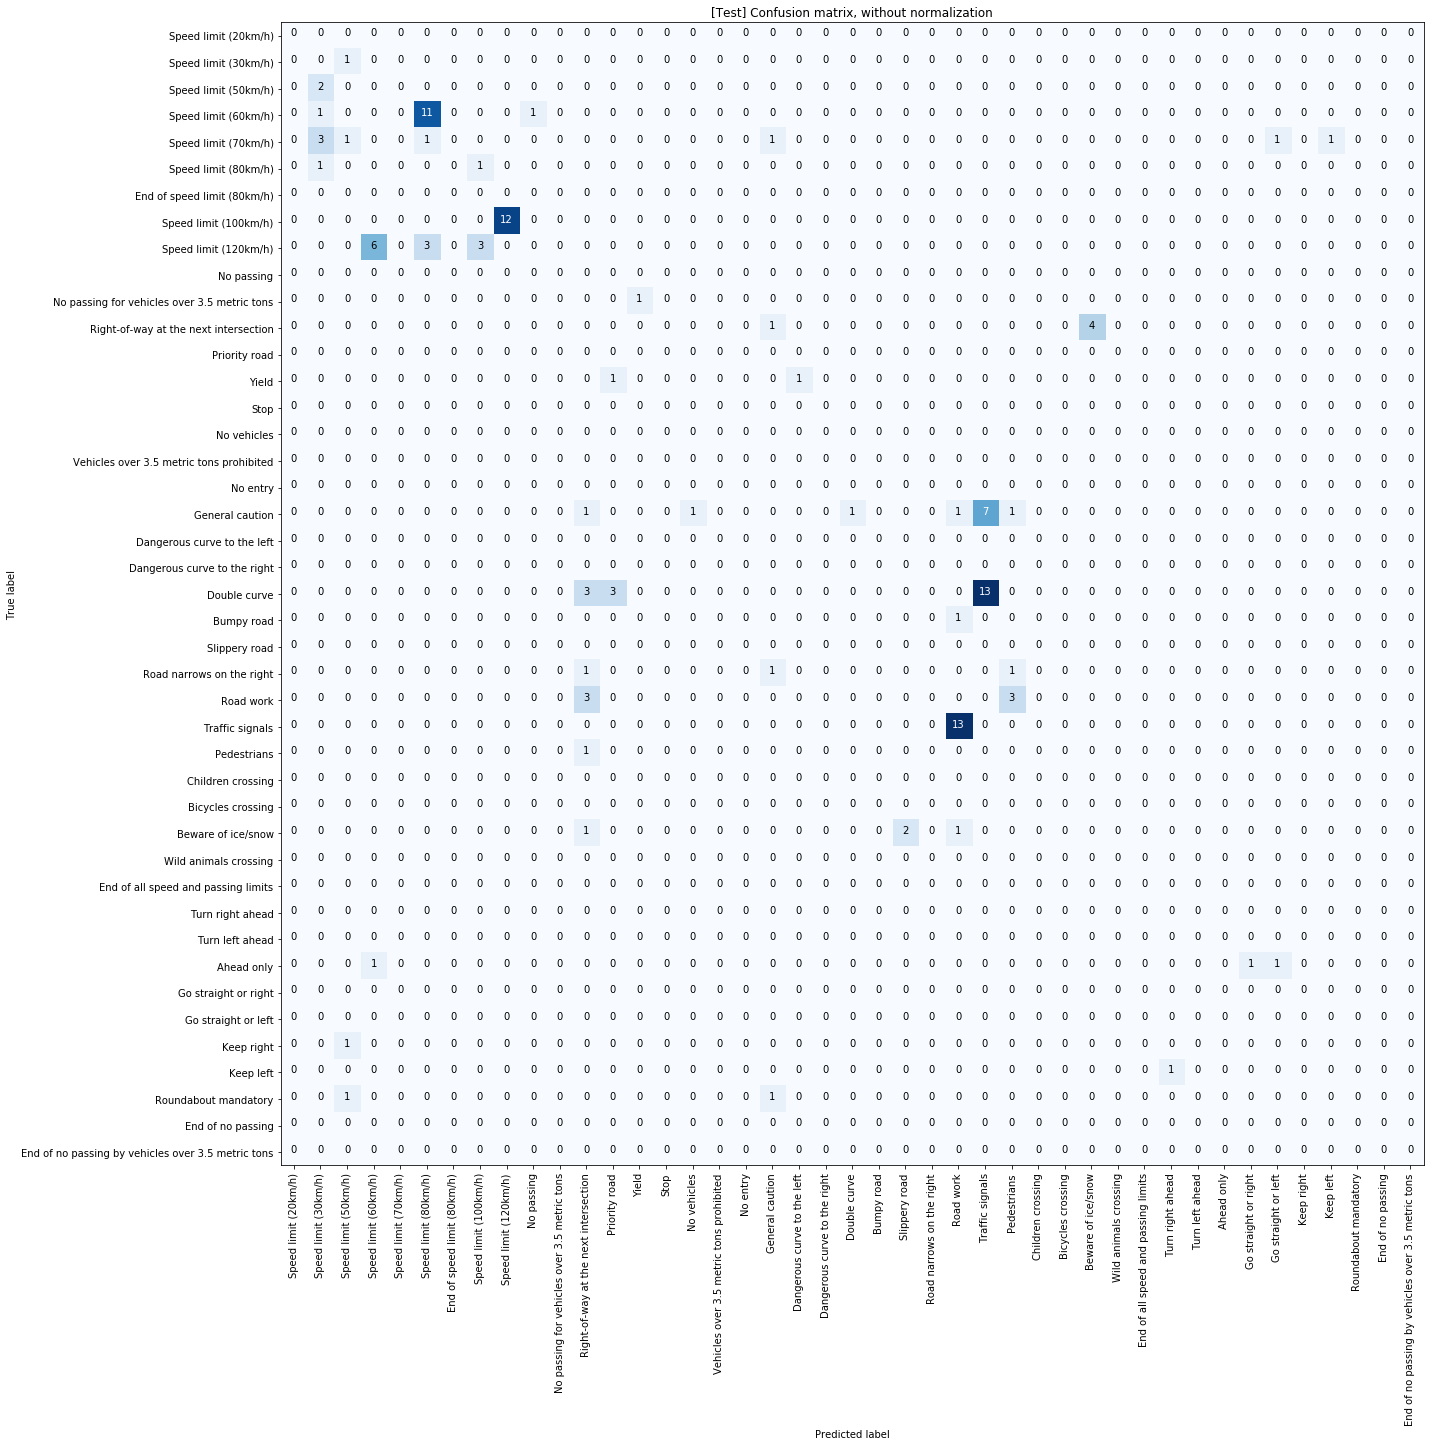

In [97]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(valid_ya, valid_yp)
np.set_printoptions(precision=2)
for i in range(cnf_matrix.shape[0]):# set diagonal line to 0 to better see actual confusion entries
    cnf_matrix[i][i]=0
class_names = sign_df.SignName
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='[Validation] Confusion matrix, without normalization')
plt.show()


cnf_matrix = confusion_matrix(test_ya, test_yp)
np.set_printoptions(precision=2)
for i in range(cnf_matrix.shape[0]):# set diagonal line to 0 to better see actual confusion entries
    cnf_matrix[i][i]=0
class_names = sign_df.SignName
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='[Test] Confusion matrix, without normalization')
plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

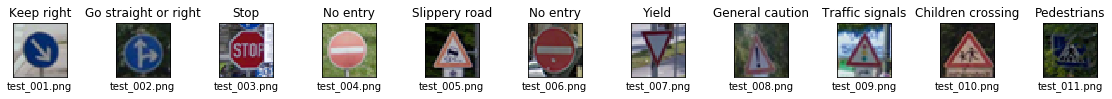

In [98]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, cv2, skimage
X_custom = []
y_custom = np.array([38, 36, 14, 17, 23, 17, 13, 18, 26, 28, 27])
N_custom = 11
plt.figure(figsize=(20,1))
for i in range(N_custom):
    image = cv2.imread(os.path.join('data', 'test_images', 'test_{0:0>3}.png'.format(i+1)))
    image = image[:,:,::-1]
    plt.subplot(1, N_custom, i+1)
    plt.imshow(image)
    plt.title(sign_df.loc[y_custom[i]]['SignName'])
    X_custom.append(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('test_{0:0>3}.png'.format(i+1))
X_custom = np.asarray(X_custom)
X_custom_orig = X_custom.copy()


In [99]:
X_custom = tu.preprocess_data(X_custom)

Input shapes:  (11, 32, 32, 3)
Using gray



100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 5482.75it/s]

Output shapes:  (11, 32, 32, 1)


### Predict the Sign Type for Each Image

In [100]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
result, top_k = tu.train_model(None, None, X_custom, y_custom, X_custom, y_custom,
                        model=tu.sermanet_v2, model_params=tu.params_sermanet_v2, resuming=True, max_epochs=-1,
                        return_top_k=True)

========= train_model() arguments: ==========
resuming = True
model = <function sermanet_v2 at 0x0000028400A2D510>
model_params = {'conv3_p': 0.7, 'conv1_d': 32, 'fc4_p': 0.5, 'model_name': 'sermanet_v2', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv3_d': 128, 'fc4_size': 1024, 'conv3_k': 5, 'conv2_k': 5, 'num_classes': 43, 'conv1_p': 0.9}
learning_rate = 0.001
max_epochs = -1
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = True
plot_featuremap = False
sermanet_v2__conv1_d_32_conv1_k_5_conv1_p_0.9_conv2_d_64_conv2_k_5_conv2_p_0.8_conv3_d_128_conv3_k_5_conv3_p_0.7_fc4_p_0.5_fc4_size_1024
4b3d0a658c5b28b4
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\4b3d0a658c5b28b4
{'conv3_p': 0.7, 'conv1_d': 32, 'fc4_p': 0.5, 'model_name': 'sermanet_v2', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv3_d': 128, 'fc4_size': 1024, 'conv3_k': 5, 'conv2_k': 5, 'num_classes': 43, 'co

### Analyze Performance

In [101]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
#print(result)
print('Prediction accuracy: {}%'.format(result['test_cp'].mean()*100))
idx = np.arange(len(result['test_cp']))
print(idx[result['test_cp']==0])

Prediction accuracy: 100.0%
[]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

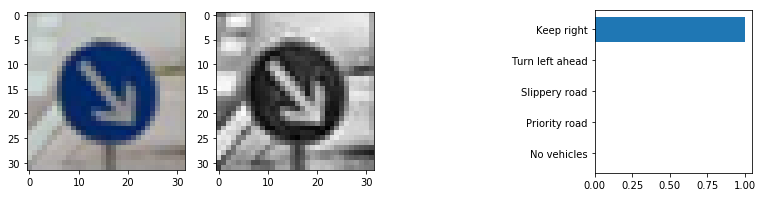

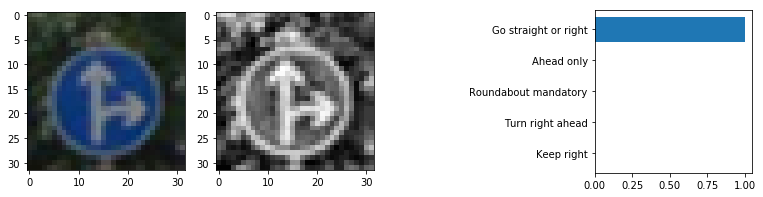

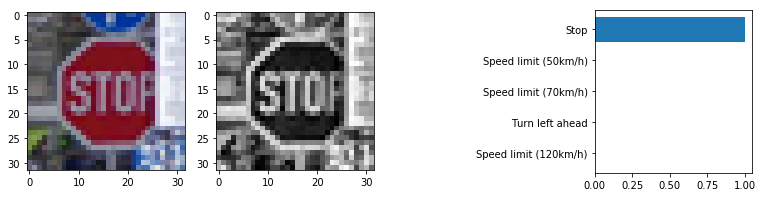

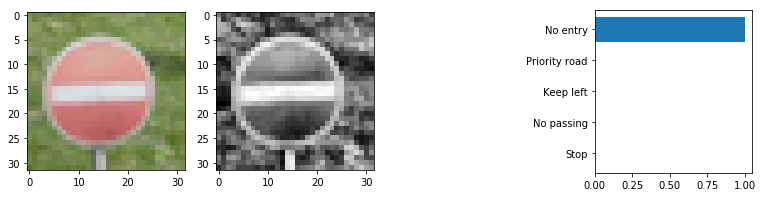

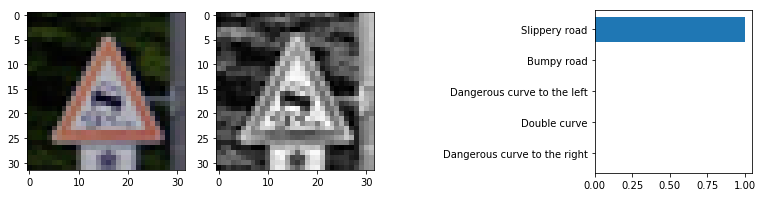

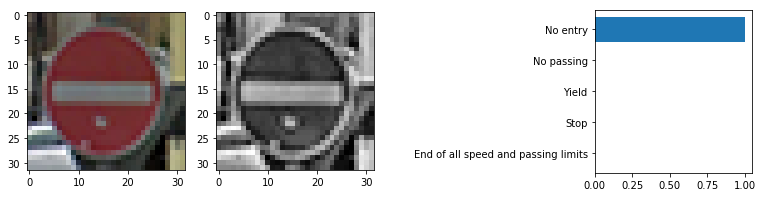

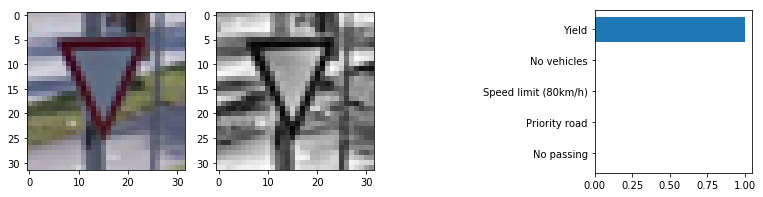

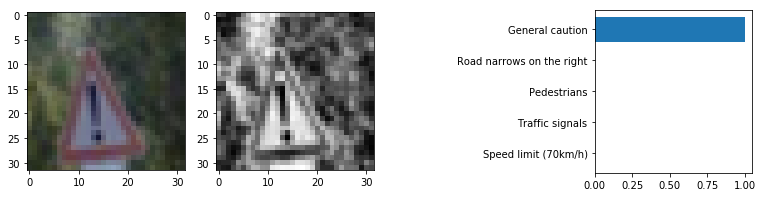

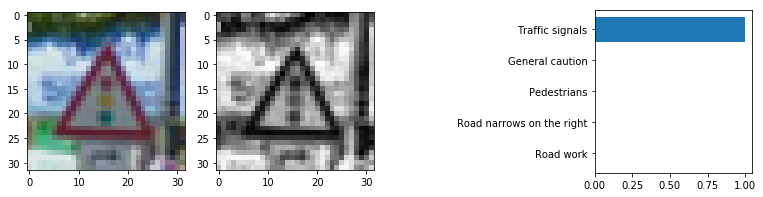

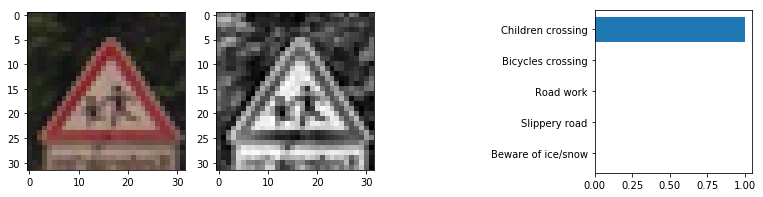

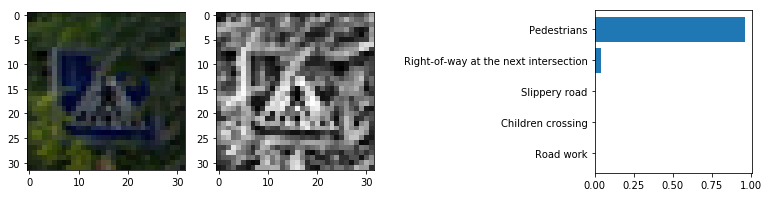

In [102]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
#print(top_k)
for i in range(N_custom):
    plt.figure(figsize=(13,3))
    plt.subplot(1,4,1)
    plt.imshow(X_custom_orig[i])
    plt.subplot(1,4,2)
    plt.imshow(X_custom[i,:,:,0], cmap='gray')
    plt.subplot(1,4,4)
    plt.barh(np.arange(5), top_k[0][0][i][::-1])
    plt.yticks(np.arange(5), sign_df.loc[top_k[0][1][i][::-1]]['SignName'])
    

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [103]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

========= train_model() arguments: ==========
resuming = True
model = <function lenet at 0x0000028574F19730>
model_params = {'conv1_d': 24, 'model_name': 'lenet', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv1_p': 0.8, 'fc4_p': 0.5, 'conv2_k': 5, 'fc3_size': 480, 'fc3_p': 0.5, 'num_classes': 43, 'fc4_size': 252}
learning_rate = 0.001
max_epochs = -1
batch_size = 256
early_stopping_enabled = True
early_stopping_patience = 10
log_epoch = 1
print_epoch = 1
top_k = 5
return_top_k = True
plot_featuremap = True
lenet__conv1_d_24_conv1_k_5_conv1_p_0.8_conv2_d_64_conv2_k_5_conv2_p_0.8_fc3_p_0.5_fc3_size_480_fc4_p_0.5_fc4_size_252
15f0db4c8f34addc
model dir: C:\Users\dingran\github\CarND-Traffic-Sign-Classifier-Project\models\15f0db4c8f34addc
{'conv1_d': 24, 'model_name': 'lenet', 'conv2_p': 0.8, 'conv2_d': 64, 'conv1_k': 5, 'conv1_p': 0.8, 'fc4_p': 0.5, 'conv2_k': 5, 'fc3_size': 480, 'fc3_p': 0.5, 'num_classes': 43, 'fc4_size': 252}
lenet pool2 reshaped size:  [None, 4096]
<tf.Variable 'c

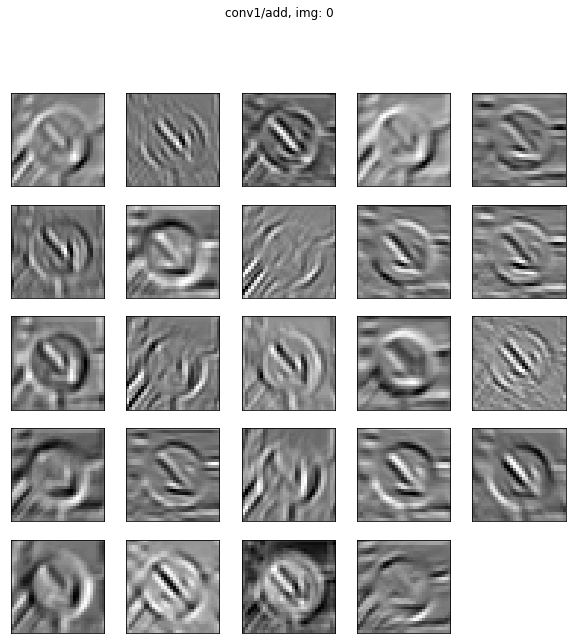

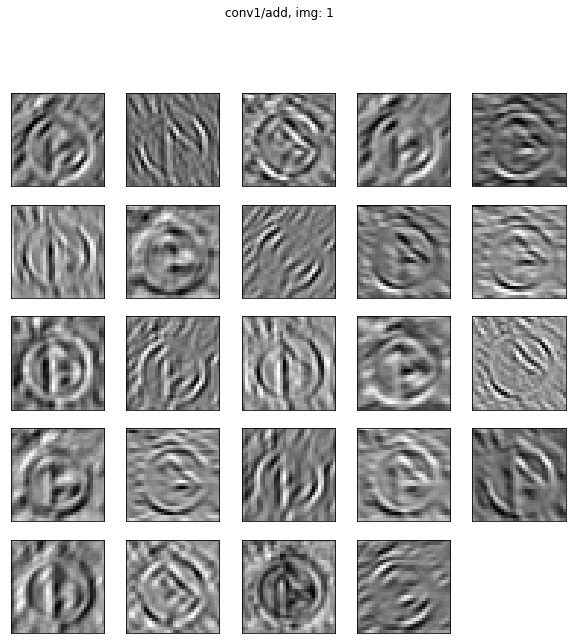

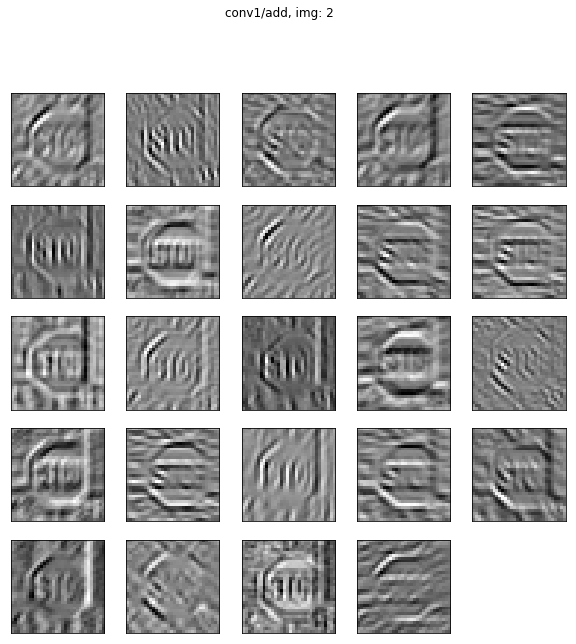

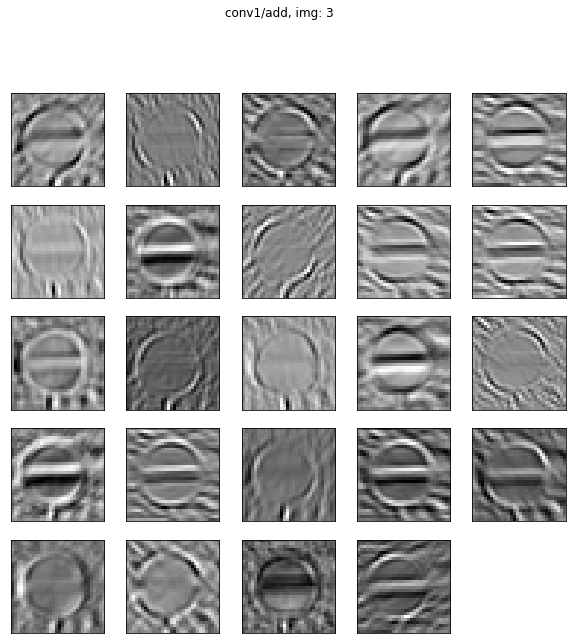

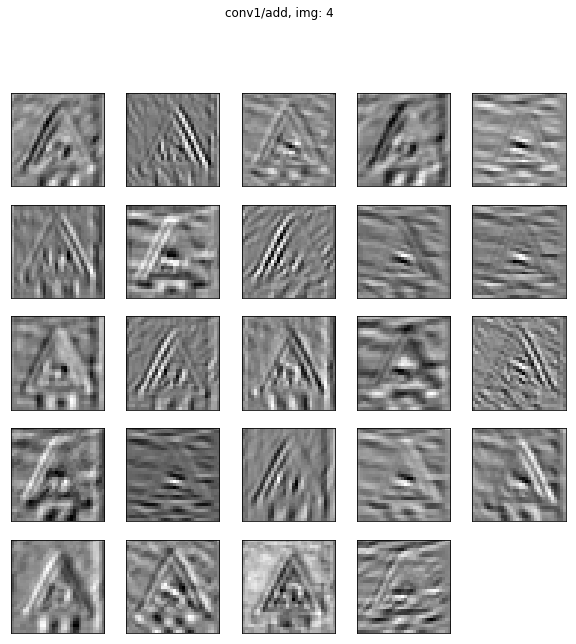

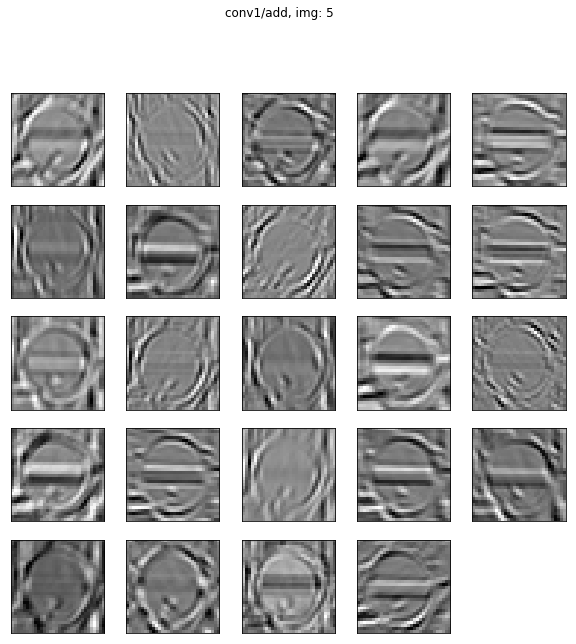

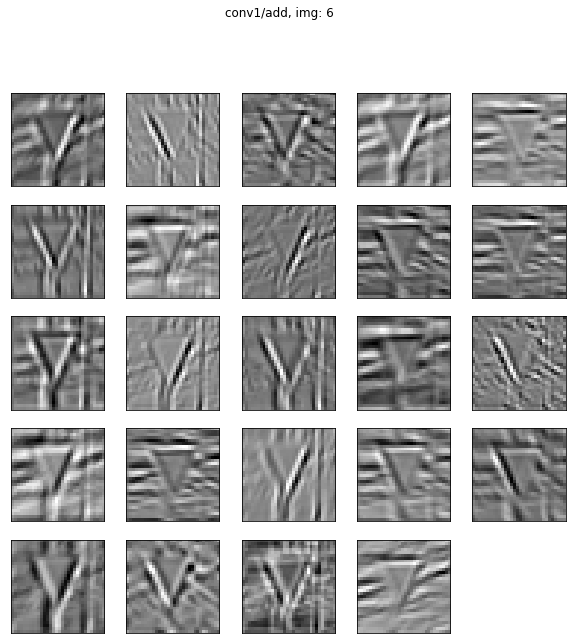

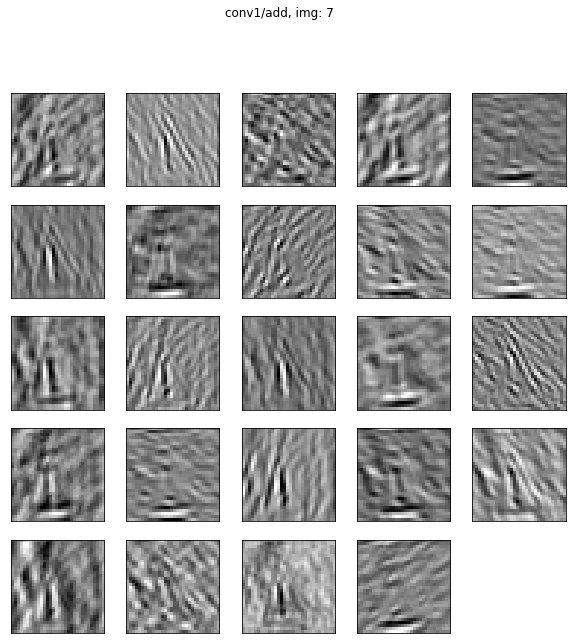

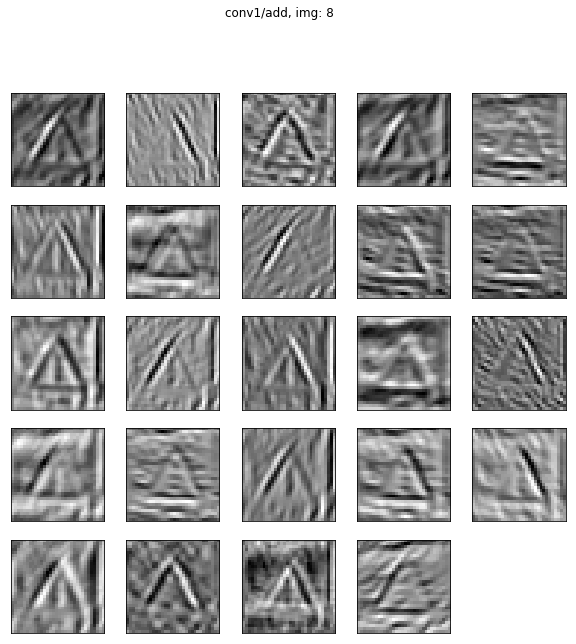

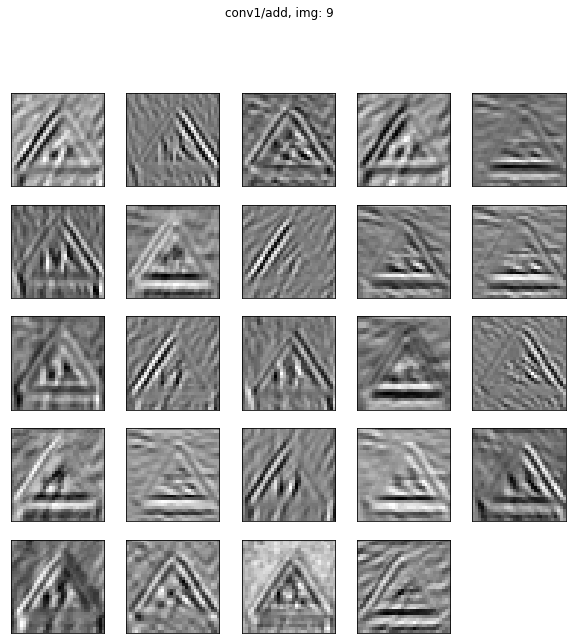

In [104]:
result, top_k = tu.train_model(None, None, X_custom, y_custom, X_custom, y_custom,
                        model=model, model_params=params, resuming=True, max_epochs=-1,
                        return_top_k=True, plot_featuremap=True)